In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [23]:
data=1000
batch=100
set=10
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
m2=-1
lam=1
c_reg1=0.01
c_reg2=0.0001
d=3

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1873758416946703>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.30751417349368215>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.2559788654463533>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.27239317267783225>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([1.86206139, 0.78907344, 1.32592918, 1.04842105, 1.98785726,
       2.05968263, 2.51760599, 2.2081702 , 2.43637522, 1.07028441])>


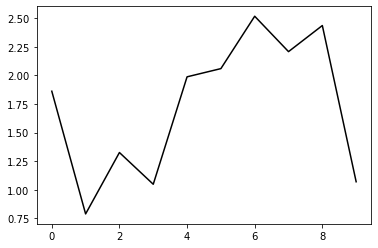

In [24]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
#m2=tf.constant(np.float64(5.6))
#lam=tf.constant(np.float64(0.61))
#alpha=tf.constant(np.float64(1.444635))
#beta=tf.constant(np.float64(0.00615))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

In [5]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

In [6]:
x=[i*0.1 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
fp1 = np.polyfit(x, y, 15)
print(fp1)

[ 2.60581612e-01 -5.58472955e+00  5.38266808e+01 -3.08275478e+02
  1.16790041e+03 -3.08347723e+03  5.82285230e+03 -7.94502014e+03
  7.81868298e+03 -5.47798636e+03  2.66286328e+03 -8.59692413e+02
  1.71291955e+02 -1.84108983e+01  9.55260239e-01 -6.54557458e-05]


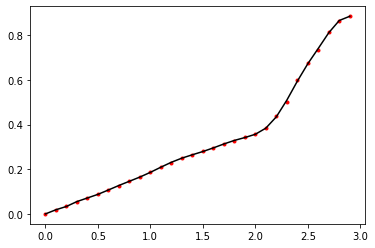

In [7]:
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.1) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [8]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 3.0)
        M=np.random.uniform(0.0, 1.0)
        noise=np.abs(np.random.normal(0, 0.025))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 3.0)
        M=np.random.uniform(0.0, 1.0)
        noise=np.abs(np.random.normal(0, 0.025))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative

In [9]:
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))

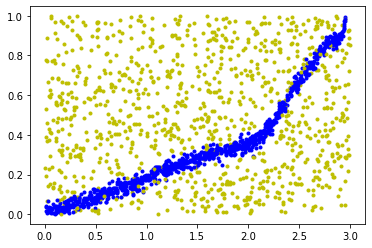

In [10]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

In [11]:
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

In [12]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=(d/2)*(D-1)*alpha*HH+(d/2)*(-D-1)*beta*MM
    for j in range (layer-1):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(hh, m, la, alpha, beta, H, M)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN

In [25]:
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[1])

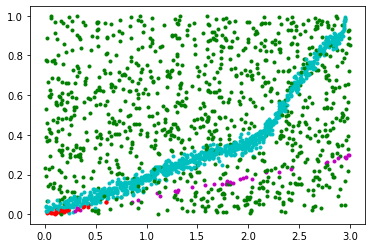

In [26]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [27]:
def Error_func(hh, m, la, alpha, beta, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(hh, m, la, alpha, beta, H0, M0)
    H_1, M_1=LP2(hh, m, la, alpha, beta, H1, M1)
    PPlist=t_func(M_0)
    NNlist=t_func(M_1)
    sum_p=sum(PPlist)
    sum_n=(batch-sum(NNlist))

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return sum_p+sum_n+E_reg1+E_reg2

In [28]:
for i in range (set):
    print(Error_func(h, m2, lam, alpha, beta, Positive[i], Negative[i]))

tf.Tensor(101.75274524734293, shape=(), dtype=float64)
tf.Tensor(96.99492670434307, shape=(), dtype=float64)
tf.Tensor(100.81824151833699, shape=(), dtype=float64)
tf.Tensor(98.16825702001692, shape=(), dtype=float64)
tf.Tensor(100.60487213939788, shape=(), dtype=float64)
tf.Tensor(103.44662118713113, shape=(), dtype=float64)
tf.Tensor(97.99280638355101, shape=(), dtype=float64)
tf.Tensor(100.56157445268998, shape=(), dtype=float64)
tf.Tensor(99.59146561601813, shape=(), dtype=float64)
tf.Tensor(100.02430799377865, shape=(), dtype=float64)


# Optimize

0 98.939439112099
2.152032596682829 -0.27217092686124134 0.2206356153295157 0.30773642277990354
[1.9620614  0.68907345 1.22592919 0.94842106 1.88785729 1.95968266
 2.41760606 2.10817038 2.53637327 1.17025202]


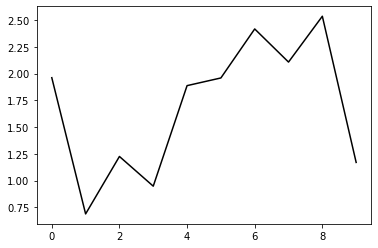

1100 100.22634869361744
2.0928591366625513 -0.19211305857244293 0.1405361746433762 0.3834569440921048
[2.10844625 0.57003753 1.09846803 0.83677038 1.78278966 1.88621287
 2.40070027 2.24107126 2.93643346 2.23231221]


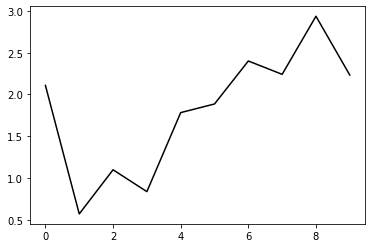

2200 97.24888250169927
2.3273517569312028 -0.45673526844479273 0.395815315539677 0.1963785040457923
[1.30108168 1.36087304 1.87388551 1.61197516 2.53432119 2.6087779
 3.04557409 2.71236039 3.06993131 3.24350104]


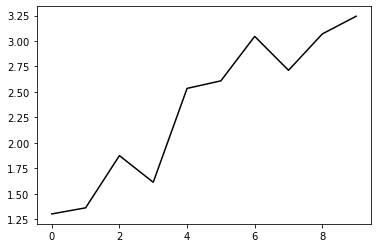

3300 99.44633775145779
2.3358672197739185 -0.5674042949871821 0.4492514926882515 0.18718999570579023
[1.28531048 1.39297948 1.89759497 1.62912067 2.52357338 2.55903636
 2.91388723 2.43781298 2.64427338 4.20432616]


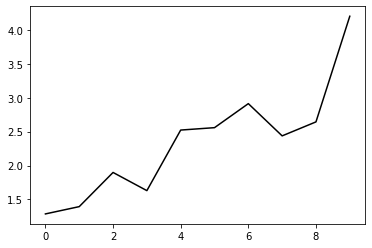

4400 99.14463186350122
2.277450653997087 -0.5328745508155827 0.39087866038202285 0.24534117574424913
[1.59703192 1.13310466 1.63993937 1.38876959 2.29324535 2.36261535
 2.77570091 2.43050314 2.84476651 5.12255266]


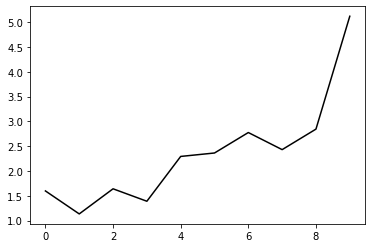

5500 101.86754561287079
2.254282704527258 -0.3597608881010252 0.26407545772228586 0.3196838184366849
[1.88710645 0.82076569 1.31014394 1.05530071 1.95179543 2.0256246
 2.45389058 2.16886964 2.77601462 5.99719684]


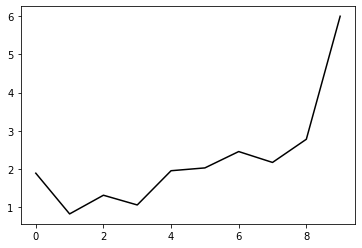

6600 97.36066590606232
2.345380971203826 -0.36142053685123926 0.33402813706945944 0.2839064779652442
[1.47932527 1.30585339 1.77260077 1.50132772 2.36509977 2.39939467
 2.75939599 2.36343735 2.7702306  6.83222168]


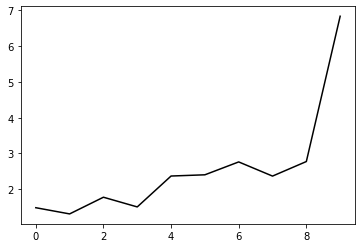

7700 100.00493398107946
2.3545766869374187 -0.45633497140986684 0.4020149646714013 0.23644363232507795
[1.27651483 1.48566687 1.94149037 1.65707666 2.48890149 2.47504797
 2.74870377 2.21255462 2.41039917 7.56515381]


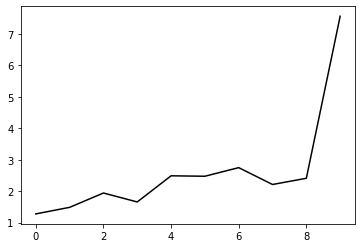

8800 101.03940599190759
2.3904203741123173 -0.47752782873040567 0.4329822044092741 0.21864181740272162
[1.19340733 1.56984484 2.02408671 1.74255479 2.57028642 2.55657309
 2.82542308 2.2807287  2.45596901 8.19944192]


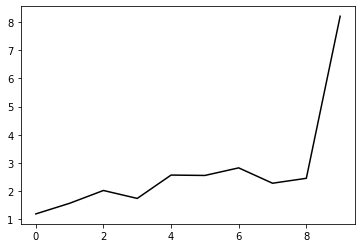

9900 100.18578747562283
2.4012199221060015 -0.47729913217125836 0.4373501603954271 0.22544719932507576
[1.21980926 1.56395372 2.01927434 1.74636198 2.57455002 2.5731986
 2.85704565 2.34314522 2.56549006 8.66327602]


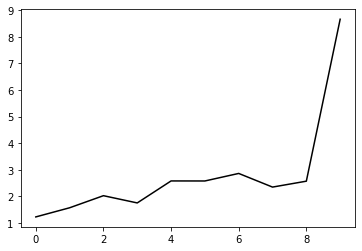

11000 100.00702339772849
2.4145787165781107 -0.49200460269218266 0.44736498889608983 0.22774624792622475
[1.14929235 1.67639921 2.13536219 1.87714858 2.71156496 2.73263004
 3.04540484 2.5830658  2.86481594 8.93395408]


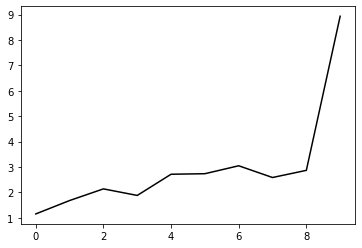

12100 96.09903729024794
2.2602937879183 -0.3372194216872791 0.2741705955967621 0.3719010936016439
[1.82968839 0.98181284 1.41276476 1.1263207  1.90653211 1.85772616
 2.06474145 1.49758444 1.83487641 8.9223669 ]


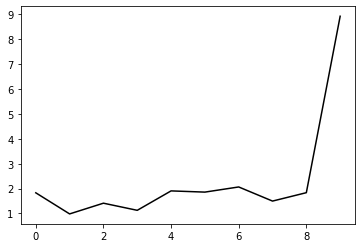

13200 94.00708964107025
2.302221778102382 -0.35408584882057237 0.310826031228305 0.35260635616173774
[1.68818432 1.1756281  1.60273674 1.3184429  2.09398523 2.04261409
 2.23939586 1.65237848 1.94673835 8.89098046]


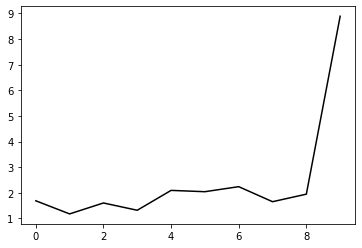

14300 87.46127881628537
2.305539191443549 -0.36109842150198485 0.3496646974661851 0.31609663987784525
[1.44503913 1.36890552 1.74799207 1.40281983 2.07224388 1.8689773
 1.83791246 0.96327781 0.96523766 8.77692671]


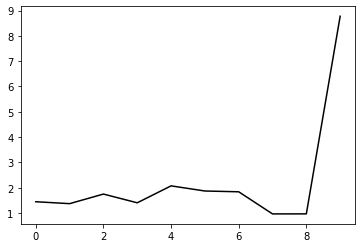

15400 99.500820674357
2.2020570531485464 -0.30198772553350606 0.27660317402897344 0.3644102690081065
[1.80431853 0.97287079 1.32199416 0.94418484 1.55977064 1.29289792
 1.1901768  0.26760174 0.28640709 8.66533588]


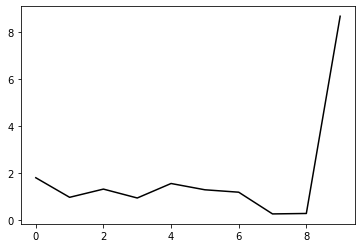

16500 101.02408307661148
2.1999609807646805 -0.28879802886456574 0.2668557718689723 0.3707824193213089
[1.85441564 0.9268699  1.2741838  0.9093935  1.53448096 1.29195314
 1.22229862 0.34868512 0.42441723 8.69116027]


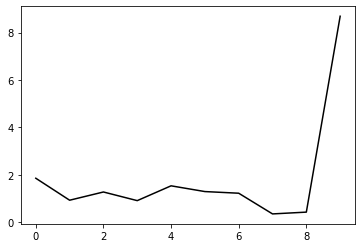

17600 96.77870487317938
2.197961704266897 -0.2870741790265109 0.27065576594369 0.3665573203218867
[1.77457611 1.01656325 1.34051938 0.96595829 1.55732042 1.27941864
 1.15117697 0.20523032 0.20300556 8.64405988]


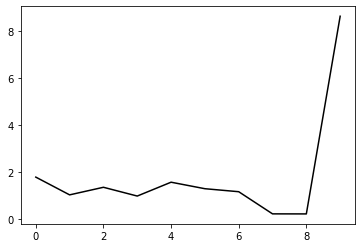

18700 93.30752655650717
2.232884545841912 -0.312084132039295 0.33970780623829844 0.31416050858223976
[ 1.21843091  1.54580341  1.81180753  1.36849248  1.84574516  1.42160972
  1.09245739 -0.09975812 -0.39914013  8.58829002]


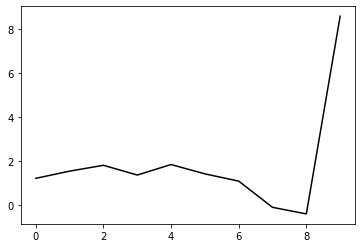

19800 100.01440520049593
2.304781117004323 -0.41247576066680636 0.4367393728073556 0.22336955116085389
[ 0.83985993  1.86353062  2.13029101  1.68794992  2.15571432  1.72059435
  1.3641618   0.11688822 -0.30664828  8.56068754]


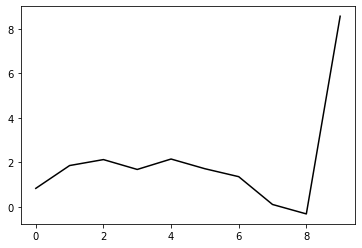

20900 100.01672382878486
2.3113449329275717 -0.414470733819197 0.4453137129769071 0.20761096835600512
[ 0.76850572  1.89686994  2.1635362   1.72449961  2.18278658  1.74530127
  1.37825239  0.11561843 -0.33456292  8.67937364]


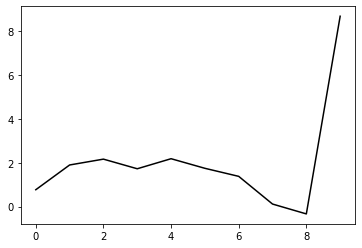

22000 99.03925207454925
2.4401167326732915 -0.5934951218591067 0.48736024999889566 0.1816388493962458
[ 0.51860196  2.35614595  2.72179648  2.47583331  2.79902     2.0842299
  0.77464491 -0.72709766 -1.05649439  8.47944061]


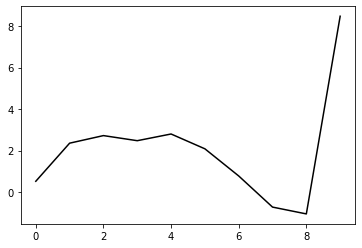

23100 99.44042247367705
2.1813599622845476 -0.33801049311013104 0.31920365394685796 0.29816975920336714
[ 0.9728936   1.60998903  1.95395342  1.70217654  2.02906203  1.435052
  1.02682632  0.08240145 -0.26703442  8.57978715]


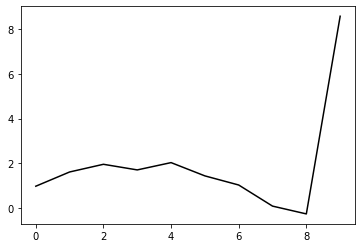

24200 99.06842373876373
2.188424629129689 -0.34167870202089184 0.3403091146746657 0.28940114393085953
[ 0.9476759   1.64587056  1.98827918  1.73739515  2.06646363  1.49018322
  1.20000363  0.12266127 -0.23149303  8.61014134]


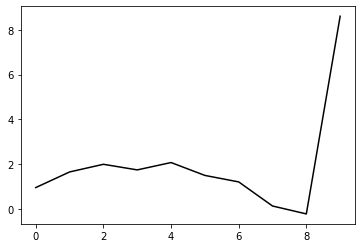

25300 97.24140522776024
2.1845452961725256 -0.3515175747544879 0.3577166776628634 0.27663295367079127
[ 0.88264675  1.69233753  2.02615119  1.76689235  2.0818644   1.48731948
  1.09839503  0.07151891 -0.3069304   8.58767983]


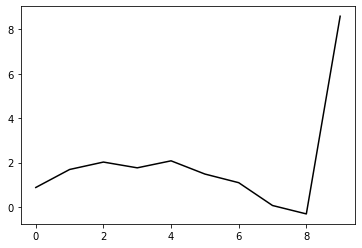

26400 102.04666413973122
2.1825327474435623 -0.35342337685292613 0.35950558494506396 0.27859456505640207
[ 0.91866562  1.66419694  1.99757264  1.73871671  2.044521    1.43305522
  0.97534675  0.01388411 -0.36625898  8.57235999]


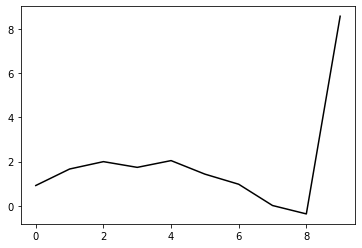

27500 58.08901451653585
2.1349626572196914 -0.3419900761505796 0.28818257737224656 0.35928951326210956
[ 1.2994992   1.25564263  1.58058738  1.30487858  1.5554777   0.81383408
  0.10578202 -0.68867685 -1.08576104  8.52850064]


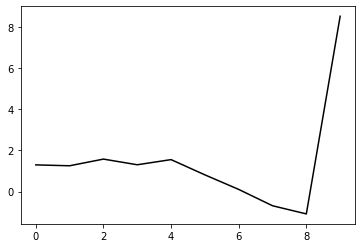

28600 87.03783343515451
2.111728362411342 -0.3363803668223794 0.3024508034447757 0.32968795444852383
[ 1.09576768  1.34932511  1.60503098  1.24768711  1.37707294  0.46906801
 -0.4731619  -1.43695136 -2.04223589  8.34160127]


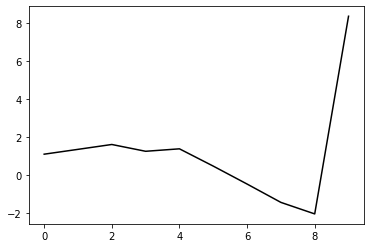

29700 74.91182991211612
2.0312868401116697 -0.3313733378170805 0.27388668158553214 0.3339475557685055
[ 1.30407731  1.01842669  1.20141556  0.75936899  0.77402582 -0.27229117
 -1.37944876 -2.46997528 -3.18140495  8.12509041]


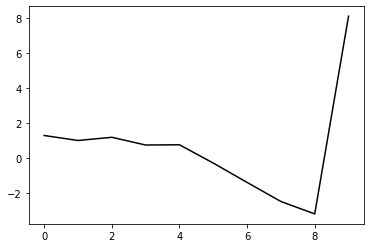

30800 45.52622866117813
1.9272533550863564 -0.34325093118030864 0.2884595158626685 0.2873419151004846
[ 1.31107295  0.90481864  1.01758895  0.49180061  0.39544569 -0.78355461
 -2.06432867 -3.38471003 -4.37067964  8.05793617]


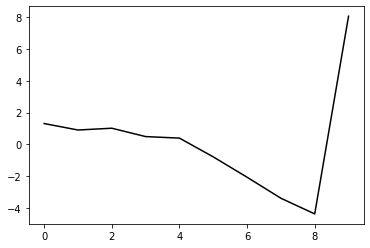

31900 29.610231961727823
1.896725133673382 -0.3420718416619753 0.2869812399530434 0.2805736230108813
[ 1.260434    0.95673361  1.05328224  0.51163893  0.39174123 -0.81348107
 -2.13173075 -3.51112351 -4.60148201  7.99157327]


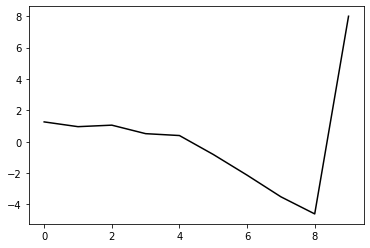

33000 27.070364276136832
1.877096907580888 -0.3581024938178072 0.29382370505925276 0.2712048139922052
[ 1.25425383  0.95980237  1.05014585  0.50395989  0.37235452 -0.84493287
 -2.18327402 -3.59634972 -4.74766394  7.93788976]


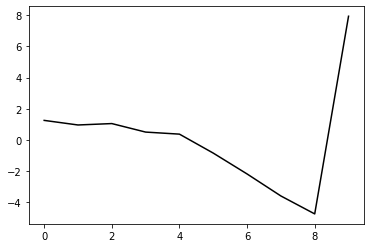

34100 41.09890770801029
1.7968194169042844 -0.38224951732138734 0.29673190347099543 0.244358592986859
[ 1.2542411   0.9368658   0.99362007  0.41053212  0.22729758 -1.050865
 -2.47697498 -4.03439667 -5.44755443  7.88711423]


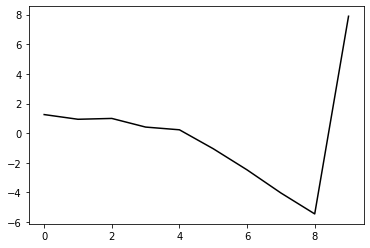

35200 39.624594910983376
1.802406763237252 -0.4110537835739587 0.3114573497615817 0.23966992354988292
[ 1.18888803  1.03644716  1.10047329  0.52699449  0.34866531 -0.92342571
 -2.34723371 -3.90864149 -5.34318505  7.84326458]


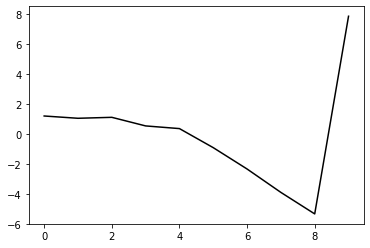

36300 43.59021733865372
1.77645608349574 -0.44849739962037777 0.31989242855417876 0.23977472948853765
[ 1.18161032  1.06958629  1.12803874  0.549302    0.3577503  -0.92892561
 -2.37691135 -3.97897173 -5.48406043  7.88554157]


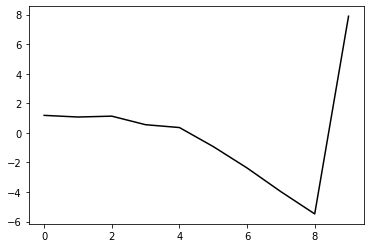

37400 35.778866085634114
1.7192644827032235 -0.4890379048790819 0.31419592000023194 0.25474489878920653
[ 1.29583456  0.9818138   1.0352277   0.4518173   0.24809993 -1.05168468
 -2.52165667 -4.16260477 -5.74841633  7.92383919]


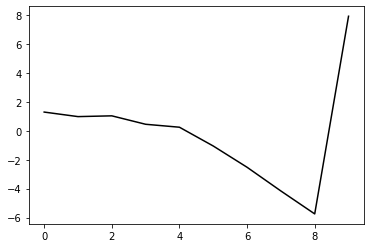

38500 53.50061968391454
1.6879187582767614 -0.5355315903444199 0.3133172713302394 0.27056664251773865
[ 1.39720688  0.93338757  0.99353178  0.41868668  0.21759965 -1.07881346
 -2.5509427  -4.2032028  -5.82393771  7.85150636]


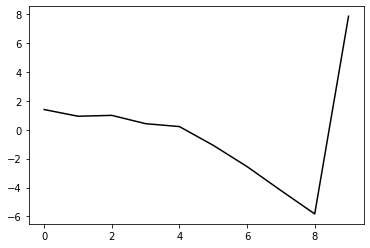

39600 54.31433501663787
1.6520654419343856 -0.5823729545371016 0.3113318184332304 0.2890623276685938
[ 1.39068926  0.99269079  1.0563336   0.48671515  0.28497999 -1.01181403
 -2.49096038 -4.16278954 -5.83630362  7.78312186]


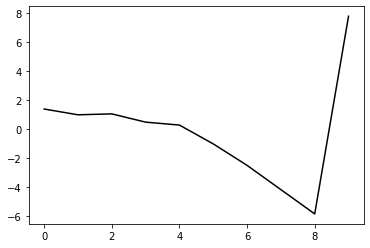

40700 29.482785478731035
1.654187279823606 -0.6524320964500697 0.34523480223566305 0.2787052026816127
[ 1.30429658  1.13351536  1.21199871  0.6582794   0.46585233 -0.82186555
 -2.29963854 -3.98355296 -5.70075288  7.86546624]


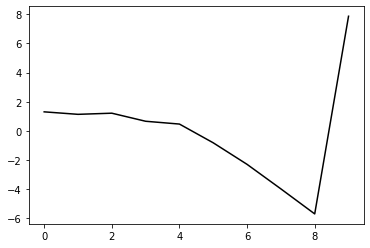

41800 28.81177258056387
1.5491273400265415 -0.7694693742693497 0.3679216315002624 0.2837000855886879
[ 1.36444655  1.10860295  1.20161798  0.66633095  0.48978869 -0.77742894
 -2.2424308  -3.94344411 -5.76507313  7.76424514]


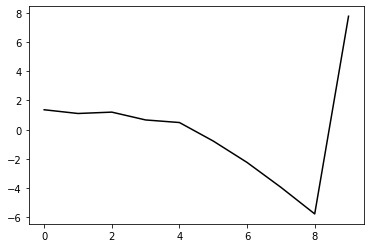

42900 17.768201439291957
1.5315906835354103 -0.8072691268625324 0.38648396160221743 0.2949707566332271
[ 1.38784824  1.15140711  1.27214075  0.76861935  0.62132644 -0.61294504
 -2.04691954 -3.72179695 -5.53434598  7.89207455]


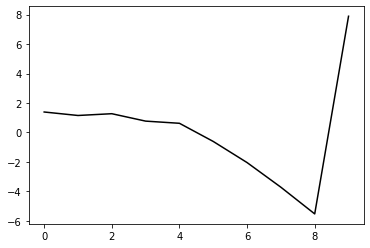

44000 18.893466575963327
1.5734553946360808 -0.7625589790061587 0.3876849572265977 0.28846361779766827
[ 1.38174987  1.18462012  1.33478567  0.87503721  0.78231571 -0.37349472
 -1.71378456 -3.29312044 -5.03644212  7.88556555]


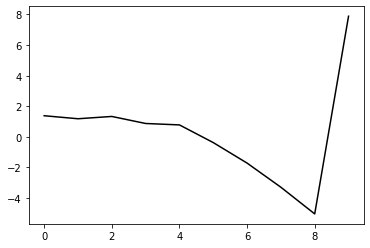

45100 23.695538153452063
1.4893827665381028 -0.7980035342496359 0.40140754943226564 0.27600583556408537
[ 1.45204388  1.12374314  1.26565273  0.80795274  0.71821308 -0.42611725
 -1.76326461 -3.37729293 -5.24577563  7.90074939]


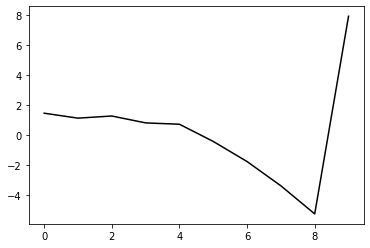

46200 19.747318659216777
1.4977755539193343 -0.7804817077168343 0.4049447729657253 0.2729226434432101
[ 1.48038263  1.11960287  1.28594806  0.85995438  0.80298068 -0.3004085
 -1.59427645 -3.16847181 -5.03358936  8.01379265]


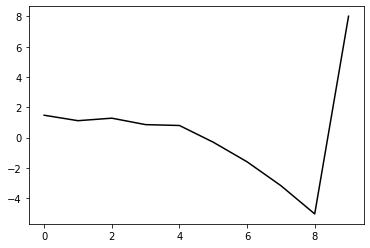

47300 15.246696445744623
1.5563957902736696 -0.7269669447363544 0.39174412466359226 0.2729525080691094
[ 1.48946327  1.1690815   1.34893432  0.94349268  0.90854455 -0.16378251
 -1.41670076 -2.9312815  -4.71922678  7.98759762]


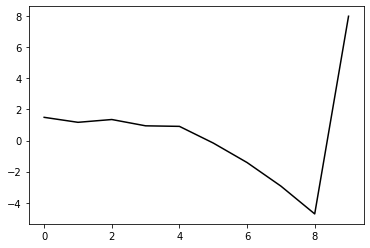

48400 21.66117062823944
1.5304318190693367 -0.7517332517490387 0.4024245314130871 0.2786308835984552
[ 1.49274348  1.23994792  1.42493639  1.02512212  0.98912931 -0.08499591
 -1.34579577 -2.87935999 -4.71909777  8.02459756]


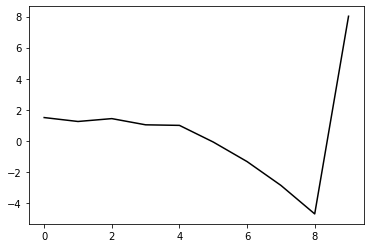

49500 57.93972165357045
1.553904818893015 -0.7192291262553224 0.38241906264447517 0.29823313062243845
[ 1.62747723  1.15058651  1.34580902  0.9608611   0.9378574  -0.11834726
 -1.35748839 -2.8597948  -4.64761393  7.99684435]


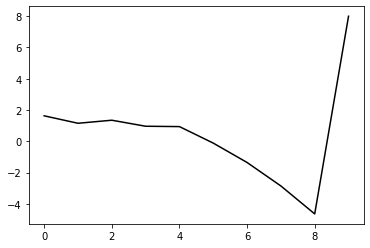

50600 21.40630152573342
1.4992447428594715 -0.7489980447786659 0.3972103024990446 0.27980224785948166
[ 1.52346222  1.25595045  1.43360535  1.034821    0.99322678 -0.08225443
 -1.35263024 -2.91813177 -4.86611362  8.031872  ]


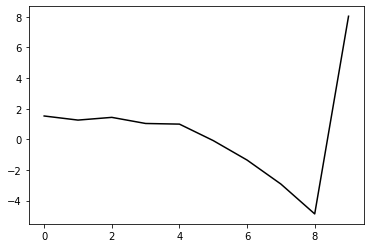

51700 14.675276118395871
1.4896729308442558 -0.7371413277311737 0.3915559708021396 0.27646911535621727
[ 1.51629237  1.28508593  1.45336679  1.04854175  0.99800405 -0.08490753
 -1.36877991 -2.96750409 -5.00829615  7.90148172]


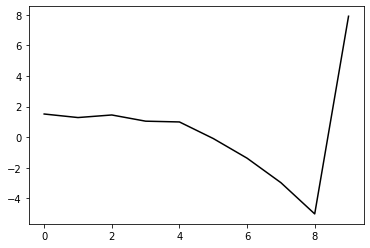

52800 22.586183908635494
1.5019846731005557 -0.7295494751991827 0.3928430041730991 0.27886794375711343
[ 1.57601838  1.25299323  1.43897932  1.0574213   1.03002736 -0.02342976
 -1.27346707 -2.83145726 -4.82928666  7.98409134]


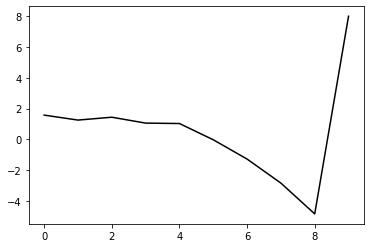

53900 15.414104913786021
1.4595728256071117 -0.7580636515446553 0.40554297407594114 0.2788179711945652
[ 1.5267189   1.3347653   1.51747085  1.13533456  1.09964904  0.03522354
 -1.23989122 -2.85326442 -4.97689013  7.97286466]


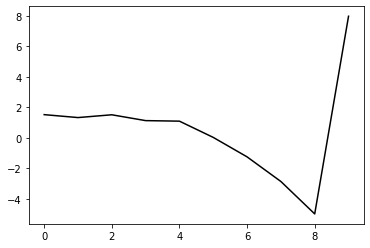

55000 53.137447020313886
1.3814782666873082 -0.8095803337898985 0.4420069909060319 0.25636491740209477
[ 1.53932386  1.33938084  1.52559975  1.14823577  1.11006521  0.04070987
 -1.25465096 -2.93060382 -5.20891011  7.91485098]


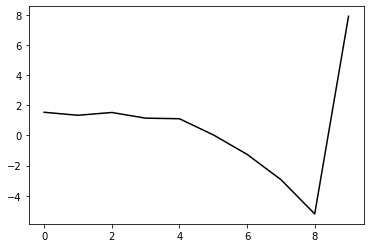

56100 24.782840393858045
1.4742482981670961 -0.7318735545173437 0.3982457630606654 0.2818123552611725
[ 1.58792542  1.35786044  1.53652796  1.1590226   1.12337086  0.0652096
 -1.21042203 -2.85262069 -5.07044991  7.97446246]


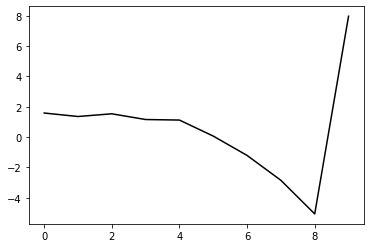

57200 18.040107163110278
1.4484719760658147 -0.7467901701381344 0.4101419723871829 0.2682771254046536
[ 1.54249673  1.41466056  1.58389056  1.20092957  1.15485427  0.08668018
 -1.20744284 -2.88690575 -5.18544847  7.88309573]


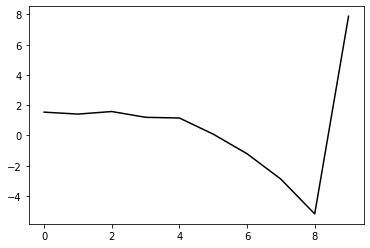

58300 87.41422343422153
1.4915147334599645 -0.6946659658889651 0.3624710824039925 0.3175748067366893
[ 1.72521923  1.32849572  1.5020477   1.13200917  1.10141516  0.06099776
 -1.18980522 -2.79582979 -4.98302913  7.90507297]


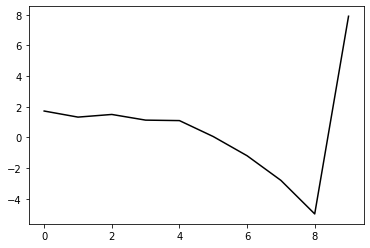

59400 34.070783035186416
1.4335793855702765 -0.7300777732042839 0.3951718103901992 0.2867507407061272
[ 1.6510132   1.36445935  1.52374439  1.14326727  1.09673286  0.04030766
 -1.24183531 -2.91817603 -5.25840763  7.95956186]


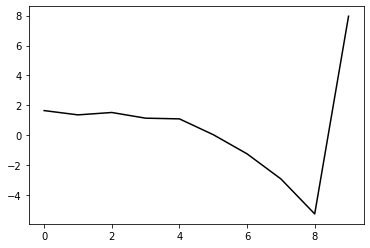

60500 28.35306294542511
1.384666040334907 -0.7193357865651322 0.3905931343931643 0.2653503648064088
[ 1.57899105  1.41335103  1.54507753  1.14215908  1.0697175  -0.01139377
 -1.33460352 -3.10519969 -5.67833313  7.86126439]


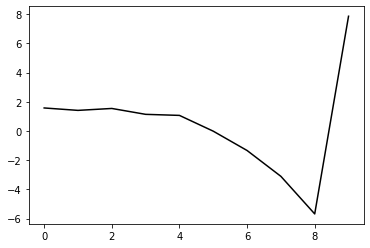

61600 20.72559654370336
1.4663549781230447 -0.68859693412115 0.38863949071117265 0.27246126736132004
[ 1.57175037  1.5168824   1.67636675  1.30714133  1.27076063  0.23498283
 -1.03117691 -2.72328569 -5.19725696  7.85215143]


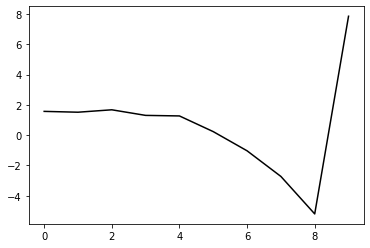

62700 13.566647092809335
1.4568516199444062 -0.6826019722689475 0.3854410365349277 0.27011233174617627
[ 1.56383326  1.55518339  1.70862717  1.33614752  1.2919386   0.24954912
 -1.02875889 -2.74525712 -5.27962884  7.9192431 ]


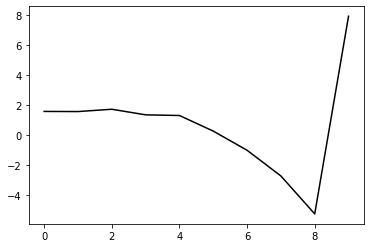

63800 25.7025382070049
1.4400989523550554 -0.7001263176829666 0.39432534295412625 0.276627420149377
[ 1.51539585  1.65736438  1.81222049  1.44471533  1.40106332  0.35958922
 -0.92600896 -2.66819162 -5.26280302  7.8557155 ]


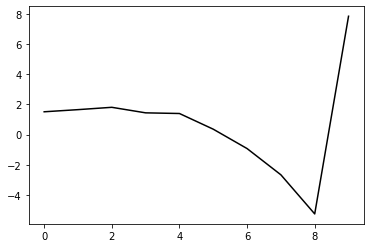

64900 56.61683657698216
1.444335205219482 -0.7019270757445645 0.4041905918855358 0.26689577928198266
[ 1.46752363  1.73400894  1.90170852  1.55332752  1.52891946  0.51390841
 -0.74311841 -2.45928892 -5.0543268   7.88760745]


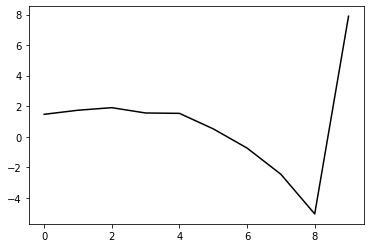

66000 14.816368169741738
1.381350423261987 -0.6946823369774988 0.38662267664966776 0.27077268926541254
[ 1.53428778  1.65576913  1.77863759  1.38837087  1.31830288  0.25844619
 -1.05142324 -2.83974849 -5.55836707  7.83688319]


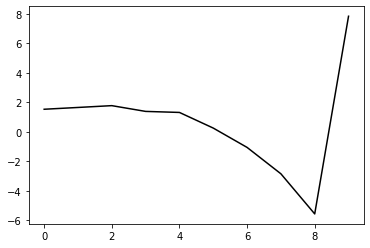

67100 20.852039892489575
1.3782104145993015 -0.7007564340776747 0.39272230645913714 0.2772227805984499
[ 1.53673257  1.68615698  1.82912219  1.46135731  1.40964107  0.36985632
 -0.92430981 -2.70549724 -5.43725345  7.87596124]


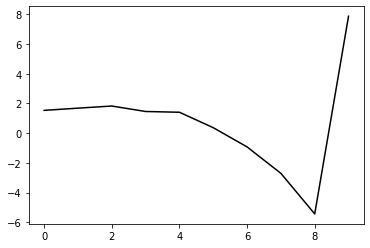

68200 16.98902944815045
1.3843033602200103 -0.6851953681784125 0.3911996100577897 0.272474185044107
[ 1.55878889  1.70061139  1.85075223  1.4984438   1.46507695  0.45336626
 -0.80866783 -2.56221034 -5.31430098  7.92989291]


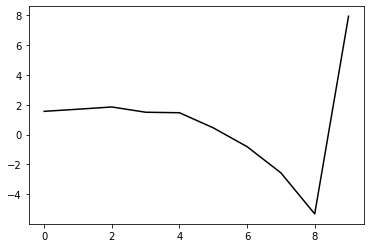

69300 15.380202846922034
1.4104892764471477 -0.64069766048738 0.3757198543364879 0.25496612176504085
[ 1.56121851  1.70915176  1.84396061  1.48035226  1.43334154  0.41240491
 -0.86190274 -2.63973553 -5.45666432  7.84842323]


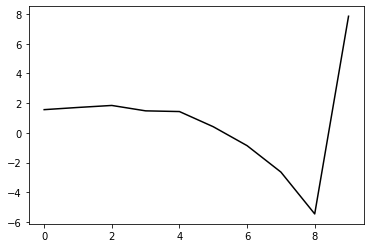

70400 23.59283349181228
1.3292659839804304 -0.6923209723647007 0.3978039617952433 0.2570682945509894
[ 1.57762365  1.70287034  1.84524068  1.49082239  1.44784563  0.43053169
 -0.84809463 -2.64509442 -5.51416379  7.90779001]


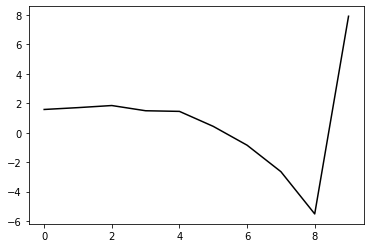

71500 20.936206657429107
1.341563803560011 -0.6690072574327531 0.3818455538907433 0.266890547208376
[ 1.60413592  1.72637062  1.8604103   1.50173085  1.4519878   0.43211296
 -0.84984118 -2.65312583 -5.54313386  7.88113554]


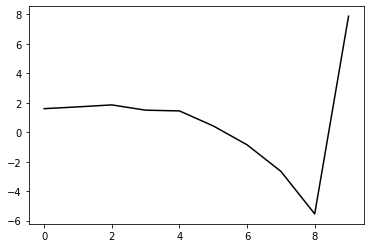

72600 22.083838883314584
1.3316167362535076 -0.6631267789332171 0.3831584345567611 0.26447620392694327
[ 1.60634774  1.75863292  1.89667237  1.54719194  1.50606276  0.49941494
 -0.77358361 -2.58549041 -5.52760547  7.83232371]


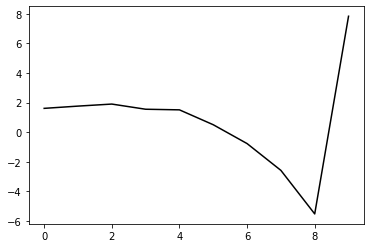

73700 15.510303634940872
1.320412165562594 -0.6475248927144772 0.3772688125418006 0.2556805360184529
[ 1.60805906  1.76810945  1.89577137  1.53863477  1.48646714  0.47111353
 -0.816267   -2.65715068 -5.66122856  7.83205018]


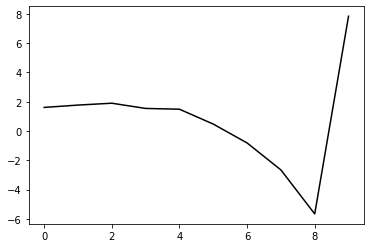

74800 22.63923618213271
1.3355744269859997 -0.6523734126164044 0.3827113263933922 0.27169310064899926
[ 1.67198066  1.78942368  1.95135384  1.63654953  1.62977299  0.66861006
 -0.56025434 -2.3411027  -5.29727003  7.83455921]


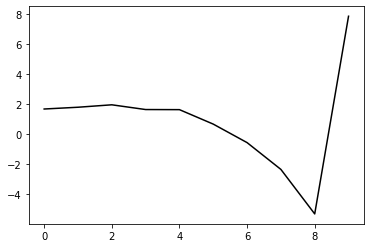

75900 15.405087536966969
1.2891977639951548 -0.6376486243782397 0.3763531963538827 0.2551508498183133
[ 1.61605211  1.79696043  1.9207515   1.56906841  1.52065057  0.51690353
 -0.7677945  -2.63404934 -5.72932031  7.85600777]


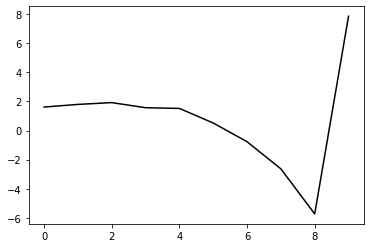

77000 12.988165718045733
1.29210226926738 -0.6450604015606788 0.3822689992134886 0.2613619735601936
[ 1.61552231  1.85500702  1.98709576  1.64615833  1.60637936  0.6136536
 -0.66095873 -2.5177381  -5.60582097  7.84022683]


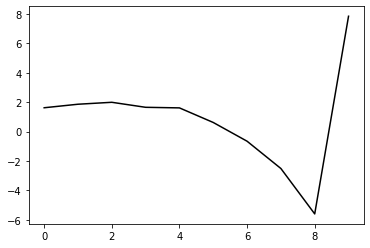

78100 27.03100334729497
1.2261889855456094 -0.6661211052388544 0.3884308030912914 0.2657596349007759
[ 1.69069364  1.75930978  1.89581051  1.56152561  1.52457732  0.53564812
 -0.74302436 -2.62172541 -5.77270492  7.74738619]


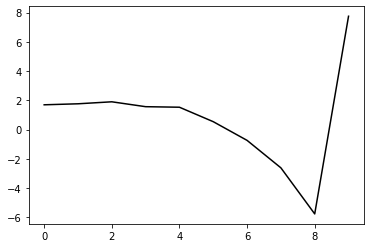

79200 22.399954528137183
1.2467238433517145 -0.6592733668909072 0.3959626777262111 0.24743340176115564
[ 1.57169446  1.93111428  2.06438751  1.72922389  1.68785976  0.69644206
 -0.58882351 -2.48349786 -5.67794662  7.8693207 ]


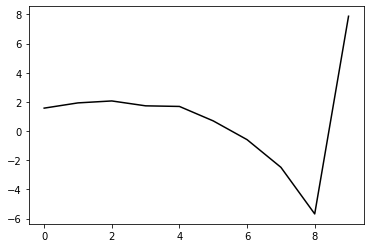

80300 14.128422121940929
1.2812665321161265 -0.6252459255165035 0.3796631248414201 0.26017284325420936
[ 1.62995093  1.92606793  2.07231863  1.75705135  1.73829751  0.77839036
 -0.47053264 -2.32516405 -5.47955326  7.83442553]


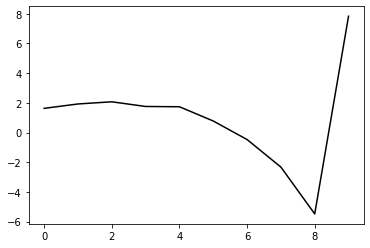

81400 22.39360160064854
1.2475136258316628 -0.6364144478961707 0.38592500283992487 0.25316452324483757
[ 1.6023033   1.95789626  2.09002704  1.76119541  1.72327008  0.7437814
 -0.53300396 -2.43084904 -5.66084597  7.81876075]


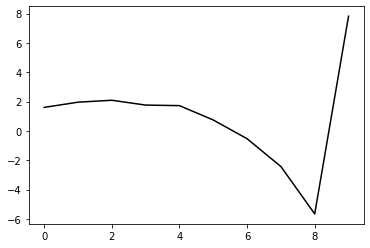

82500 22.20812962213324
1.2808571012545544 -0.6190589237270092 0.3835523962777586 0.2575549733695024
[ 1.59717125  2.01670399  2.17108339  1.86652246  1.85041235  0.89679236
 -0.3535452  -2.22369514 -5.42689533  7.86819776]


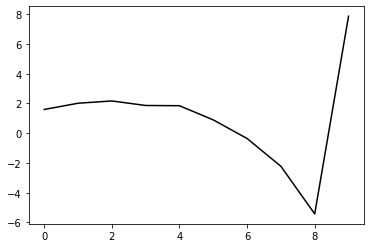

83600 98.7458013135368
1.2683744327714712 -0.6316204826513273 0.409400520402429 0.21405703516568178
[ 1.34096343  2.22691301  2.3499487   2.010504    1.94694578  0.93881429
 -0.38594697 -2.36723068 -5.76112175  7.82896522]


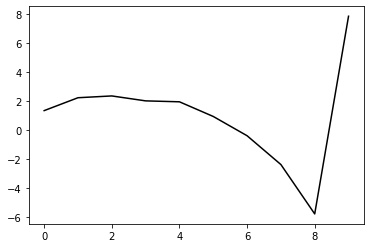

84700 89.97383475799677
1.2249604516439285 -0.66865344684999 0.4359543579195027 0.20092484622978304
[ 1.42897235  2.12393809  2.26056848  1.93179805  1.87191222  0.86983325
 -0.45238732 -2.43360759 -5.82995805  7.88667015]


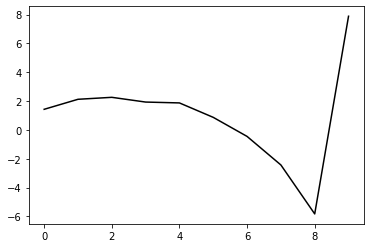

85800 25.55598756897226
1.223819344638348 -0.6023613915832191 0.38500497690598884 0.2455607038519633
[ 1.73055011  1.85257409  1.9809929   1.65021083  1.589252    0.59399439
 -0.72093862 -2.70228762 -6.12879586  7.76866881]


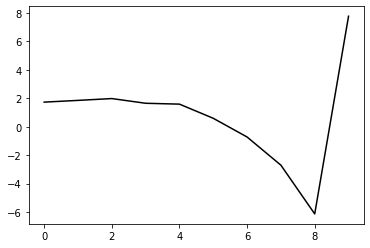

86900 20.14695954553453
1.272887062858435 -0.5967733753622324 0.393129364257752 0.2530516079903347
[ 1.60331829  2.13238668  2.28136521  1.97281479  1.93082685  0.95591202
 -0.34113576 -2.30930884 -5.74771856  7.82849331]


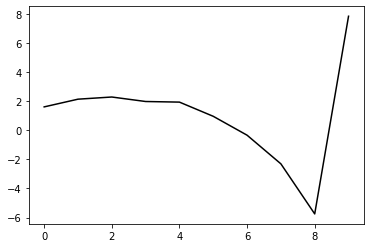

88000 13.869884019263683
1.253546596147894 -0.5735019988212263 0.380806958719953 0.25427901289193844
[ 1.66718542  2.06079185  2.18086184  1.84453195  1.77123564  0.76811807
 -0.56163057 -2.57196987 -6.05618936  7.80287649]


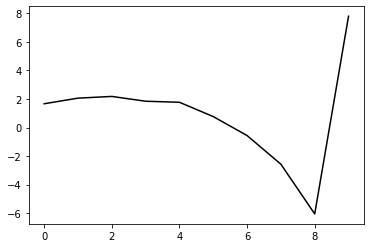

89100 25.484963190045104
1.2207829406402024 -0.5947637773345676 0.38678603991367655 0.26808783684140575
[ 1.67570791  2.08934022  2.2129785   1.87899726  1.80126705  0.79165976
 -0.55258558 -2.5880871  -6.1159351   7.70045423]


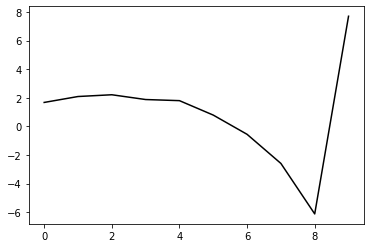

90200 22.00395288568344
1.1788425857654001 -0.6074144416855095 0.399554761964146 0.25494661581978917
[ 1.69481605  2.05797651  2.18325661  1.85562861  1.78498639  0.78858617
 -0.54388189 -2.57844777 -6.13782747  7.71201934]


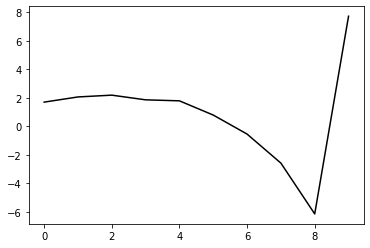

91300 19.612120796994255
1.194546285788869 -0.6025361622887861 0.4016555657166861 0.25689605054039594
[ 1.70919836  2.09741242  2.23147956  1.91473636  1.8527303   0.86812972
 -0.45437488 -2.48295182 -6.04636253  7.79165445]


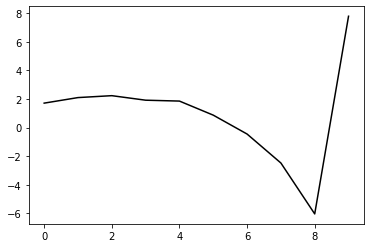

92400 24.536279256038007
1.1792118164781533 -0.6202844607298763 0.4148250787527395 0.254520278544575
[ 1.65131429  2.18676438  2.33021463  2.02616681  1.97454389  1.00387752
 -0.30819074 -2.33454207 -5.91655576  7.81214323]


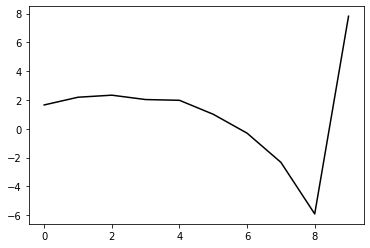

93500 20.56867278446981
1.204933255963404 -0.5728489942926194 0.3836097399325681 0.2656430798464094
[ 1.66588689  2.2453413   2.35547645  2.0194461   1.93299016  0.93036591
 -0.41757519 -2.49118902 -6.14851864  7.71176403]


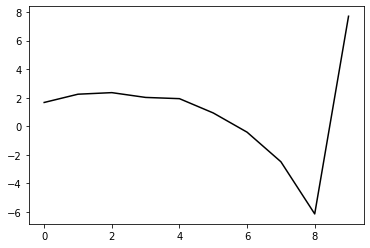

94600 22.415997727638707
1.2107674397512365 -0.5830794068039173 0.3970394784547026 0.2686343069180106
[ 1.61144007  2.35511758  2.48890008  2.17723406  2.11282831  1.13547348
 -0.1881431  -2.2400324  -5.88685102  7.86272417]


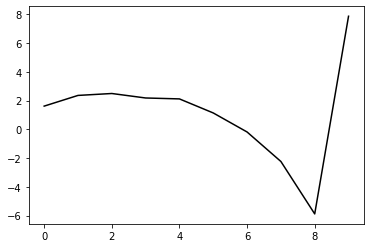

95700 11.848292232599958
1.246016213702773 -0.5478708529838022 0.38723077354091523 0.2608796186498555
[ 1.63955873  2.34441681  2.49396343  2.20521816  2.16741952  1.22739124
 -0.05465338 -2.06695455 -5.69802685  7.8107706 ]


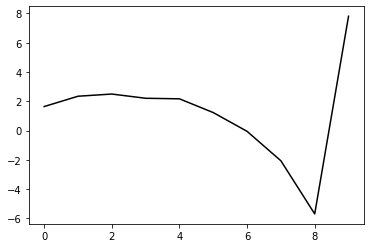

96800 19.289207315576007
1.211640026966931 -0.5563894273998926 0.39077986770675305 0.2571364490114938
[ 1.65882632  2.30416627  2.43400998  2.12333241  2.05533532  1.08286169
 -0.24467609 -2.32494404 -6.05360327  7.78171437]


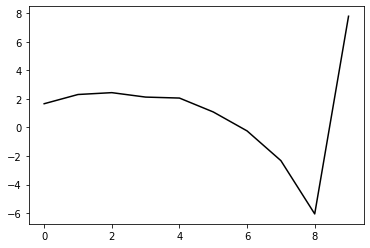

97900 38.011810796193224
1.2116602044374458 -0.562357640653085 0.40142273284589947 0.2519189074634735
[ 1.59485892  2.38019051  2.53137043  2.24725785  2.20579847  1.26516357
 -0.03506057 -2.10149063 -5.8487279   7.76418495]


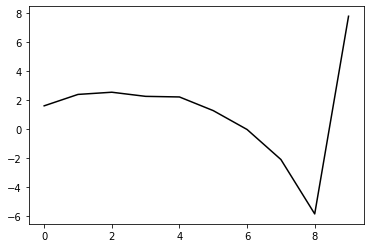

99000 41.968123564815095
1.163649897114926 -0.561062523758655 0.3894851578715678 0.2677589773898472
[ 1.83174445  2.11013957  2.26249076  1.98128732  1.93909009  1.00247094
 -0.29562636 -2.36447453 -6.12249233  7.81076895]


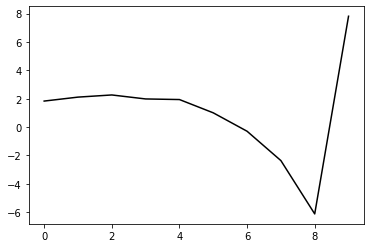

100100 20.546780334560967
1.1261574899754312 -0.5840173240971306 0.4124914258108334 0.24723950020920693
[ 1.66680701  2.27450998  2.42082132  2.13594481  2.08636226  1.14263172
 -0.17568946 -2.2953324  -6.16638068  7.72163437]


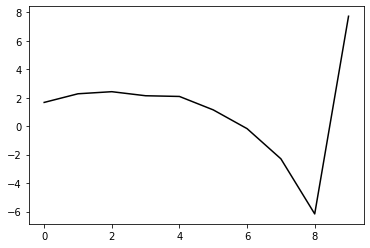

101200 57.61317821105459
1.1951302583072423 -0.518727638045594 0.37963641996568653 0.25459367461871585
[ 1.80223733  2.21207386  2.36731613  2.10057769  2.07645687  1.17273728
 -0.09623459 -2.16233999 -5.98609135  7.88661328]


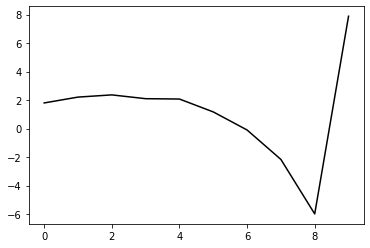

102300 18.516741651807184
1.1274547834321498 -0.5558664642226219 0.40512909903062533 0.23371242183764285
[ 1.66084732  2.33167191  2.46391096  2.17064253  2.11162826  1.16883525
 -0.15097842 -2.28715896 -6.22000609  7.78668532]


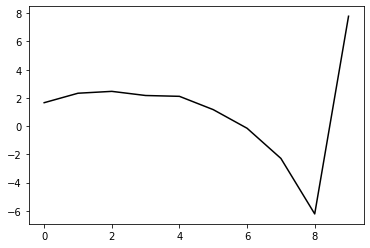

103400 18.89043157210913
1.1687030804424388 -0.5283380474663716 0.39312259812526323 0.24659965657312252
[ 1.67761969  2.38280412  2.53659749  2.26999005  2.23945586  1.33215073
  0.04955654 -2.05152927 -5.96283624  7.88400704]


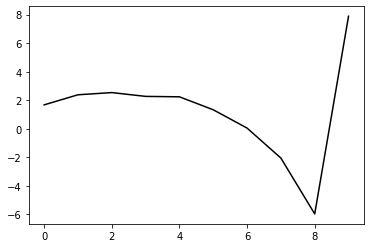

104500 22.40256871978872
1.1092681606521526 -0.5557357096016595 0.40258210884608503 0.2513860929336926
[ 1.73791781  2.3395541   2.48613543  2.2135564   2.17326883  1.25781107
 -0.03867383 -2.16380438 -6.11436156  7.72930308]


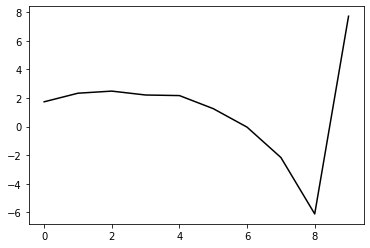

105600 54.80989384848088
1.081169296767243 -0.5750164778512432 0.4180788002180026 0.2364142046109016
[ 1.5948622   2.45731748  2.58333208  2.28726137  2.21414038  1.26235646
 -0.08305557 -2.27396855 -6.31438331  7.76159145]


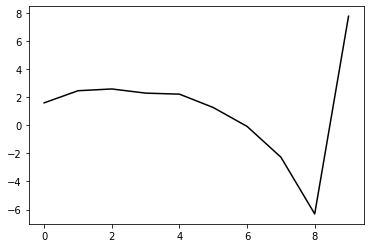

106700 15.815959148545899
1.1008245949433357 -0.5338033272643955 0.3902838343039276 0.2521956670020101
[ 1.7273507   2.36154255  2.48698247  2.19543465  2.1302396   1.19768276
 -0.12045256 -2.27660788 -6.27551234  7.76348414]


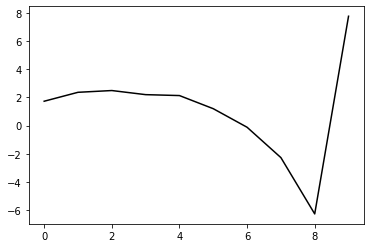

107800 19.152760620548623
1.1151896312923626 -0.529550739725289 0.39241416014007524 0.253360761204785
[ 1.72158221e+00  2.42703571e+00  2.56231416e+00  2.28204311e+00
  2.22601404e+00  1.30614931e+00 -2.60921314e-04 -2.14607527e+00
 -6.13672666e+00  7.77767730e+00]


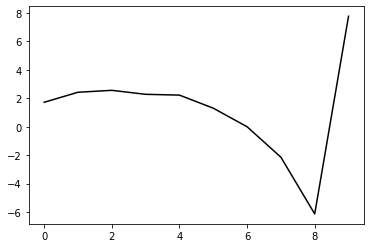

108900 26.974641081439703
1.1193390761380175 -0.5062575596209804 0.3766520756710303 0.26052785947464574
[ 1.70185993  2.46664528  2.58510794  2.2897862   2.21708814  1.28583176
 -0.03351809 -2.19868615 -6.22839875  7.71615354]


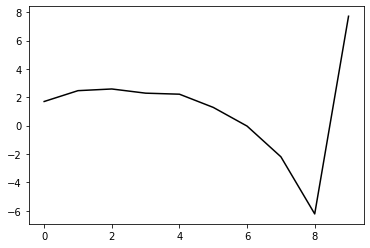

110000 12.527591603293182
1.087493794109374 -0.5330040032596237 0.39291511101478255 0.2608553716946536
[ 1.73279764  2.45855001  2.58679007  2.30253285  2.23884349  1.32062201
  0.01301647 -2.14285011 -6.16821537  7.82349836]


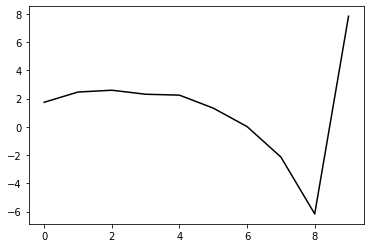

111100 25.643008411077563
1.0440391463377692 -0.5349468605192937 0.3920137233005014 0.25419345539552113
[ 1.7217112   2.38849294  2.49201893  2.1822434   2.08785761  1.14187821
 -0.20052137 -2.40745504 -6.5237663   7.63806471]


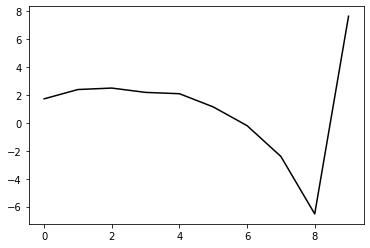

112200 21.73435657540773
1.0213720166913 -0.550991208959402 0.4036510526504574 0.2554525293718278
[ 1.73268928  2.39101658  2.51043617  2.21741935  2.13682756  1.21006065
 -0.11250809 -2.2968046  -6.38124618  7.70453702]


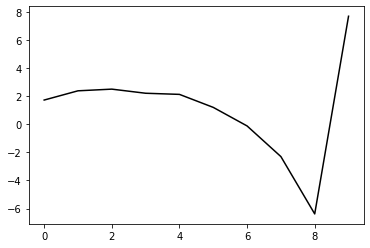

113300 15.854780929023939
1.0070984465888764 -0.560945749250515 0.4138457485988527 0.24734843626274355
[ 1.69061627  2.4696419   2.58007173  2.27543123  2.17595959  1.23076384
 -0.11399198 -2.32304685 -6.43513486  7.7431041 ]


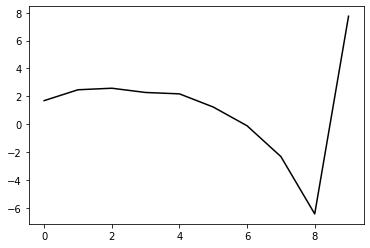

114400 24.99151285775789
1.025672517721352 -0.5319922007403821 0.39995864362026634 0.2440366562527276
[ 1.68195335  2.49431926  2.60239618  2.30228074  2.21207521  1.28643324
 -0.04485341 -2.26582339 -6.43845635  7.72133667]


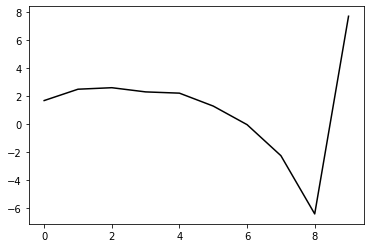

115500 22.336247304688136
1.0374681239544588 -0.5228521082080632 0.39658827213473963 0.25068039277879633
[ 1.69832087  2.51055704  2.63614893  2.35602906  2.28535788  1.38405807
  0.07571493 -2.12745183 -6.29382801  7.68107243]


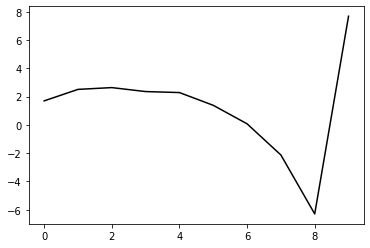

116600 21.799784411252578
1.051822738810126 -0.5123977085300802 0.3935096168246481 0.2530023519640528
[ 1.7335924   2.52548785  2.65927357  2.39061603  2.33152031  1.44892094
  0.15988633 -2.02650389 -6.18429621  7.75887074]


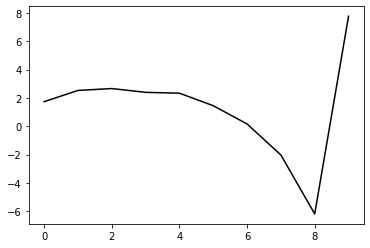

117700 15.008262691916261
1.041197080192582 -0.5014031464521378 0.39397316118707143 0.23114047082859449
[ 1.67421716  2.49819276  2.61954563  2.34097828  2.27089725  1.38446355
  0.08695086 -2.12619678 -6.35870277  7.72522719]


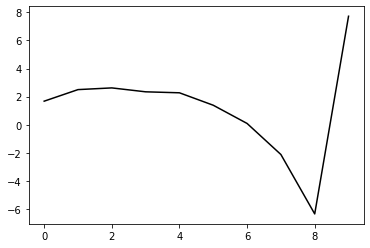

118800 27.18626420326949
1.059993972201821 -0.48271797019834595 0.3828589864959651 0.2468884892401758
[ 1.75295873  2.5569867   2.69904578  2.44320698  2.39396572  1.53164362
  0.25558353 -1.93820852 -6.14880985  7.80574772]


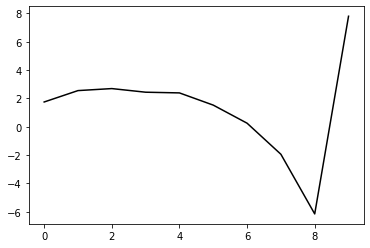

119900 53.48565679717217
1.011115730374891 -0.5292468403666034 0.4154452563986633 0.2322421990637987
[ 1.61035344  2.64432138  2.77304232  2.49860466  2.42137584  1.53013438
  0.21862474 -2.01796567 -6.28170142  7.7378496 ]


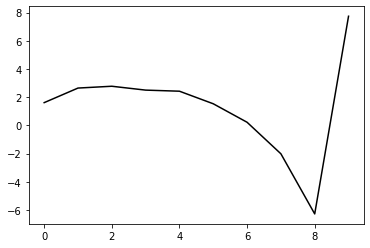

121000 40.69218933111529
1.0392104074341433 -0.4683383102466659 0.37643710891308024 0.25403415662188766
[ 1.801151    2.49942221  2.6159261   2.33312336  2.250713    1.36405905
  0.06164993 -2.1648449  -6.42276829  7.75609388]


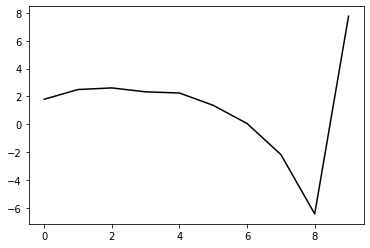

122100 26.07228243459952
0.9856958429376494 -0.5041610180540471 0.39485496165668976 0.2544770581031353
[ 1.76626541  2.52999666  2.64718285  2.36324608  2.27550528  1.38427213
  0.07370183 -2.16548595 -6.44487109  7.63158   ]


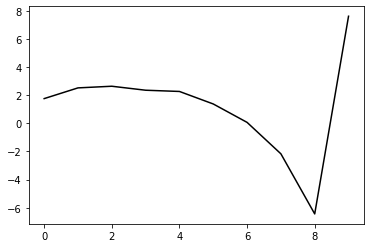

123200 19.204457252345904
0.975900223274073 -0.5045206677063284 0.4015656479863377 0.23536312993394948
[ 1.66573711  2.64631067  2.73086567  2.41308629  2.28870733  1.36443014
  0.01828841 -2.26381082 -6.60904958  7.69963695]


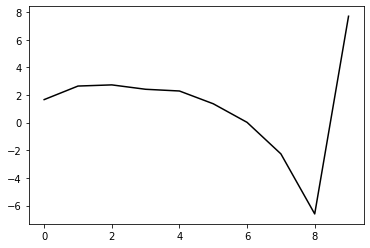

124300 17.929092914457925
0.9542990293774622 -0.5139453209298303 0.4026472393548571 0.2518767050438585
[ 1.69040568  2.64458464  2.74369739  2.43961923  2.32578247  1.41472548
  0.08040615 -2.19051088 -6.52145412  7.80467547]


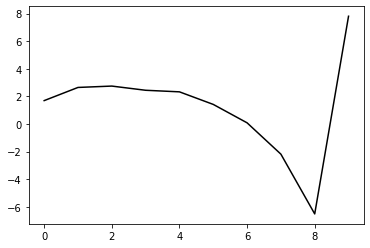

125400 38.28934069364547
0.9153493676842858 -0.4951501140213259 0.3818277915721538 0.26546225673326834
[ 1.78753533  2.53722205  2.61064129  2.27971456  2.13687937  1.20307752
 -0.15148671 -2.44157585 -6.79894834  7.62062495]


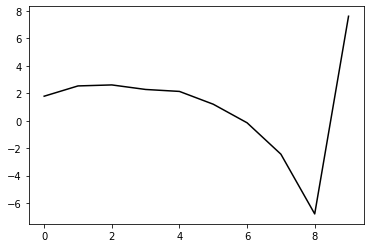

126500 25.798446024863818
0.9556881568453522 -0.4902119203647406 0.3989006525326979 0.2401432762792253
[ 1.73216853  2.60967202  2.70592978  2.40278836  2.29105837  1.39600742
  0.07976255 -2.18033417 -6.52440394  7.7437837 ]


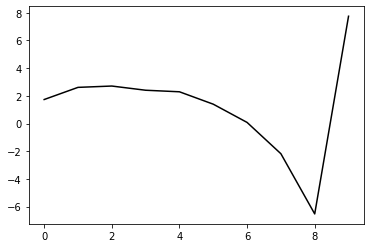

127600 20.895431883592746
0.9725562069855135 -0.48370671401079773 0.3967756531854842 0.2486615518690175
[ 1.71373513  2.7233108   2.83635078  2.54873309  2.44881671  1.56738584
  0.26203951 -1.98950282 -6.32761848  7.7293933 ]


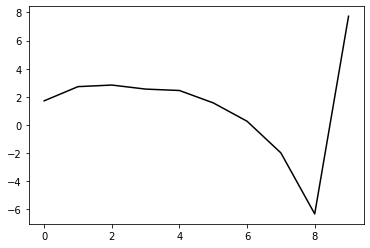

128700 18.346081308782896
0.9489358388548805 -0.4941584218814904 0.404713408212377 0.2424353539778204
[ 1.66956679  2.74710895  2.84875343  2.54568294  2.42398863  1.52116956
  0.18824921 -2.10193341 -6.50726807  7.66190449]


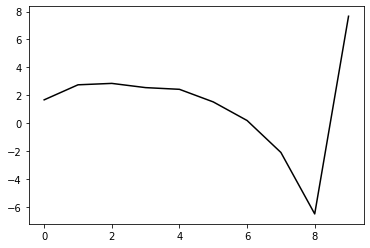

129800 38.93811479074737
0.9587244274168824 -0.4720409971879837 0.39110870556975963 0.2598585996309156
[ 1.8265707   2.67842821  2.81076762  2.54430959  2.46393498  1.61325373
  0.3358372  -1.90108332 -6.26143676  7.74443927]


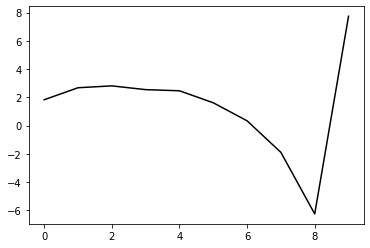

130900 16.622065444533494
0.9172543455125647 -0.48104016557211987 0.3994138027350703 0.23665866374060526
[ 1.66863065  2.70921852  2.7757758   2.43728607  2.28040917  1.36215212
  0.02228391 -2.27633177 -6.71547757  7.75028738]


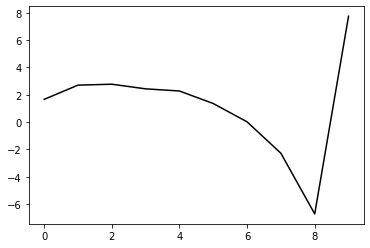

132000 16.503436647102387
0.9365111320469048 -0.4700754191927353 0.3971543927142925 0.2527653148099683
[ 1.79275475  2.69784276  2.82292741  2.54961852  2.4588584   1.60803435
  0.32653713 -1.92771296 -6.335252    7.79531836]


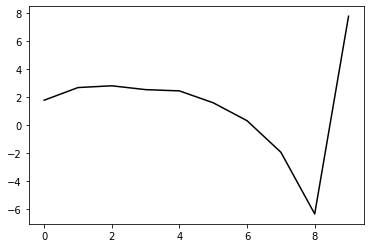

133100 31.657829883654077
0.9544278689013416 -0.45869366992540006 0.4017997794932875 0.23096009635941156
[ 1.62216138  2.86340123  2.96019848  2.65237217  2.51973975  1.63001493
  0.30885553 -1.98856432 -6.45247356  7.71733926]


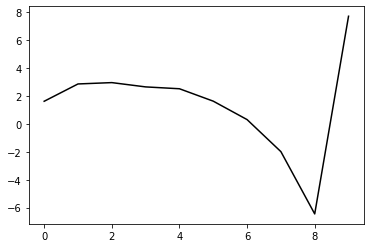

134200 17.905984187110313
0.9321017494022944 -0.47540585270108165 0.4102700290362214 0.2393987909764653
[ 1.69779627  2.82654251  2.95033365  2.66993551  2.56345946  1.70404503
  0.41178092 -1.85961466 -6.29926199  7.77864448]


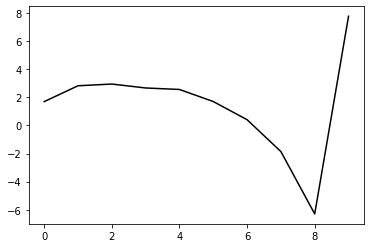

135300 38.722747564511074
0.9527769906734248 -0.44710926183700367 0.40347765305284805 0.22451583125957933
[ 1.61074556  2.90376962  3.00745711  2.70521225  2.57333771  1.69252423
  0.37538285 -1.93128887 -6.43733263  7.66828744]


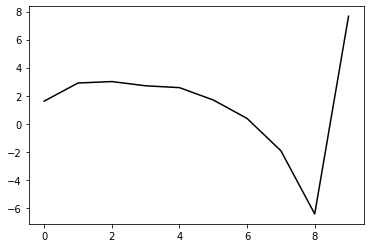

136400 26.43543328019988
0.8782640085822085 -0.48277929053121055 0.4053276333865269 0.2502497202395067
[ 1.76649723  2.75440394  2.86217769  2.56124574  2.4261585   1.54376379
  0.22319972 -2.08635451 -6.58759139  7.6831502 ]


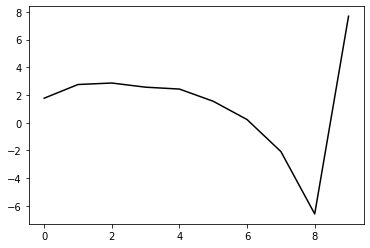

137500 23.0772651539627
0.9123688897399731 -0.46313090389428235 0.40171343730276315 0.25090841203288955
[ 1.79276711  2.80904171  2.94191784  2.66916474  2.56365905  1.71694149
  0.43039707 -1.85158199 -6.3362932   7.77972679]


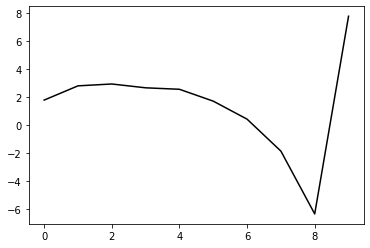

138600 22.381879790086355
0.900089081061616 -0.4541388362150893 0.39947170104794666 0.24443788193277788
[ 1.74065649  2.8746086   2.98498273  2.68650148  2.55069108  1.67515942
  0.35555696 -1.96834001 -6.51663286  7.65671055]


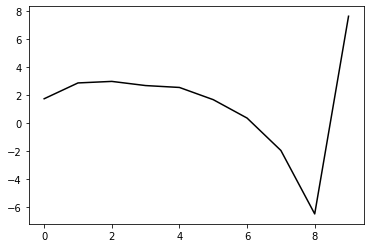

139700 30.374907203085513
0.8929971374209225 -0.4371039975831413 0.38552251542480526 0.25393790412374906
[ 1.78963389  2.80077942  2.8976771   2.58407918  2.43368833  1.55361528
  0.23464404 -2.08562712 -6.63019002  7.71525351]


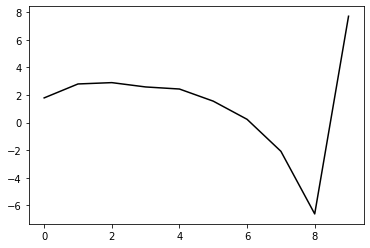

140800 17.96222338585829
0.9380649107556615 -0.4291922798399448 0.3944955262755092 0.24268988494485572
[ 1.73455686  2.94442624  3.07397647  2.78820123  2.65881736  1.79829653
  0.49155135 -1.82523015 -6.37986897  7.7488532 ]


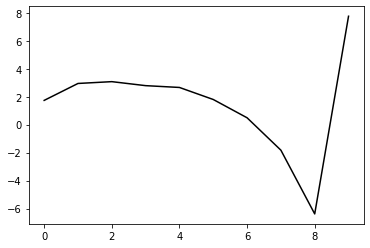

141900 20.782601161889108
0.8279724339892851 -0.4612717277161489 0.4041557220202445 0.24021328685106785
[ 1.74585613  2.72599802  2.80322449  2.45432464  2.25267941  1.32489541
 -0.04657969 -2.42531268 -7.05170021  7.61364947]


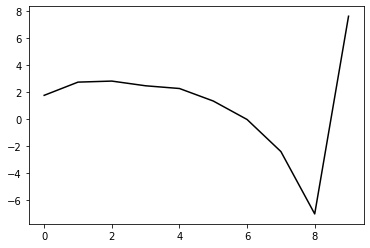

143000 11.688380536409287
0.9222810134780685 -0.43024021769021387 0.3990121402949914 0.2464067705552756
[ 1.75318247  2.98686492  3.1370912   2.86030663  2.72208585  1.84854477
  0.51453035 -1.84514312 -6.47157869  7.73097454]


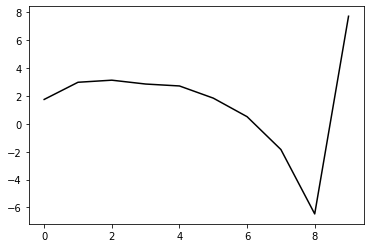

144100 22.601017535774393
0.9102331537589897 -0.43612972844410636 0.4056598868292175 0.24305548623884365
[ 1.68056557  3.10363201  3.23317453  2.92857058  2.75536023  1.84581011
  0.4719395  -1.93178887 -6.61088322  7.67097919]


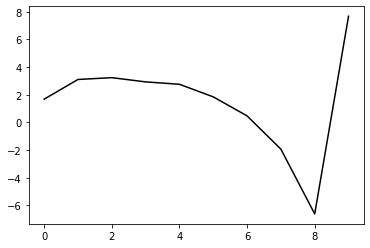

145200 23.78739995103519
0.9076673694302628 -0.4324219496384499 0.3995844253845794 0.25803474592424097
[ 1.7627765   3.08167007  3.22979915  2.94215833  2.78375739  1.89242555
  0.53493997 -1.85416797 -6.51898411  7.77296112]


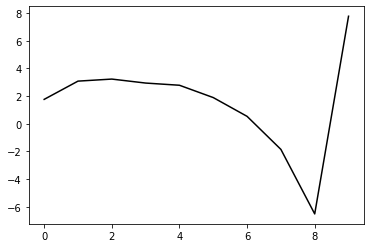

146300 16.335695473822717
0.8885524361255518 -0.44990191789606654 0.4125936812732644 0.24893474685760153
[ 1.68606522  3.11347073  3.25686586  2.95922869  2.78689389  1.88791252
  0.52361125 -1.8726922  -6.54737252  7.77750543]


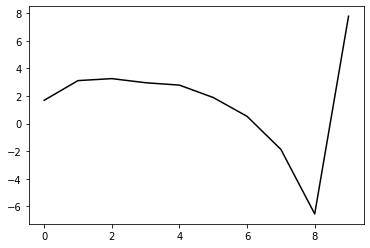

147400 24.384424151229986
0.8524503245896106 -0.4600451644755634 0.42338792864898805 0.23796253144996027
[ 1.70386346  3.03493191  3.16650331  2.85421627  2.66263918  1.74947759
  0.37146818 -2.04032722 -6.73553044  7.70518483]


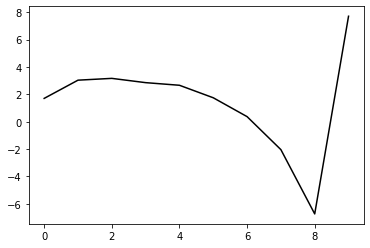

148500 24.903437143949485
0.843668232834022 -0.44373683297874894 0.41288387444073466 0.2379324878743592
[ 1.72723274  3.02048197  3.14259609  2.82036278  2.61860246  1.70261115
  0.32215274 -2.09757568 -6.81712807  7.65922154]


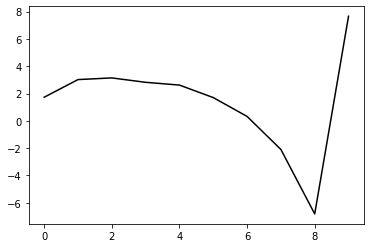

149600 19.213577540040706
0.8904806456986849 -0.4193985435996129 0.40317428929943033 0.25097498684465336
[ 1.75238798  3.11042031  3.27186117  2.98687588  2.81795275  1.93334355
  0.57688049 -1.82650747 -6.53731064  7.78678746]


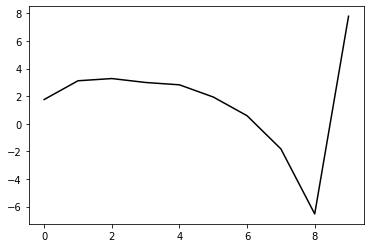

150700 15.666557733907705
0.8677362556698535 -0.4384156299103639 0.41865622183896917 0.2434105413064533
[ 1.72453475  3.08809866  3.26201057  2.99017667  2.83502875  1.97114274
  0.63407912 -1.75785184 -6.4750432   7.69833017]


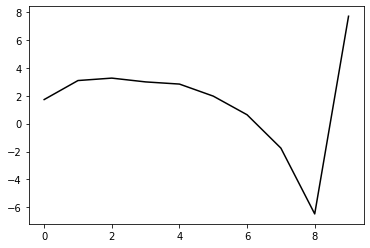

151800 19.011651559391524
0.8554674408596842 -0.4285586471740032 0.4142065536640693 0.24361746471390047
[ 1.81420017  2.94533954  3.13484594  2.88405302  2.75486429  1.9293232
  0.63359121 -1.72320473 -6.42778765  7.76277147]


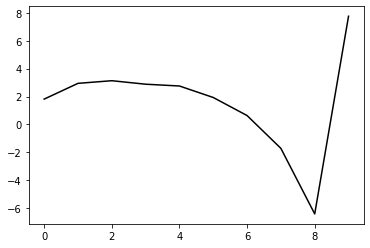

152900 70.79313853165218
0.8400302724974585 -0.46958859999499303 0.4524216405788707 0.20918627026972145
[ 1.67070443  2.99927657  3.14513753  2.83563888  2.63800945  1.75899041
  0.42878467 -1.94580715 -6.6644603   7.68148484]


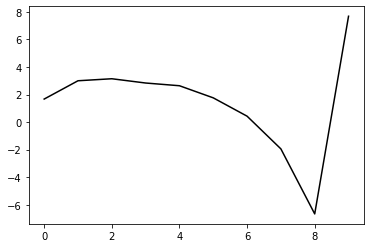

154000 65.34640957536993
0.854166198547162 -0.39521915756460135 0.39981035685485344 0.2532842265356247
[ 1.93179842  2.80742784  2.9788969   2.70428913  2.55156249  1.73579247
  0.47832764 -1.82515058 -6.49061587  7.70461353]


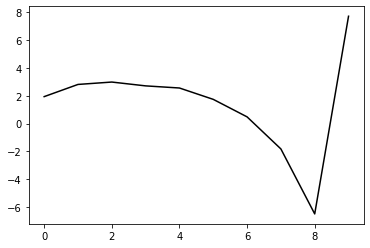

155100 19.681983900888394
0.813067641616899 -0.43515978279383427 0.42893746252660997 0.22438426997220404
[ 1.73403     2.90322438  3.0349974   2.7125636   2.50379978  1.63368368
  0.32119248 -2.03979633 -6.77597563  7.76293402]


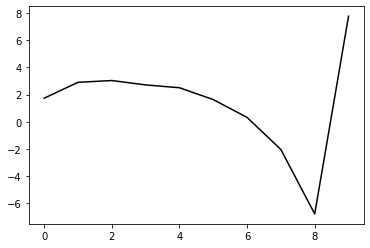

156200 20.275093533658715
0.840559037935855 -0.4156104302884043 0.42040912203428565 0.2348301225965096
[ 1.81649034  2.93113614  3.0863684   2.78907833  2.60481875  1.76277149
  0.47578893 -1.86407952 -6.58095496  7.72421735]


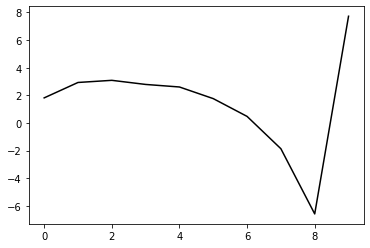

157300 17.075827807355076
0.8063924541090953 -0.42001865915625075 0.43043621248101194 0.2188420999001016
[ 1.76609643  2.8525708   2.9842076   2.66490462  2.46226734  1.61474531
  0.32890392 -2.01283513 -6.75614241  7.68542361]


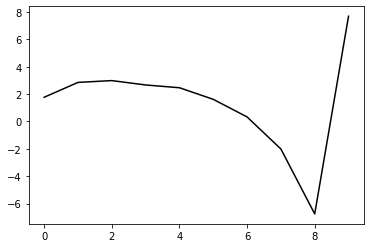

158400 24.05837373401906
0.8226374930255707 -0.4126845953562849 0.4289136441461333 0.22821145009651636
[ 1.73851222  2.98437743  3.11813423  2.79855864  2.59235632  1.74333611
  0.45454536 -1.89193647 -6.64263438  7.6849837 ]


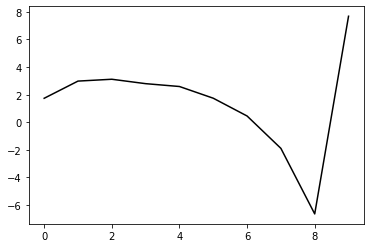

159500 42.664354980316475
0.8435674839765253 -0.39251912947271606 0.4142647960818182 0.254995239483481
[ 1.85676893  3.00925311  3.18299592  2.90383128  2.73696308  1.93056802
  0.68364633 -1.62103241 -6.32570805  7.83362124]


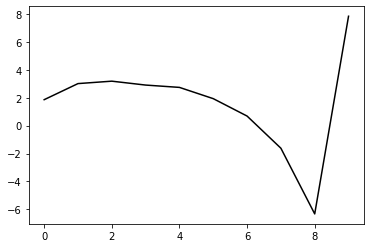

160600 20.471141540297626
0.8600917106598662 -0.37508609707521845 0.4101127212537511 0.24202248235674254
[ 1.75995288  3.06516924  3.18493001  2.85169428  2.63748089  1.80210949
  0.53838877 -1.7775721  -6.4948981   7.73339272]


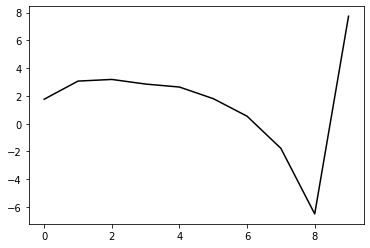

161700 21.274805886780516
0.7928887840767933 -0.419423778619414 0.4326903320303156 0.23872269939319524
[ 1.81851775  2.91176529  3.02507196  2.678645    2.4451196   1.59148109
  0.30771608 -2.02905315 -6.76802843  7.71186165]


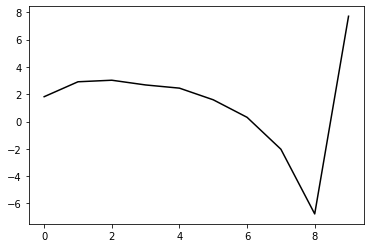

162800 23.92055504849385
0.7896018474515369 -0.413577636261019 0.428337416719806 0.25195655072956064
[ 1.81200378  2.97729278  3.1164711   2.79368081  2.5813973   1.75207031
  0.49083588 -1.82770157 -6.55223997  7.64747265]


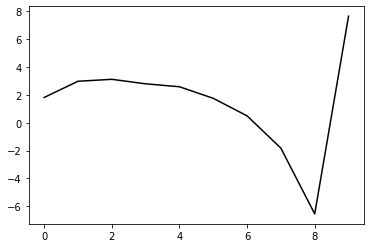

163900 19.444680567657823
0.7612107523218379 -0.418675940484639 0.4325500752576531 0.24570445703615143
[ 1.84373808  2.82012453  2.91342084  2.54501405  2.29394079  1.44443116
  0.17826177 -2.1354077  -6.85855907  7.68830779]


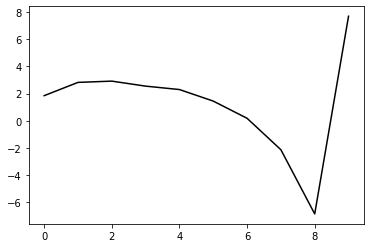

165000 11.835200377944048
0.8194110515362462 -0.39013385901868475 0.42607058297999284 0.2462174229371985
[ 1.77056839  3.05310767  3.18040207  2.84626534  2.62729755  1.81125243
  0.57339929 -1.72111007 -6.43774655  7.74586567]


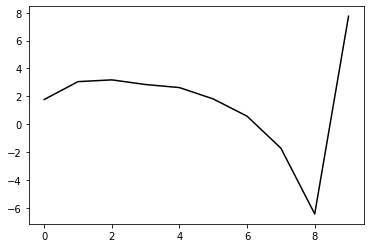

166100 29.877107867873754
0.7987031468284518 -0.3778090854351431 0.4117727682173263 0.2541945810908021
[ 1.78607034  3.00017262  3.09629997  2.72642624  2.4690866   1.6206649
  0.3530161  -1.97081567 -6.72604317  7.6622075 ]


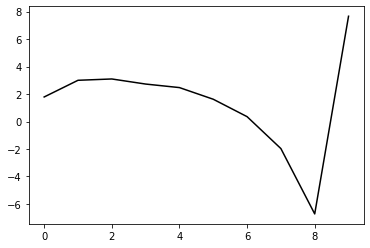

167200 21.752819437942545
0.7643032626950945 -0.40469812999101523 0.4304201553936943 0.2381517490273034
[ 1.73361593  3.03463777  3.0990535   2.69337986  2.39783438  1.51650849
  0.21788255 -2.13672739 -6.92792343  7.6851885 ]


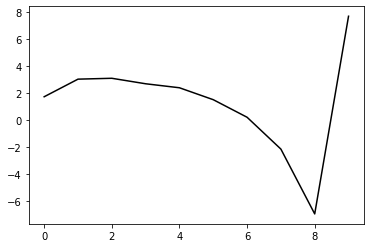

168300 39.04499463207546
0.8185336456013829 -0.3697820241690707 0.413274674806229 0.2579955707056448
[ 1.8489644   3.08163098  3.21156528  2.86876814  2.63082233  1.80372619
  0.55018005 -1.76976979 -6.5319978   7.68693694]


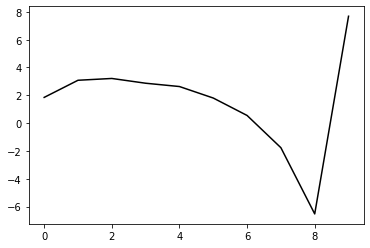

169400 25.20697245056899
0.7865729189655956 -0.40205314723318814 0.4335681938112325 0.24758415633939468
[ 1.77266394  3.09134055  3.19687405  2.82565659  2.55916642  1.71258511
  0.44439867 -1.88661862 -6.65532997  7.73879369]


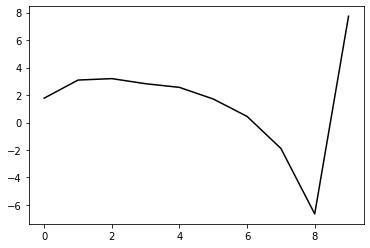

170500 23.06942888320278
0.785166029565614 -0.37996124234843076 0.4202568309931885 0.24288624461661007
[ 1.77237547  3.03060165  3.12430042  2.74645794  2.47898881  1.6429302
  0.38675119 -1.93949241 -6.72312096  7.69739984]


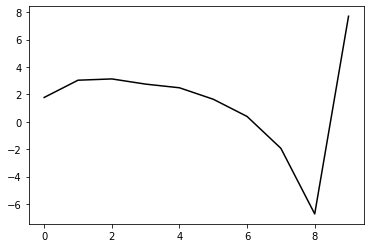

171600 21.12776436305304
0.786424938892551 -0.3940277683688259 0.43610247187175544 0.23894278277521613
[ 1.76637016  3.09770647  3.23748263  2.90000661  2.66451861  1.85662542
  0.61970253 -1.69603457 -6.47784229  7.73155678]


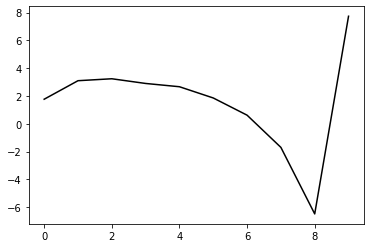

172700 17.03942599843698
0.7886645007785048 -0.38022376443561995 0.4298301076523841 0.22916960735945932
[ 1.72512996  3.11049782  3.18518545  2.77628624  2.47070533  1.61080921
  0.338654   -2.00233255 -6.81481725  7.61078918]


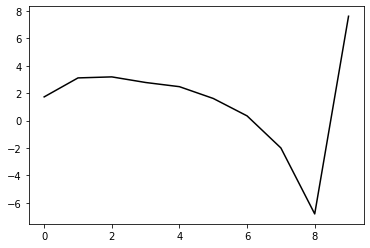

173800 25.224416146868325
0.766602950840697 -0.38539926096322324 0.4273740984992918 0.24905303470577952
[ 1.7602805   3.10434429  3.1986415   2.798593    2.4903145   1.62338158
  0.33965543 -2.01400368 -6.83864127  7.65133698]


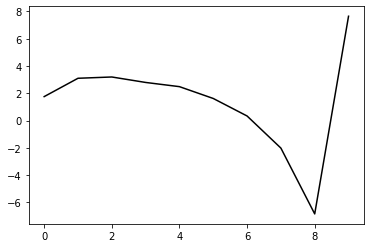

174900 12.963431450052235
0.7832860536742373 -0.38597915232861 0.43301249186588925 0.24910757409888895
[ 1.77282693  3.17800878  3.30776066  2.94277873  2.66743949  1.83465009
  0.57942897 -1.75447505 -6.57175617  7.72968464]


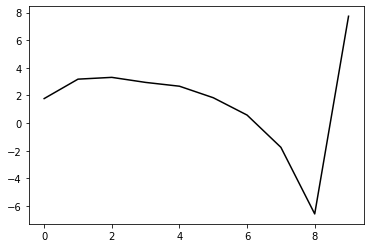

176000 14.3707084899191
0.7839695639741836 -0.38467022666294065 0.4347335732191495 0.24792366763249504
[ 1.72928572  3.25108435  3.39220739  3.03782351  2.77263067  1.95593841
  0.71567584 -1.61008216 -6.44131189  7.73197129]


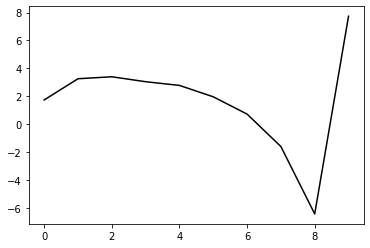

177100 20.49173029840288
0.7934888845077017 -0.36376041027514966 0.42849372116961404 0.23656715188467847
[ 1.7344534   3.22932479  3.33503399  2.94394657  2.64393295  1.80242131
  0.54173027 -1.80591326 -6.66861121  7.66729817]


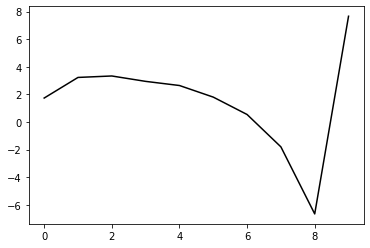

178200 20.6630220348761
0.741341599773461 -0.39158291363248393 0.4399961642158407 0.2356218954601464
[ 1.74419041  3.12873706  3.20541269  2.78495127  2.45968124  1.60393685
  0.33453553 -2.01992253 -6.89372245  7.71991771]


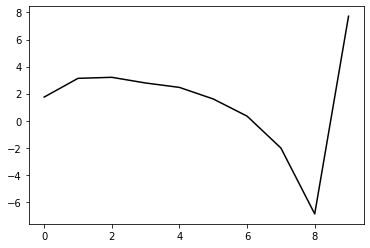

179300 15.36100877109858
0.7456431212670872 -0.3954385909568712 0.4453229671787966 0.23582410813971377
[ 1.73711651  3.17472985  3.25326812  2.8322907   2.50868596  1.66470163
  0.41090112 -1.92853246 -6.78686853  7.68786731]


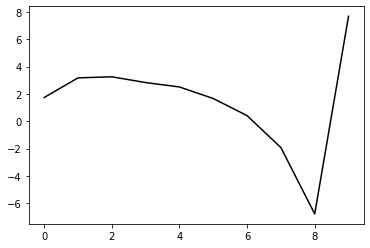

180400 47.1886515980625
0.7875240919145933 -0.35017269193282613 0.4215171272624321 0.25382499292222904
[ 1.87126911  3.17324202  3.33159993  2.99234431  2.74428435  1.9679289
  0.76401134 -1.54572057 -6.40071433  7.73990607]


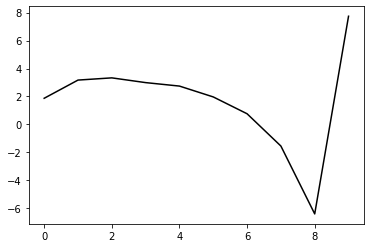

181500 41.0011788674526
0.7814422886505159 -0.35593215426367114 0.4238163342328407 0.25770628809759666
[ 1.83497691  3.27856024  3.42316893  3.06038989  2.78568337  1.99354885
  0.78264884 -1.52782162 -6.37780163  7.67091624]


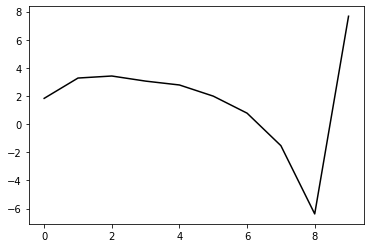

182600 22.571826203050744
0.7579667502865268 -0.3745048027702881 0.43512810097484295 0.25522570919096293
[ 1.78627464  3.25219178  3.36483594  2.96746064  2.66502377  1.86339533
  0.65386832 -1.65163192 -6.4964365   7.68299213]


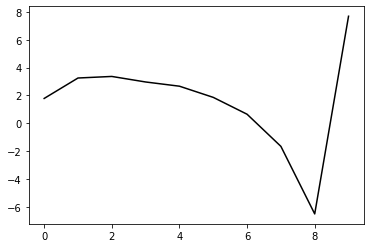

183700 12.666292193376776
0.7848948110785523 -0.34791746921232136 0.42889579167012426 0.24018395340953716
[ 1.71695368  3.31846655  3.42224917  3.01658985  2.70849683  1.91090129
  0.70784502 -1.59697784 -6.46377435  7.72729352]


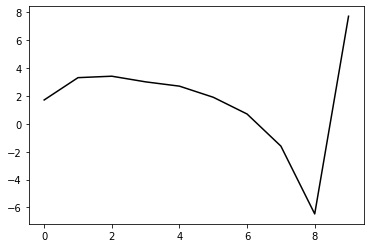

184800 20.06424588494106
0.7635953098675279 -0.35563883948191644 0.4312119946094357 0.23764451529890573
[ 1.73787007  3.26524953  3.36135568  2.94347337  2.61939795  1.80846935
  0.59092718 -1.73093879 -6.62125636  7.65454255]


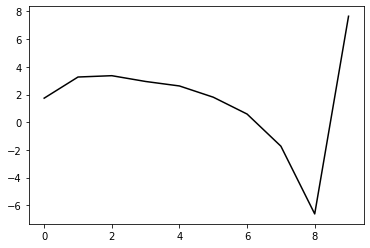

185900 47.57836446058045
0.7774602101813817 -0.3588573043102758 0.44272244420004164 0.22650316985751598
[ 1.63772323  3.34040566  3.42884682  2.99650664  2.65820531  1.844375
  0.62955076 -1.69077225 -6.59317121  7.73502561]


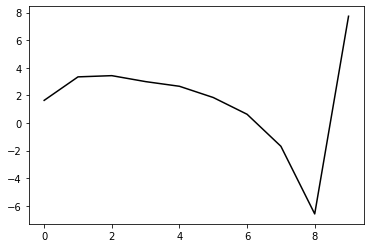

187000 72.85872943048767
0.7555410728076956 -0.3954998531837503 0.47231971362279035 0.20161828518234415
[ 1.66145458  3.13731649  3.23030257  2.80176079  2.46980071  1.66961255
  0.46912318 -1.8390095  -6.73194429  7.70987377]


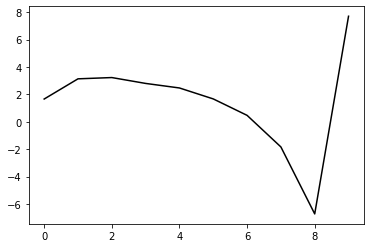

188100 34.3284254697484
0.7909749825900461 -0.3451691155031335 0.44008856522832945 0.23039132433119636
[ 1.69211471  3.32698252  3.46304149  3.07358141  2.7735315   2.00230516
  0.8224764  -1.47611946 -6.37579718  7.81003904]


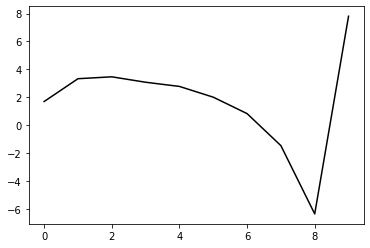

189200 15.85295768034848
0.7706889929228476 -0.3360316940545046 0.43132905498991336 0.2378644651642733
[ 1.79050659  3.21625227  3.35586339  2.9707364   2.67609122  1.91720003
  0.75056208 -1.53872365 -6.43879631  7.73964116]


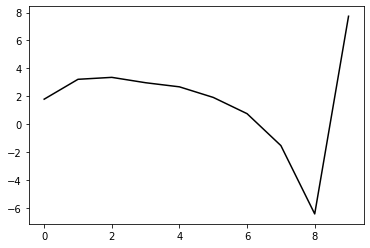

190300 16.273281854381544
0.7270108852689382 -0.37384663259590234 0.4512606241890037 0.23305822582778857
[ 1.79378559  3.11519767  3.24400063  2.84295053  2.52741651  1.75038299
  0.56537868 -1.74284779 -6.66531882  7.6870924 ]


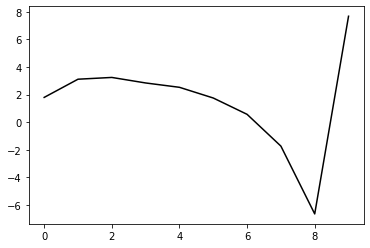

191400 21.68227182480884
0.7743777912871163 -0.3364948874051357 0.4339108478338944 0.24016669713168265
[ 1.81146464  3.24873079  3.41120236  3.04228496  2.75591915  2.01032083
  0.85281864 -1.4364879  -6.36046904  7.82216108]


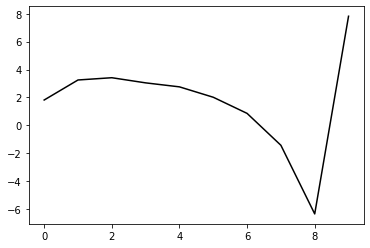

192500 26.046145873888648
0.753315134532202 -0.35372546432394875 0.44669946989457693 0.2326394851148098
[ 1.72921416  3.27235046  3.40576689  2.9970637   2.66133406  1.86584884
  0.65708941 -1.68499843 -6.66184063  7.72561995]


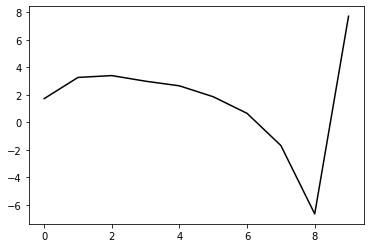

193600 22.377205421740822
0.7344415038886587 -0.3537327675325694 0.444496183708617 0.23972940594688358
[ 1.80497837  3.24010265  3.38384656  2.98393178  2.65507177  1.86981461
  0.67018594 -1.66787898 -6.65139865  7.67948583]


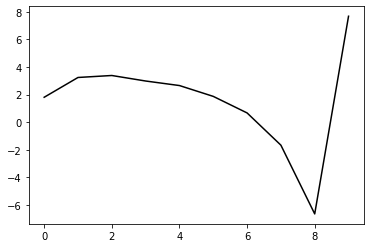

194700 35.32849251516641
0.7813964260010008 -0.2952236194939873 0.4164411426015406 0.23581977893236897
[ 1.84770692  3.25939635  3.3809503   2.95691632  2.60759474  1.81542029
  0.61620613 -1.72322048 -6.72582988  7.72760738]


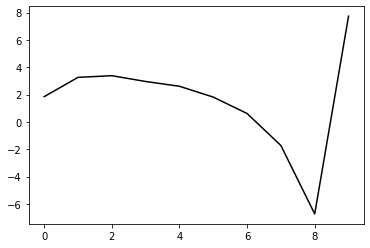

195800 32.31810251326922
0.6850827361804751 -0.34406843577464036 0.428844192412371 0.24793133671479373
[ 1.88676308  3.0746555   3.16838065  2.70973053  2.32165378  1.49513898
  0.26672438 -2.09411767 -7.11016491  7.62722275]


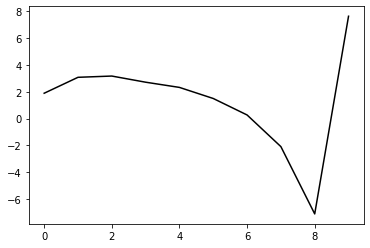

196900 16.581572990115447
0.6958729579161085 -0.3576202034776838 0.44400379309219945 0.24332012416111556
[ 1.79854519  3.16962467  3.27024699  2.81808748  2.43712315  1.62296281
  0.40820957 -1.94177292 -6.95341597  7.67114349]


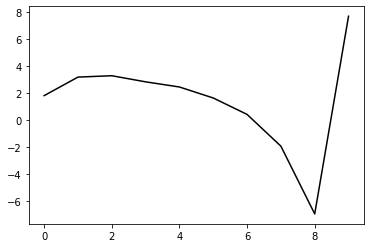

198000 21.84987962258301
0.7253144568415477 -0.3373734566857889 0.4363127341060791 0.24856616079034122
[ 1.8722182   3.19958169  3.32297255  2.89312948  2.53471962  1.7476031
  0.55977735 -1.76694836 -6.76395576  7.65299135]


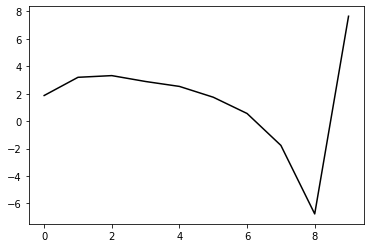

199100 21.254787148421986
0.7558827188045162 -0.31544830417990627 0.43382967140734097 0.23890680339818168
[ 1.78357832  3.38389738  3.52092756  3.10201555  2.75139709  1.97164836
  0.78508279 -1.55163425 -6.58131512  7.71768695]


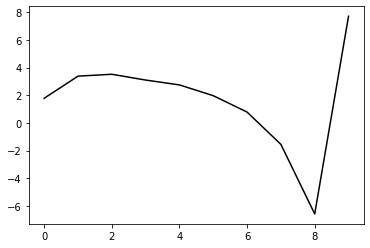

200200 14.167433661762246
0.7436166916998539 -0.3322381769551852 0.4475674966796401 0.23480208065675806
[ 1.77276716  3.31778473  3.48462465  3.09640523  2.77695981  2.03213507
  0.87706879 -1.43759842 -6.46395694  7.72460829]


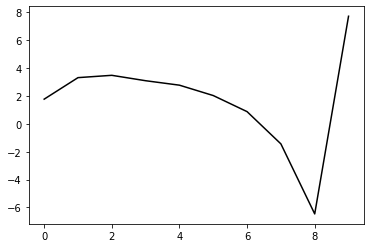

201300 18.80933057813629
0.6981686264315095 -0.34941683831940273 0.45469758513344616 0.22319287260055762
[ 1.76119863  3.09148847  3.16115643  2.68677099  2.30671706  1.53500493
  0.37561976 -1.93336699 -6.95584376  7.7301873 ]


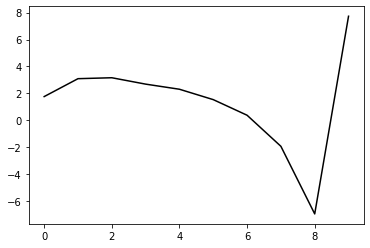

202400 18.118611822051886
0.7551678436439232 -0.32647684308203995 0.44890434864092493 0.24238732815335842
[ 1.75641753  3.37040494  3.50053972  3.07589459  2.73555011  1.99794442
  0.86585054 -1.42236533 -6.43575723  7.76584911]


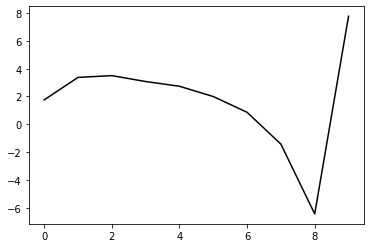

203500 24.115220390798264
0.7301263420572548 -0.34110876016072034 0.4531475144030523 0.23996617834995998
[ 1.78044658  3.31187024  3.40748182  2.93262977  2.53298974  1.74120626
  0.56301582 -1.76129807 -6.79053365  7.6834476 ]


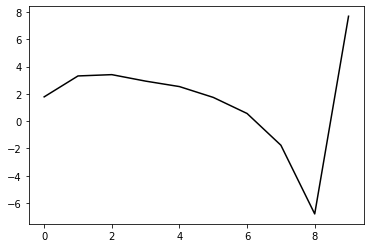

204600 43.11051869697721
0.6980862819232662 -0.3727531056528579 0.476534686615402 0.2272011845835458
[ 1.73857696  3.28802087  3.39017702  2.9105811   2.49871321  1.69728879
  0.51054915 -1.82277477 -6.86402036  7.64270696]


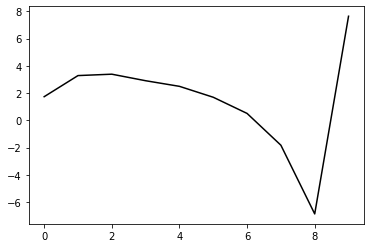

205700 23.29440147556973
0.7373350627099253 -0.34237595189707726 0.45982582757729495 0.24194425514515408
[ 1.72954132  3.45619119  3.57309705  3.10667232  2.70745094  1.92167165
  0.7496127  -1.57279072 -6.6120348   7.73114057]


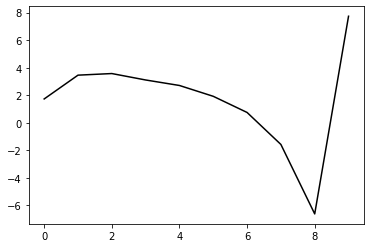

206800 19.551728185001153
0.740761583068158 -0.3261234583181731 0.4487341911285411 0.24564180923552734
[ 1.82331548  3.36375277  3.4800008   3.01242468  2.61370217  1.83550016
  0.67329526 -1.64080972 -6.67787716  7.69860478]


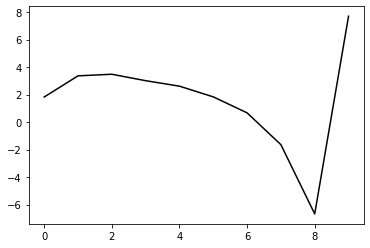

207900 12.697255254280615
0.7285571771213254 -0.33528330726237104 0.459745801265187 0.23674538092961186
[ 1.78126119  3.25809131  3.40617125  2.97815807  2.62631473  1.90363898
  0.79379261 -1.48249503 -6.51022293  7.71529621]


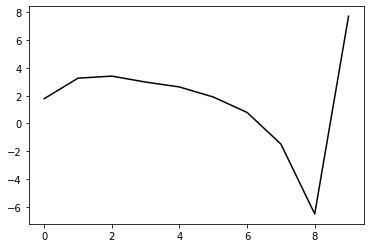

209000 20.891703739648353
0.6998184890682863 -0.3282208582872942 0.449133083400965 0.23448538057384982
[ 1.85637753  3.01822598  3.09865423  2.61249967  2.218058    1.47573677
  0.3610616  -1.91614998 -6.95993822  7.70048894]


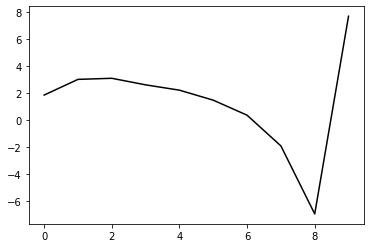

210100 24.22952001753506
0.7038675878810201 -0.344180950224239 0.45985682500100045 0.23582082869205143
[ 1.80114773  3.20878722  3.28981648  2.78967123  2.36972721  1.60100879
  0.46210053 -1.8326806  -6.87536268  7.63104755]


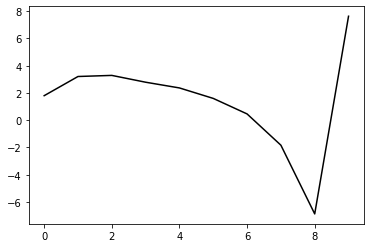

211200 21.41335351107213
0.728976488591079 -0.3252423191793517 0.4489794129610257 0.24605331705212222
[ 1.83823215  3.29017931  3.40734294  2.93623594  2.53525628  1.78027064
  0.64823186 -1.64452315 -6.68751538  7.69319396]


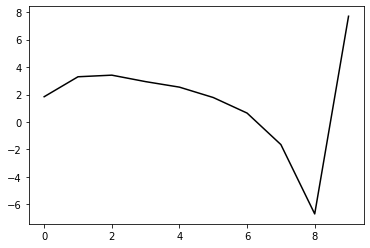

212300 15.286927513603747
0.7661802191005124 -0.30920883651886144 0.4458857469500983 0.23589915326359
[ 1.7074783   3.49522903  3.57318559  3.05535947  2.60828256  1.81751765
  0.65796265 -1.65728951 -6.72168463  7.6947436 ]


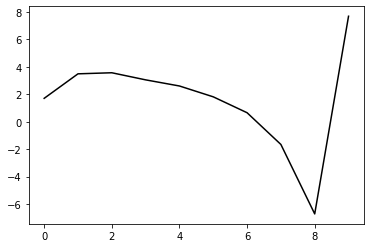

213400 24.178822066057364
0.7102753843028008 -0.33791379029607516 0.46140499363808135 0.2362213508758239
[ 1.75400117  3.35523074  3.42884947  2.90916623  2.46457266  1.68428768
  0.53806137 -1.76606413 -6.82501864  7.62955315]


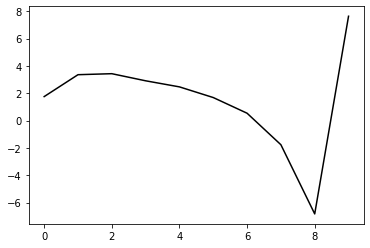

214500 21.01923469626348
0.7207109800350743 -0.3193422319016075 0.4488752574887283 0.252897320931287
[ 1.79651142  3.42367856  3.5272658   3.03374491  2.61289696  1.85811827
  0.7349417  -1.55248744 -6.61121331  7.74211244]


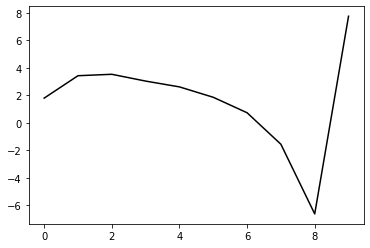

215600 20.39393056054429
0.7307116923944823 -0.31753175404371475 0.4521268625112283 0.24257249281685359
[ 1.74466361  3.50685439  3.59401468  3.07695813  2.62802156  1.8465828
  0.69652927 -1.61942612 -6.71048416  7.66540781]


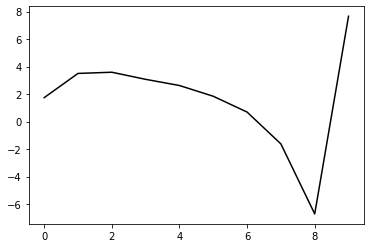

216700 16.290599649485014
0.709277879117756 -0.30235175950116977 0.4400980294747919 0.2406516133276301
[ 1.78847581  3.38145248  3.43189666  2.87869154  2.39840679  1.59719761
  0.43579622 -1.88830761 -6.99335252  7.66055565]


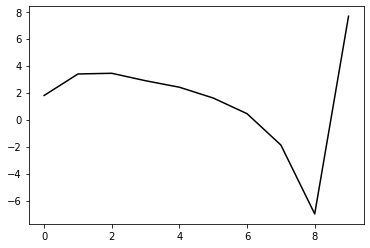

217800 27.38066754719147
0.7405694503001512 -0.2943945164378516 0.4408063951581059 0.24760119895345303
[ 1.7988395   3.52425734  3.62127928  3.10499918  2.65306262  1.87584669
  0.73225164 -1.5796654  -6.67888547  7.62435773]


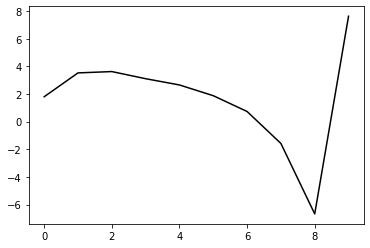

218900 12.03807417021636
0.7176827523861056 -0.3162930376077914 0.45312720094824793 0.242813017097305
[ 1.7576282   3.46307947  3.55461891  3.02790936  2.56398526  1.77965373
  0.630715   -1.68664645 -6.78880209  7.65557945]


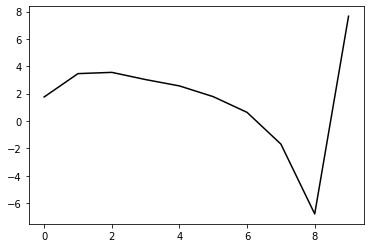

220000 26.28997700465798
0.6336851619147325 -0.34296461637475356 0.4636885563550126 0.23216967703570102
[ 1.78980635  3.17255613  3.220061    2.65622179  2.16668702  1.37215958
  0.22069379 -2.09981889 -7.22020766  7.66495435]


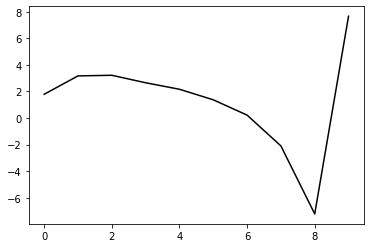

221100 25.158447252817155
0.6835431360782109 -0.32274602888480225 0.4591131924378897 0.2522359363589161
[ 1.82488588  3.37116646  3.49128233  2.98491865  2.53845933  1.77774187
  0.65034548 -1.65420496 -6.76395428  7.64052248]


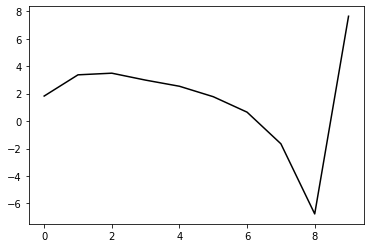

222200 24.676132176316486
0.7189844454014631 -0.29790611288218016 0.4523370183881834 0.24807111632582812
[ 1.81862012  3.4927584   3.63427964  3.14727226  2.71866068  1.97803725
  0.86780322 -1.42763015 -6.55325874  7.76717032]


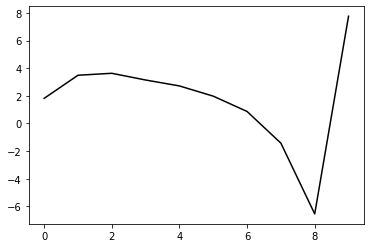

223300 16.30939755293899
0.6808400517984403 -0.32522453680931807 0.46797074640651104 0.2407843641683566
[ 1.80007891  3.39722341  3.51678393  3.00813786  2.55985069  1.80722284
  0.68954383 -1.61166955 -6.73625937  7.73586749]


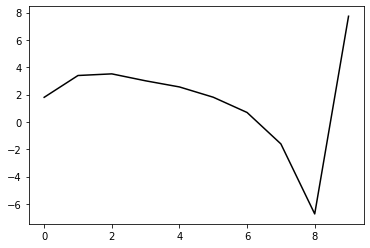

224400 24.120969325122044
0.6978232279466204 -0.3078389213581384 0.4605780691950534 0.22941297390514973
[ 1.74882406  3.48874477  3.57057751  3.0196491   2.52939591  1.74151555
  0.5926777  -1.7387741  -6.89981238  7.61277423]


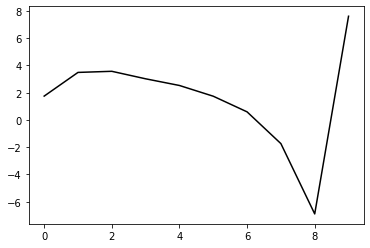

225500 27.35365013804114
0.7163240364794179 -0.2920042468373515 0.44935031864775593 0.2520364283023622
[ 1.80253571  3.61794867  3.74413905  3.22329601  2.75210283  1.97906758
  0.84082343 -1.48251705 -6.63394385  7.70427558]


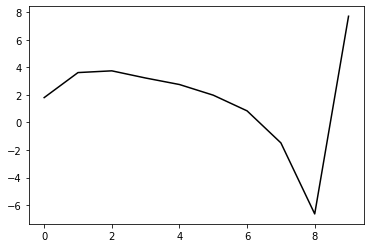

226600 21.30791756363847
0.6934894163880772 -0.31551119563859803 0.4640493462177872 0.24499852042531411
[ 1.75382138  3.54160734  3.65335997  3.11705619  2.63276598  1.85430347
  0.71491825 -1.60740761 -6.75410875  7.68107277]


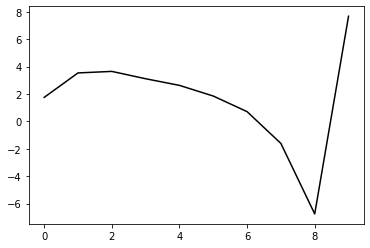

227700 14.232069726257695
0.6957350374350721 -0.3003004719329484 0.4564338876374777 0.244898991599606
[ 1.80402742  3.43553186  3.56056089  3.04144978  2.57914459  1.83067941
  0.72195342 -1.57782744 -6.72352754  7.74500361]


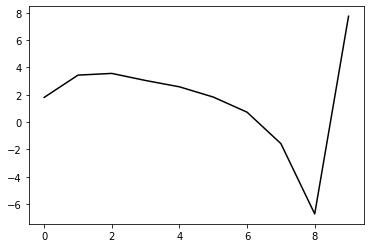

228800 19.64704639552307
0.6908189420529374 -0.30901426688488143 0.466073132223083 0.24049968211631614
[ 1.77507723  3.41335254  3.55580738  3.05013757  2.59902277  1.86532839
  0.77131389 -1.51798155 -6.66547312  7.70118732]


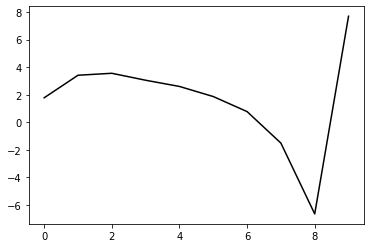

229900 16.355070169825115
0.6737087216492669 -0.31717644771936127 0.4703006204316906 0.23216595273127386
[ 1.74770262  3.4105325   3.51557511  2.96542861  2.46485226  1.68514711
  0.54839242 -1.7809399  -6.97360247  7.63492314]


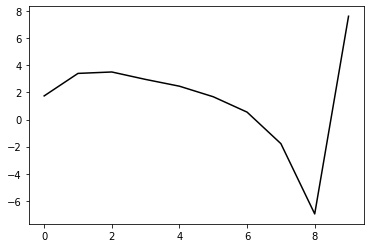

231000 16.583118777193803
0.6715479699279158 -0.32043398906210246 0.4750489812590194 0.2358370633801617
[ 1.77277725  3.40305962  3.54308666  3.03209517  2.57276039  1.83775852
  0.74034106 -1.56184934 -6.74394958  7.67506789]


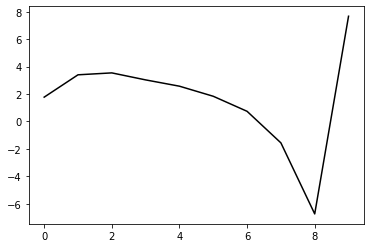

232100 26.08409868855656
0.661290906696397 -0.304067839511933 0.4616304479219341 0.23659909138893795
[ 1.84745245  3.26555385  3.37911914  2.84703492  2.37467262  1.63933414
  0.54686261 -1.75233718 -6.94489721  7.69890404]


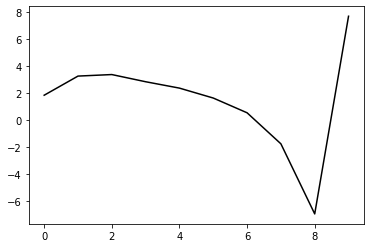

233200 18.42898027926392
0.6659608883638156 -0.3054340249090918 0.4662463280779851 0.2336570290793974
[ 1.78811189  3.36288217  3.49755521  2.97857176  2.51185808  1.78146677
  0.69130078 -1.6099565  -6.80967294  7.62662837]


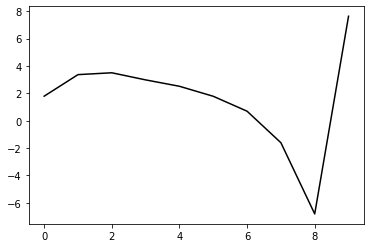

234300 16.200419596258204
0.6682027793409043 -0.30514693065748316 0.467743669892597 0.22797157661224823
[ 1.76745296  3.42044906  3.54041695  3.001173    2.51016298  1.7574887
  0.64535484 -1.67891243 -6.90502897  7.67403756]


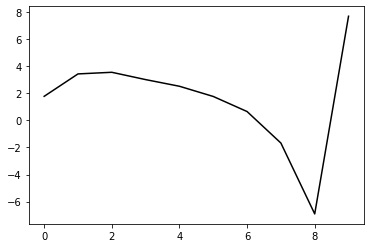

235400 25.462340927917275
0.6540290643857155 -0.3121859867913404 0.4674888582740526 0.2340711078919932
[ 1.77865042  3.44030395  3.54746764  2.98642405  2.47157546  1.70269196
  0.58092846 -1.74783176 -6.97182967  7.6460334 ]


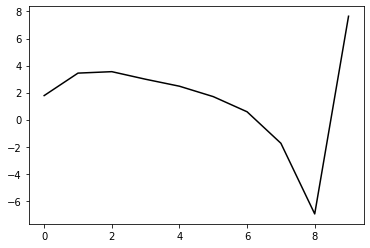

236500 22.568670369973784
0.6609171063116311 -0.31163127014143077 0.46995469052156247 0.24405589834158872
[ 1.79316692  3.49547786  3.64425993  3.11934682  2.63457061  1.89409003
  0.7956381  -1.51741443 -6.73347466  7.76353261]


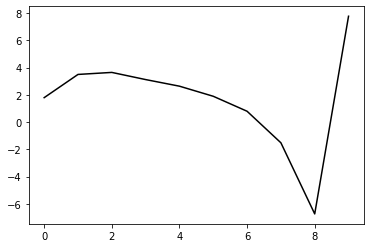

237600 25.275262873813286
0.6531725982522443 -0.2911164354886122 0.45392995996465374 0.2459216039930382
[ 1.81006266  3.40104926  3.51098703  2.9509311   2.43838813  1.68292054
  0.57720693 -1.7412399  -6.96837563  7.72808265]


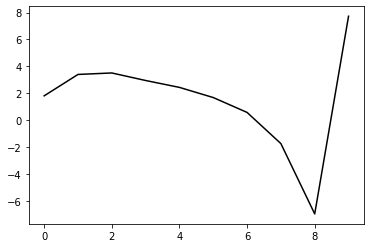

238700 14.465896561828824
0.6745555789058231 -0.29388064212623055 0.46397637911468975 0.23565328233282537
[ 1.73195554  3.57969493  3.69927598  3.13940653  2.61989717  1.85578211
  0.73842233 -1.5960714  -6.84525024  7.62453876]


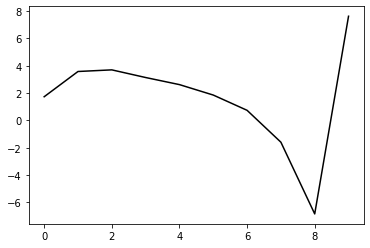

239800 22.48997456828837
0.6895990839545615 -0.27770063696866826 0.45453631303577735 0.25127569092472407
[ 1.78731803  3.63471324  3.79286989  3.26289607  2.76673197  2.02374675
  0.92400277 -1.39638981 -6.6376432   7.73213282]


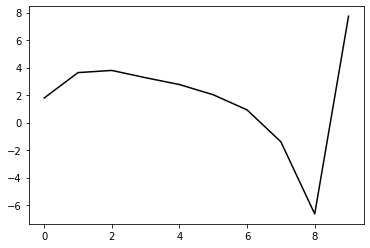

240900 13.592694031018663
0.6688360241938225 -0.29549429191155024 0.4661983636293919 0.2438715395518355
[ 1.73143564  3.5358668   3.67528164  3.13123451  2.62790113  1.88860503
  0.79769624 -1.51596457 -6.76129236  7.65275016]


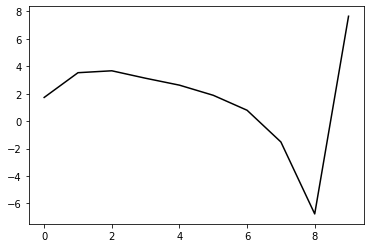

242000 11.24095308613144
0.6709008771923698 -0.29247375153155997 0.46287152607949505 0.247860436863074
[ 1.79327261  3.51708171  3.66213148  3.11920473  2.6149403   1.87945265
  0.79597014 -1.50653422 -6.7310646   7.70900697]


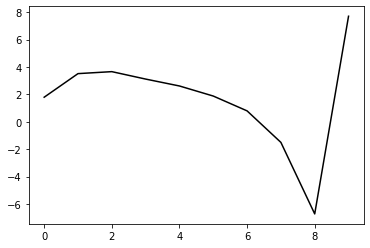

243100 20.109607597492904
0.6671269333892944 -0.2947681183288781 0.46595277266518076 0.2441221584594442
[ 1.7400024   3.50027746  3.63893613  3.08564014  2.56999141  1.82932179
  0.74309131 -1.56446035 -6.8075965   7.64863078]


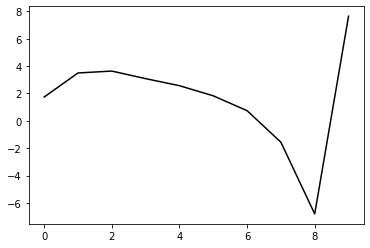

244200 81.9267495849042
0.6741640063811647 -0.34104211585545263 0.5077579053846547 0.21007098561750465
[ 1.62138762  3.50213226  3.63913619  3.07371217  2.53827427  1.78116421
  0.68206738 -1.63579418 -6.89146314  7.6921448 ]


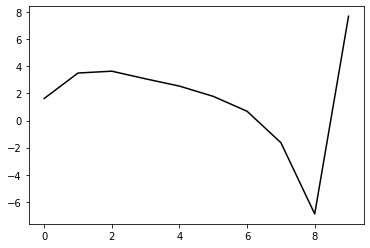

245300 14.725043450381992
0.6947137760378927 -0.2725292143862197 0.46796545403250017 0.2354490398849361
[ 1.73127207  3.47808088  3.65035401  3.12375411  2.631718    1.92651911
  0.88179731 -1.38921494 -6.63229506  7.71338432]


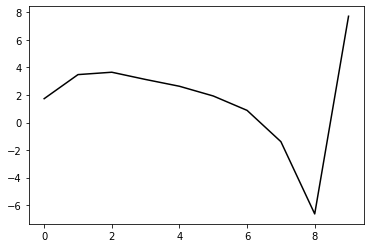

246400 25.07789992255981
0.6542069766668933 -0.29069529296932184 0.46823444028674954 0.24547513179819908
[ 1.80524681  3.37292348  3.51703517  2.95449035  2.42330783  1.68915624
  0.62684817 -1.65218119 -6.88409598  7.72068207]


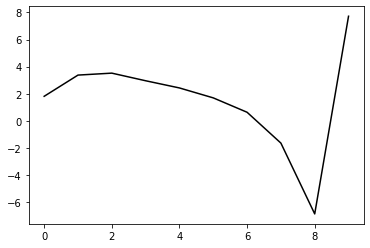

247500 46.88578756887358
0.6968633763967551 -0.2589132775898702 0.456153040763233 0.25344276086003015
[ 1.84486336  3.55940229  3.7591972   3.24064048  2.73977964  2.02801342
  0.97945238 -1.29474716 -6.53947457  7.74521423]


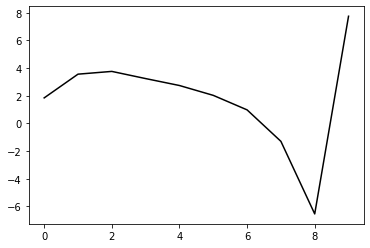

248600 25.989392229605244
0.654054831630073 -0.28333874028653355 0.4645717924908694 0.23894352474649713
[ 1.77137796  3.42689435  3.53247205  2.9177269   2.33035826  1.55320583
  0.45827111 -1.84978989 -7.12600037  7.60427709]


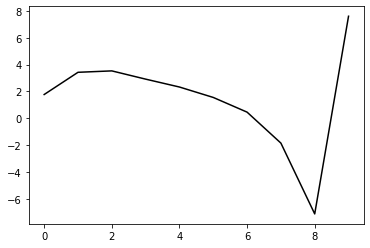

249700 16.099469126349124
0.6557299766721377 -0.29123619327927514 0.4738044552605599 0.2372977914808395
[ 1.74675204  3.49297741  3.61489279  3.01342864  2.43568901  1.66714026
  0.57676894 -1.73364946 -7.01858099  7.56831305]


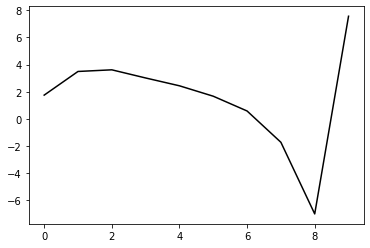

250800 23.492850223363625
0.645566963909887 -0.29313520038984037 0.4681181166711048 0.26319262097969603
[ 1.78718404  3.51543961  3.65408381  3.0611344   2.48621837  1.72033114
  0.63269173 -1.67358288 -6.94942397  7.65618071]


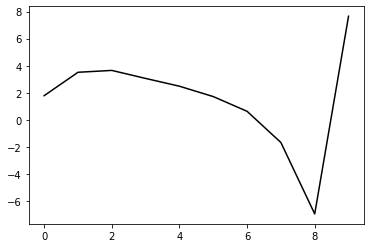

251900 18.672151919269865
0.6743272209853368 -0.2930953895677428 0.47704333832712287 0.25241333681359696
[ 1.70041768  3.7051022   3.86075805  3.27871097  2.7098487   1.95014137
  0.86638704 -1.44016405 -6.72718673  7.69182488]


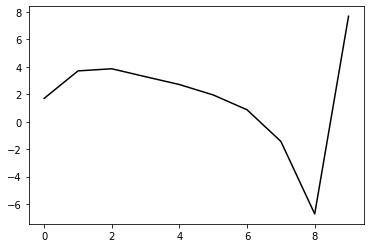

253000 16.3277659294335
0.6673830692245839 -0.2850335665511702 0.47352281829695037 0.24039357132381484
[ 1.75456811  3.48600496  3.60805047  2.99635752  2.40504008  1.63607974
  0.55140763 -1.75468392 -7.04878898  7.60690419]


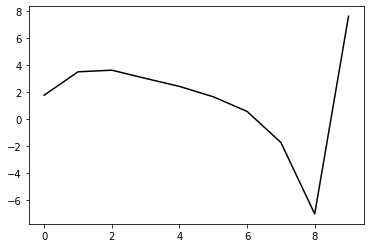

254100 19.976995862227092
0.6677737229190205 -0.2829531224341158 0.4727840290030665 0.25078592267736866
[ 1.72686429  3.62359665  3.78948976  3.2130052   2.64918922  1.90532772
  0.84090777 -1.45147688 -6.73657908  7.70963541]


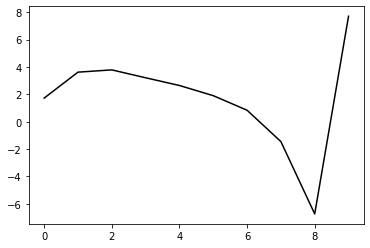

255200 36.51783081396024
0.6774910284379162 -0.261628432519497 0.4611312439328343 0.25729935984346447
[ 1.79352773  3.63138576  3.80573612  3.23552634  2.67763831  1.94402432
  0.89021915 -1.39605679 -6.68482598  7.65322123]


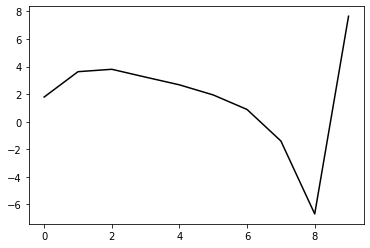

256300 18.809018097302026
0.637892072741649 -0.29582714969098833 0.47215892793660597 0.2484616427738303
[ 1.71829244  3.60170327  3.69504764  3.03959091  2.39730473  1.58731313
  0.46606134 -1.87813428 -7.21669354  7.55654642]


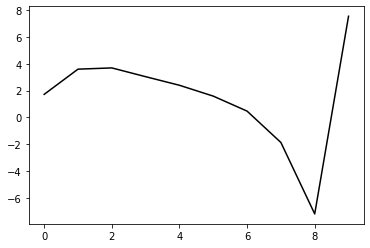

257400 18.297561413983555
0.6882707102575504 -0.270953084421126 0.46504764769376256 0.2556563307222429
[ 1.69807449  3.84932398  3.99709683  3.38293289  2.77173577  1.9871863
  0.8845241  -1.44784969 -6.77881997  7.67807717]


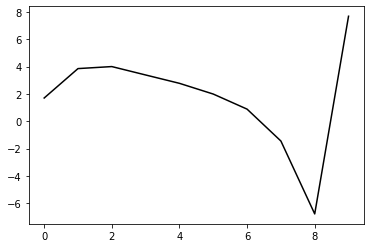

258500 21.99284823917163
0.6436343142225055 -0.2959500171360365 0.4733592988238963 0.2648545447115293
[ 1.76077966  3.61022439  3.75187422  3.13955773  2.54059465  1.78061284
  0.70779274 -1.59584512 -6.89769817  7.65059364]


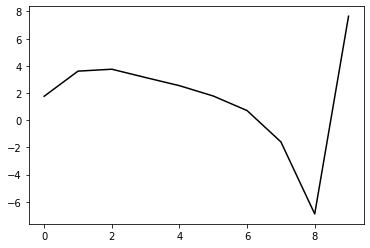

259600 21.55828874011043
0.6562070338200064 -0.2858507683226181 0.4708005648269113 0.2600459856000048
[ 1.74580519  3.62134006  3.76377798  3.15171064  2.55498216  1.80397033
  0.74240246 -1.55296592 -6.85792361  7.70555038]


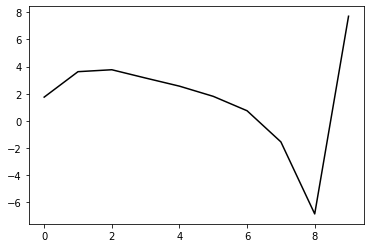

260700 11.921919654749908
0.6702428592427984 -0.27692999601357027 0.46754829605862197 0.2568609352355041
[ 1.70270728  3.70606298  3.84795681  3.22690616  2.616468    1.85531857
  0.78560223 -1.51791452 -6.83308885  7.66942764]


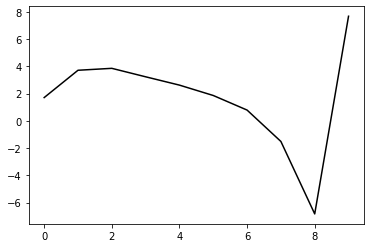

261800 19.900663982831695
0.657735787525394 -0.28384958455204384 0.47243630479177806 0.2541181561386748
[ 1.73030241  3.54153592  3.67965672  3.06337191  2.4713119   1.74444956
  0.71369095 -1.55711902 -6.85266506  7.64904781]


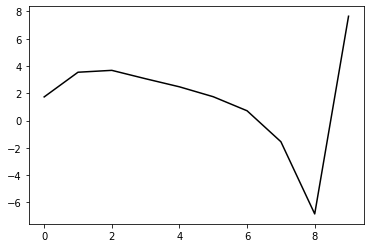

262900 40.0437276312361
0.6560433490990278 -0.26846170153119514 0.4598757772481919 0.2611721533370808
[ 1.87954417  3.39920331  3.55727019  2.9590396   2.38487516  1.68025492
  0.67077621 -1.58556141 -6.8836855   7.60189202]


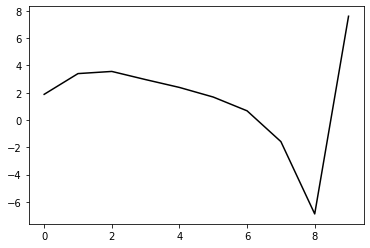

264000 11.954662673814703
0.6785448627126957 -0.2717789872263097 0.4642874037921705 0.25295959630821385
[ 1.73960691  3.63680442  3.76560494  3.12234922  2.49217543  1.73146657
  0.67055073 -1.63075172 -6.97438625  7.66327745]


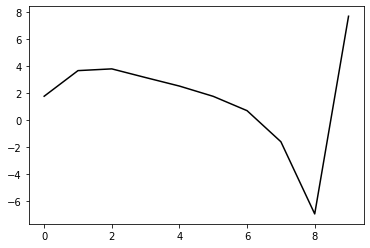

265100 25.298874732620593
0.6528677343245742 -0.28831283400250146 0.47087800729497176 0.25043826549381604
[ 1.73474065  3.55772797  3.65869911  2.98209894  2.31811875  1.53026872
  0.44862448 -1.86897192 -7.22883859  7.59000152]


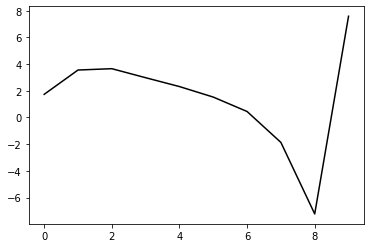

266200 18.853801448580192
0.6668786693666198 -0.29136744419446725 0.47587135993063184 0.26009336178132314
[ 1.7665832   3.63791747  3.77900611  3.13314076  2.49243437  1.72564924
  0.66211127 -1.63973061 -6.97998331  7.72952769]


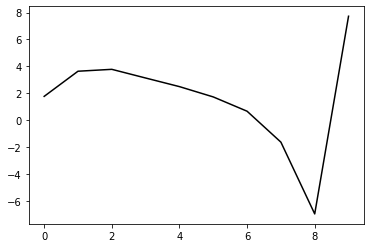

267300 19.167195220779046
0.6476942628669025 -0.2907720942873618 0.47436667990048675 0.2599151617523356
[ 1.74291755  3.50520546  3.63695833  2.99094369  2.36194774  1.62107856
  0.58951843 -1.68518492 -7.01813349  7.69995667]


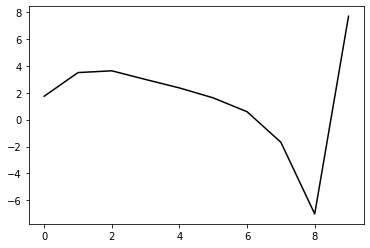

268400 23.80619407858875
0.648798967158746 -0.30269944719925757 0.48441633407727336 0.254927856744526
[ 1.72417165  3.5713355   3.70796865  3.06034246  2.42439685  1.67613344
  0.63628518 -1.64722285 -6.98351586  7.61759633]


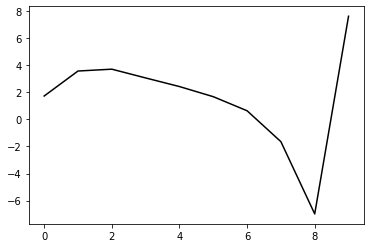

269500 23.340644758315282
0.6513347335375989 -0.27547841910660886 0.4626326999295559 0.2648961127531904
[ 1.7681084   3.50979738  3.63636387  2.98193345  2.34392394  1.60210456
  0.57272526 -1.70199588 -7.03928026  7.67142656]


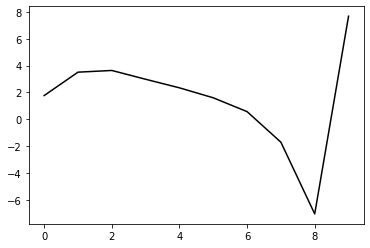

270600 27.896325651245277
0.6623909126605908 -0.2886498954791471 0.4775550604890215 0.24951189432340254
[ 1.64510743  3.61311096  3.72201048  3.04208538  2.37416664  1.60502758
  0.55074293 -1.74661412 -7.10322708  7.58924129]


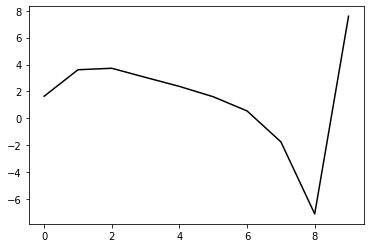

271700 24.704533666913534
0.6541381586326981 -0.2692840000941936 0.4612421328480889 0.2655717529829254
[ 1.81432535  3.48762153  3.63126254  2.99060999  2.36579813  1.64460418
  0.63686371 -1.62159844 -6.9481861   7.66214389]


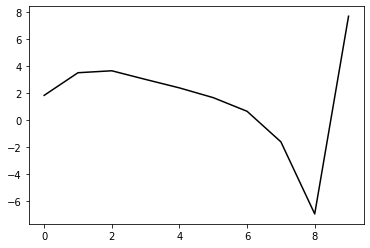

272800 17.997808109827837
0.6887150306139237 -0.2576767915932586 0.4625632432057818 0.2519125047190111
[ 1.73068789  3.64549561  3.78522239  3.13482246  2.49887407  1.77046856
  0.7562087  -1.51176807 -6.85495879  7.65748306]


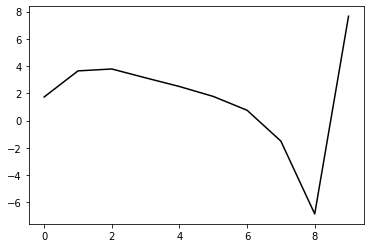

273900 25.82713819893711
0.6822470158416084 -0.2759356016083924 0.47602198299016296 0.25023131249066727
[ 1.66952334  3.69447944  3.85630182  3.2236376   2.60109516  1.88577893
  0.88228116 -1.37883843 -6.7217289   7.70952104]


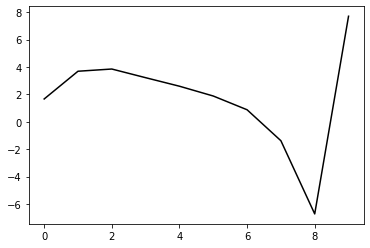

275000 37.89575631587516
0.6521010375546255 -0.26113579014283733 0.4615747884719551 0.25879633555942355
[ 1.87650774  3.40451314  3.56833133  2.94477372  2.33772027  1.64662716
  0.6704101  -1.56785262 -6.89738722  7.68359843]


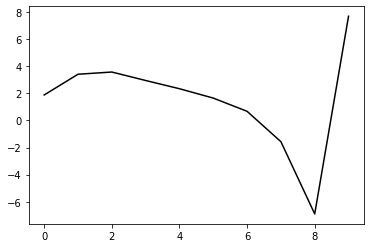

276100 19.457551863805488
0.6608427755906883 -0.2781560302997817 0.47728025911293204 0.24998082148501555
[ 1.74668811  3.58182381  3.75346097  3.13043239  2.5166753   1.81707698
  0.83074519 -1.41883816 -6.76028577  7.73192507]


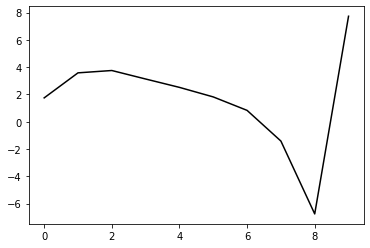

277200 16.9919475430383
0.6642192832544467 -0.2739271573681437 0.47504461726458275 0.24624664034143487
[ 1.72586737  3.59091696  3.73032991  3.07301348  2.42894734  1.71083047
  0.71514255 -1.5396058  -6.88597746  7.63758724]


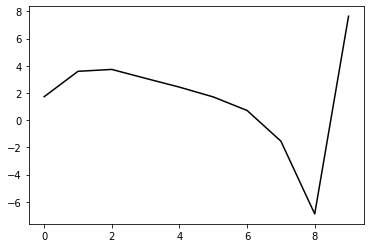

278300 12.572269609299727
0.6783187322009315 -0.26461997408162446 0.47364455804876876 0.2515513435986837
[ 1.74062271  3.63647714  3.81731298  3.19694209  2.58387437  1.89393858
  0.92089032 -1.31858259 -6.66272147  7.71927693]


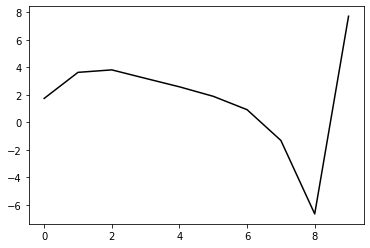

279400 17.27640384897965
0.6866797401749044 -0.26191845793918306 0.4724273351604635 0.2502698354230469
[ 1.73585177  3.70186164  3.88881246  3.27074296  2.65834359  1.97278485
  1.00543756 -1.22992142 -6.57295571  7.67606204]


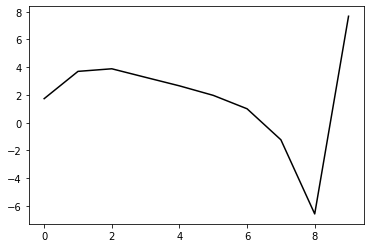

280500 27.055546725303376
0.688092902506601 -0.24329601772449413 0.4598761544331977 0.24540855150075197
[ 1.77573236  3.62679994  3.77224128  3.11205212  2.46148469  1.74851601
  0.76262618 -1.48745117 -6.85146822  7.74650191]


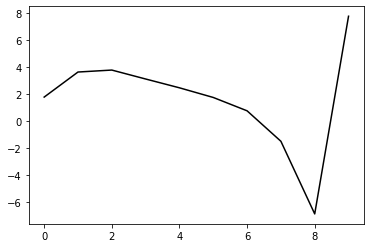

281600 22.616393298234485
0.6660196613018777 -0.27344064516310895 0.4759517074096353 0.25140959468111557
[ 1.77677306  3.52247003  3.65996678  2.99218177  2.33789322  1.63132376
  0.66025857 -1.57116786 -6.92096932  7.70440415]


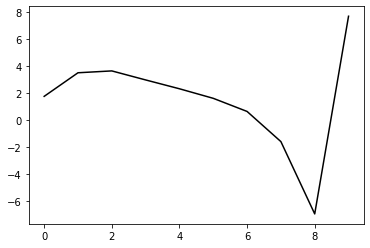

282700 15.733317326268997
0.6583663200552322 -0.27743798499704375 0.47764016919484836 0.25631093620789674
[ 1.79271255  3.43501233  3.58468107  2.92945536  2.28981011  1.60424594
  0.65662126 -1.55559025 -6.90059743  7.68453215]


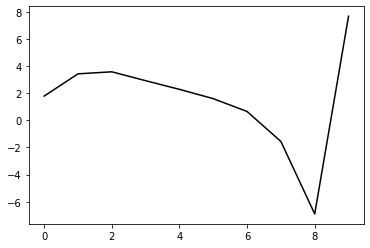

283800 28.875497580953674
0.6438415310642845 -0.28182152489794504 0.47811108962967547 0.25128699238815266
[ 1.83622931  3.31576523  3.43420218  2.74592906  2.07158011  1.35523392
  0.37996109 -1.85852915 -7.23663281  7.62759018]


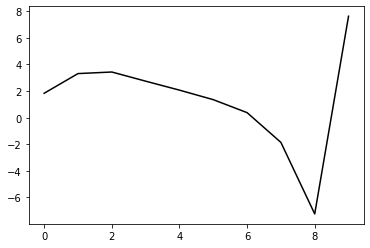

284900 12.40173753542087
0.695626670753851 -0.26549925250130446 0.47688916650492713 0.25597725284460937
[ 1.716034    3.71328487  3.87961437  3.22864353  2.58207033  1.88878726
  0.93150393 -1.29417329 -6.66269944  7.63226867]


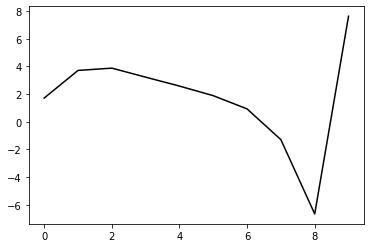

286000 24.977627805530386
0.631795600664007 -0.27892791842944914 0.4736930243558983 0.25890070988896846
[ 1.82934168  3.32203943  3.42211698  2.70811491  2.00663809  1.27405737
  0.2920998  -1.94857061 -7.33168131  7.57990773]


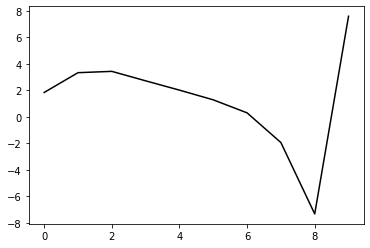

287100 17.444665769817203
0.6878350920433188 -0.2675859264735423 0.47788986402127237 0.2620322286377731
[ 1.75832966  3.65506626  3.81765265  3.15730117  2.50022314  1.80686609
  0.85730164 -1.35981367 -6.73254795  7.68225226]


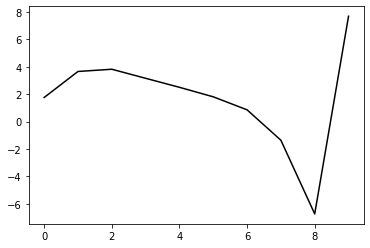

288200 15.081138720163146
0.6974770349429198 -0.2629923256324313 0.4808468500915243 0.25302141090513725
[ 1.71606157  3.66418558  3.83443135  3.18309302  2.53607184  1.85722056
  0.92194367 -1.28796078 -6.6706498   7.69126716]


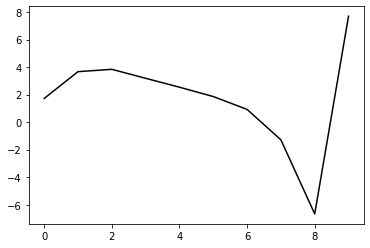

289300 14.51266565681826
0.6728521805966464 -0.28210748279448583 0.4892136430899946 0.25547785673194456
[ 1.73560314  3.60692048  3.78038031  3.12760072  2.47455199  1.79166713
  0.85427223 -1.35557321 -6.728624    7.76874326]


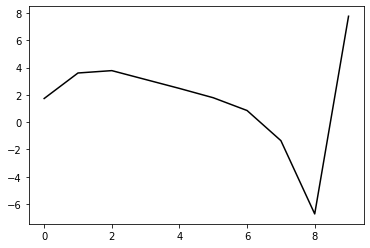

290400 25.38966502368514
0.6624940368803645 -0.2703609130768237 0.47602478321646163 0.2546687193168511
[ 1.72771507  3.60838855  3.7054926   2.9736822   2.24597028  1.50112233
  0.51340515 -1.73905095 -7.15255827  7.6380501 ]


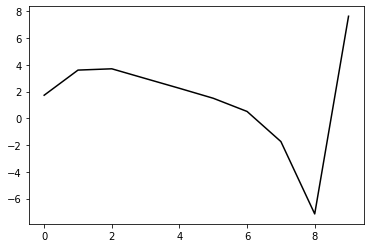

291500 22.396258256407584
0.6916023957350383 -0.2618745712422812 0.4746283470589103 0.267601720577402
[ 1.77543093  3.73810002  3.88728278  3.18968121  2.4821203   1.75059449
  0.77086895 -1.4780083  -6.88996599  7.68694929]


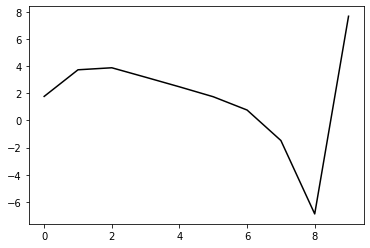

292600 22.8418986872872
0.6582795745001265 -0.2753442424931773 0.4806014553935356 0.26847970639238067
[ 1.77782793  3.67885788  3.83014672  3.13539252  2.43256846  1.71124113
  0.74330382 -1.49939055 -6.92234643  7.7267855 ]


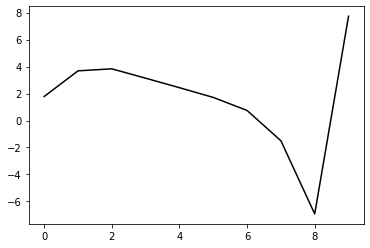

293700 30.33512979272184
0.7074914610475506 -0.25972783021072043 0.4805968410571984 0.25390870533073545
[ 1.65926648  3.86773526  4.01581288  3.3098952   2.59018997  1.85263513
  0.86899639 -1.38973965 -6.83061291  7.730791  ]


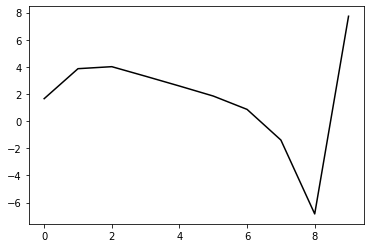

294800 23.480604331597753
0.6824249570594519 -0.2643348679230259 0.47515000533826024 0.2658270416000775
[ 1.80922211  3.65630214  3.80415683  3.09528814  2.37404376  1.6424335
  0.67047467 -1.5736076  -6.9900906   7.64154897]


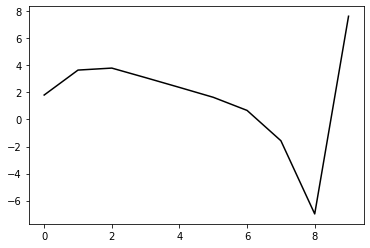

295900 13.812318893337117
0.6649820116641217 -0.2791823611296322 0.48774528630547176 0.2582904459245332
[ 1.71950895  3.67880457  3.83197923  3.13096296  2.41976764  1.70275178
  0.74517239 -1.49132698 -6.91853593  7.65075579]


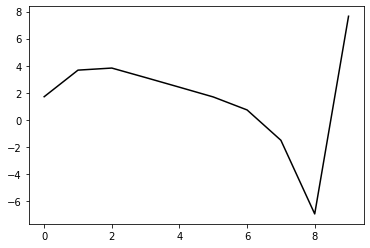

297000 16.56751667250835
0.6643727117648934 -0.27659364206215115 0.48647123001802783 0.2521410993316688
[ 1.77496577  3.54277561  3.65736083  2.92278141  2.1907682   1.47206666
  0.52681465 -1.69106002 -7.10119827  7.67019243]


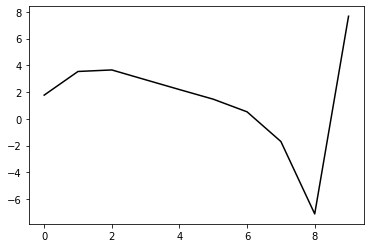

298100 21.980648440131766
0.6800702067110393 -0.27003766240530686 0.48615318373773425 0.2590729274829685
[ 1.70171591  3.80222481  3.96381136  3.26688257  2.56110475  1.86144681
  0.92729494 -1.28765802 -6.70073064  7.65116646]


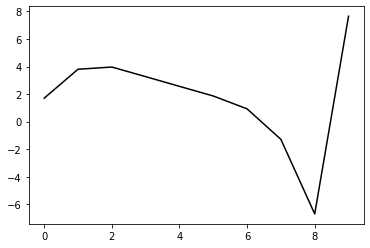

299200 24.065484095755135
0.6442003357694561 -0.28275888890834167 0.4843561343125571 0.2647080190296647
[ 1.81916601  3.60382191  3.74420752  3.02166641  2.28689485  1.56074214
  0.60384628 -1.62934098 -7.05130186  7.72200493]


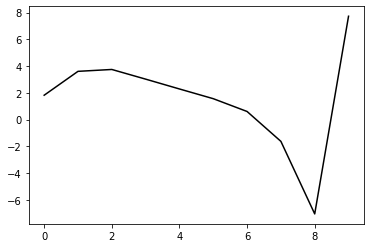

300300 25.83990820644439
0.640228075149916 -0.28072244322794815 0.48148569909645395 0.2647882452939073
[ 1.83901702  3.53750836  3.66784991  2.93268302  2.18456841  1.45018605
  0.48939943 -1.74611619 -7.17428446  7.67427134]


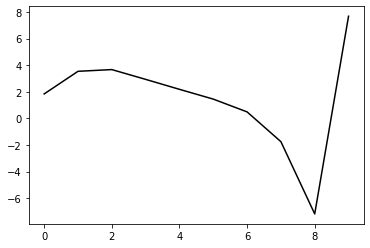

301400 19.54777139985593
0.6825236253769296 -0.2616623944560915 0.47900822845722246 0.2578677829249124
[ 1.7429195   3.78340075  3.93570099  3.21565932  2.47646343  1.74941659
  0.79273522 -1.44388342 -6.87776823  7.67394924]


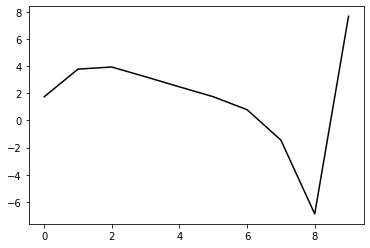

302500 25.202841608463068
0.6495116918698203 -0.27145856400875107 0.4883631008473582 0.24718056271823383
[ 1.79319045  3.47205726  3.62491078  2.91987803  2.21092022  1.53049944
  0.62824838 -1.55856118 -6.96317617  7.72600583]


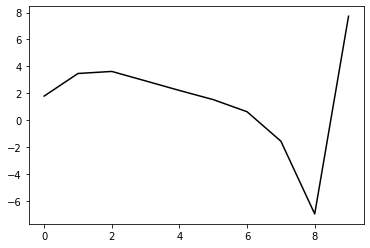

303600 20.427812243467226
0.6446106397064083 -0.284646422410093 0.499865205477467 0.2520525083031563
[ 1.77743721  3.49275039  3.68994506  3.02654361  2.35490832  1.70982133
  0.83793566 -1.32547597 -6.71778039  7.74766906]


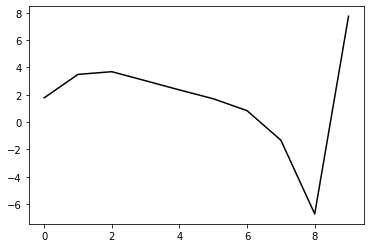

304700 12.778937378799869
0.6586149403298656 -0.264941365581795 0.4906770444562531 0.24521580094649095
[ 1.760085    3.53905677  3.72416951  3.04808341  2.36179422  1.703952
  0.8194802  -1.36014177 -6.77908634  7.67069923]


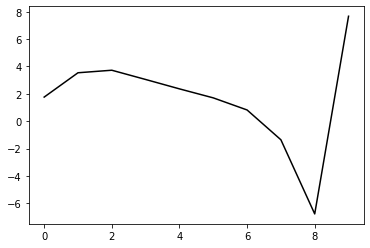

305800 25.058748230531293
0.6199046601412479 -0.27826071275173037 0.48978211506883823 0.25574553881347545
[ 1.8226484   3.39189146  3.56259397  2.87322108  2.17411826  1.50814448
  0.61912234 -1.56358307 -6.98687138  7.64033057]


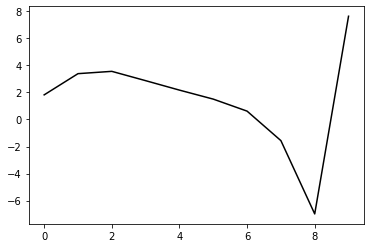

306900 14.464155542237794
0.6602925599137125 -0.2688750528551092 0.49340798310183775 0.2499545494948543
[ 1.73706549  3.59849347  3.79185296  3.12055326  2.43394904  1.7785719
  0.89722854 -1.28190613 -6.70520391  7.76867927]


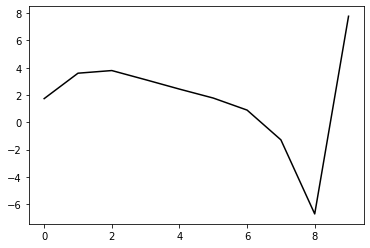

308000 34.31140550329421
0.6217912453346799 -0.29913153633717776 0.5081250618683342 0.2303106123465262
[ 1.71047068  3.44766125  3.59268618  2.87270187  2.13738874  1.43917594
  0.52107796 -1.69099372 -7.14926423  7.59825151]


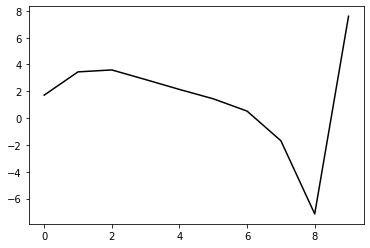

309100 23.787942622157413
0.6670038625566667 -0.24746331743079572 0.4750340895932283 0.25328727340107504
[ 1.77286134  3.57775807  3.74977192  3.05491758  2.34231409  1.66743433
  0.77147043 -1.42216306 -6.86632165  7.69446639]


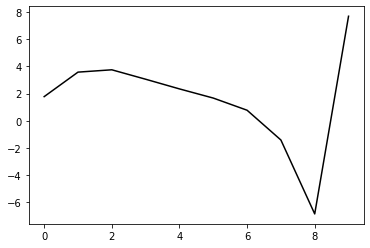

310200 19.414380261088926
0.6441189621427732 -0.27355636990813137 0.4902535453655439 0.24459102720426001
[ 1.72830553  3.51135754  3.65140962  2.9276557   2.18860355  1.49325962
  0.58136879 -1.62634735 -7.08208389  7.64505117]


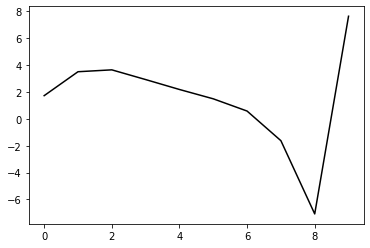

311300 23.16407309522818
0.6305145193292843 -0.2687821369248362 0.47894782313418 0.2609444008372979
[ 1.78501342  3.47849689  3.58665844  2.83009217  2.06502915  1.35701172
  0.44348343 -1.75846142 -7.2014448   7.64796397]


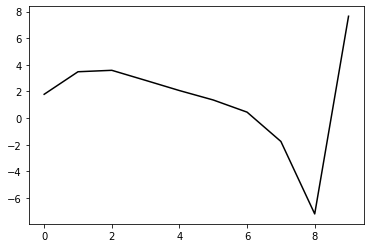

312400 28.1999930193676
0.6913868182396652 -0.2580722303569019 0.48496906423164954 0.25885153563432195
[ 1.67637686  3.83348405  4.00076035  3.28482205  2.54219349  1.84456406
  0.93168335 -1.27744584 -6.73658154  7.68133231]


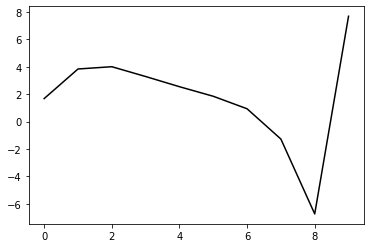

313500 29.784119708441743
0.6892822341788324 -0.2496179341255616 0.4757864018554247 0.2661044798191501
[ 1.78133751  3.76504524  3.95259167  3.25099723  2.51597772  1.82480268
  0.91797483 -1.28535969 -6.73241634  7.60233113]


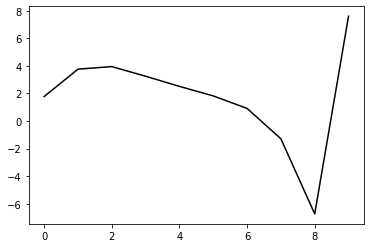

314600 23.05340574927644
0.6467972128459889 -0.2760672413144598 0.48714687578739563 0.26719792557880967
[ 1.77942118  3.54341166  3.71093311  3.00359609  2.27805823  1.61099215
  0.73401708 -1.44208705 -6.86622645  7.68161267]


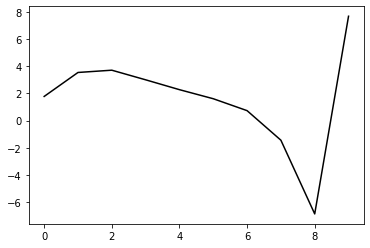

315700 12.547929453942508
0.673191162803499 -0.26015669138920866 0.48183185302649845 0.2569892668207182
[ 1.70990225  3.63471661  3.77830121  3.04468825  2.29299924  1.60601148
  0.71416726 -1.47561021 -6.91997599  7.65859753]


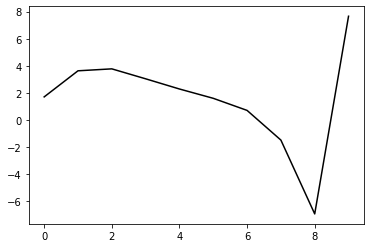

316800 28.550545534431663
0.6531936103399294 -0.2830294203556496 0.49681833731012387 0.24010811573435836
[ 1.68964126  3.5194346   3.58832675  2.77892701  1.95914895  1.22238248
  0.2982388  -1.91299361 -7.38828498  7.56677932]


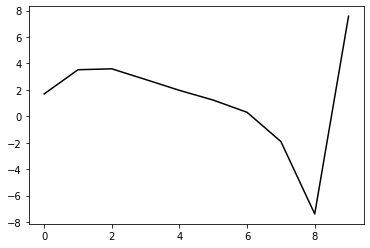

317900 67.43310479907923
0.6821133122608534 -0.2802757226380924 0.5017847897736036 0.23620181943774474
[ 1.58124965  3.72815652  3.82346761  3.03129193  2.21800809  1.48076244
  0.54978275 -1.67377777 -7.155133    7.63361283]


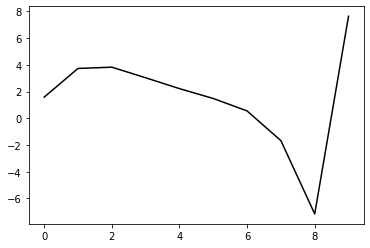

319000 23.751285254332593
0.6640176797774765 -0.26233145784645023 0.4785174725941326 0.2795691967392657
[ 1.80764404  3.6600716   3.80849312  3.06541532  2.29740464  1.60459281
  0.7158603  -1.46894985 -6.91247496  7.68043209]


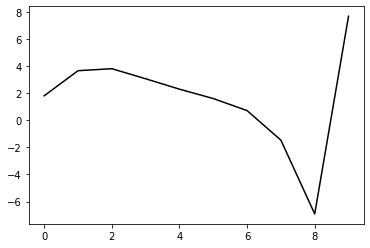

320100 21.428962611717047
0.6846346018483873 -0.2616574579732484 0.48271280048789655 0.2596676757196349
[ 1.68232227  3.76614778  3.87670236  3.09028098  2.27809337  1.54704583
  0.62637773 -1.58574062 -7.05027285  7.66271128]


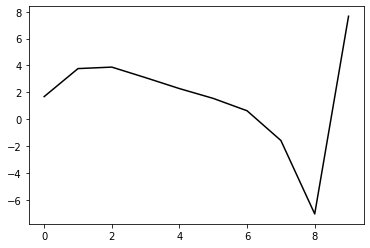

321200 20.17298452855814
0.6381112747278839 -0.28847440784045314 0.49341116743290464 0.2663754815694067
[ 1.74619566  3.58088869  3.69907832  2.92021044  2.11769755  1.40283122
  0.5020654  -1.69170657 -7.14221707  7.59880233]


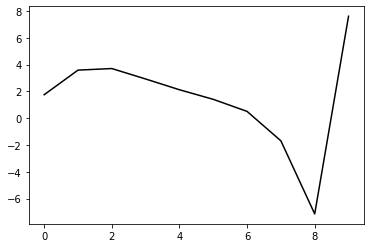

322300 14.929442376480914
0.678944568488168 -0.269679694858488 0.4884011656536894 0.2664225500925415
[ 1.68207276  3.78397162  3.9280383   3.16973402  2.38170272  1.67764266
  0.78148284 -1.41642988 -6.88480416  7.60206508]


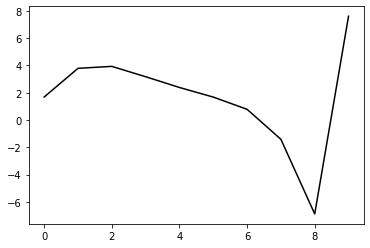

323400 24.69031792155428
0.6543742619550881 -0.2686107320426376 0.4835822453554359 0.26683393075798423
[ 1.75714166  3.65194843  3.78224411  3.01142043  2.21421472  1.50830294
  0.61531374 -1.57967089 -7.05218663  7.63978902]


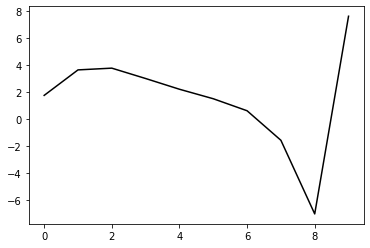

324500 21.638731077371894
0.6655106112362303 -0.261496762669294 0.4786613923150372 0.26814394962620375
[ 1.76979532  3.67363345  3.81444222  3.05100638  2.25802138  1.55670989
  0.66785519 -1.52495549 -6.99629533  7.65149833]


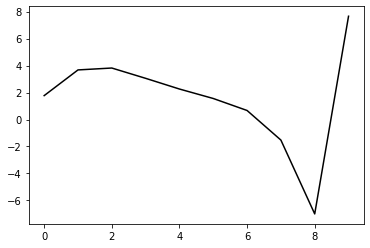

325600 19.733321194777666
0.7001250483410529 -0.23298390442536637 0.47373136747659156 0.2536521851879044
[ 1.73550643  3.73617357  3.89513496  3.14953648  2.37423185  1.69241751
  0.82124508 -1.36129472 -6.83813952  7.73176226]


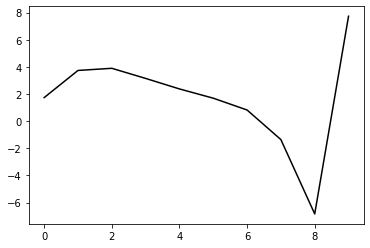

326700 13.81680040781016
0.6777811206747232 -0.2536554058158712 0.4824018760040415 0.2481009848816731
[ 1.70611453  3.68518067  3.82177291  3.05304794  2.25458135  1.55363006
  0.66654295 -1.53187579 -7.03096087  7.62794565]


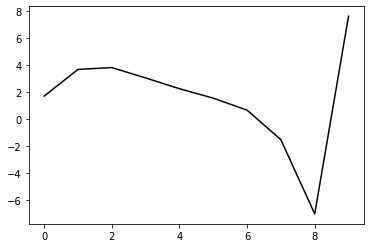

327800 19.66881702806463
0.6599079775841814 -0.26971303873472163 0.48698773587761157 0.2601622057539473
[ 1.76507391  3.55386945  3.72220799  2.98844299  2.22688622  1.5662758
  0.71847943 -1.44721252 -6.92278291  7.65984892]


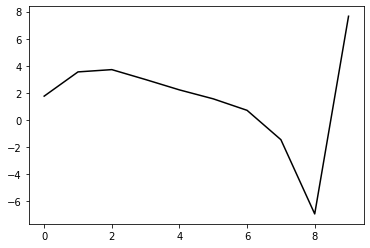

328900 17.900391825475346
0.6740021499817961 -0.2454636792136117 0.4716950918245159 0.2607517867968841
[ 1.76292086  3.62205483  3.76666076  3.00646848  2.21621433  1.52914709
  0.6568074  -1.53376174 -7.03965887  7.64091896]


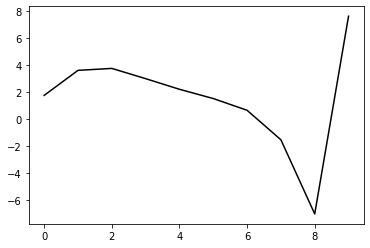

330000 17.05004868150938
0.6525169840713171 -0.2655787039880834 0.48230863814205593 0.2643890390281913
[ 1.83478709  3.49518997  3.65648097  2.91053641  2.13167784  1.45700839
  0.59719318 -1.58240678 -7.07860084  7.57248674]


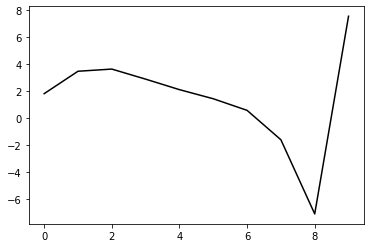

331100 19.914571547706917
0.6440324947581263 -0.2872400009432638 0.499157740076306 0.2558474224979308
[ 1.69314399  3.58881282  3.73949565  2.97732122  2.17750064  1.48298915
  0.60599268 -1.58809847 -7.09511972  7.67277307]


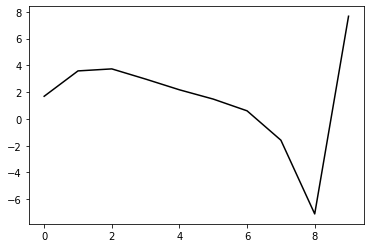

332200 46.09785645372764
0.6484806888693122 -0.25258932295384884 0.4748634388287485 0.26908944612886754
[ 1.87050983  3.50096629  3.66626613  2.92215373  2.1430175   1.47287605
  0.61994028 -1.55621947 -7.05564101  7.68131969]


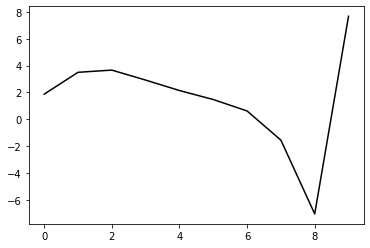

333300 21.918600672515385
0.6350122374054527 -0.26688643918644284 0.4803867426749613 0.2724644100282161
[ 1.77784727  3.6171447   3.7725502   3.01255884  2.21206562  1.51871531
  0.6417891  -1.55852806 -7.0807984   7.60570252]


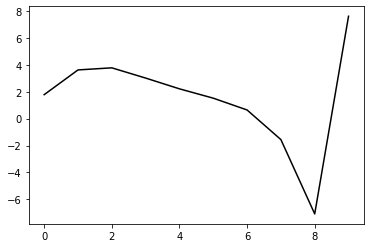

334400 25.084610276510944
0.6748744437269603 -0.25854188928088173 0.4895379406210206 0.2595772676366623
[ 1.69025188  3.80050448  3.98619851  3.25655942  2.48602463  1.82360146
  0.97536586 -1.20344422 -6.72285775  7.75223251]


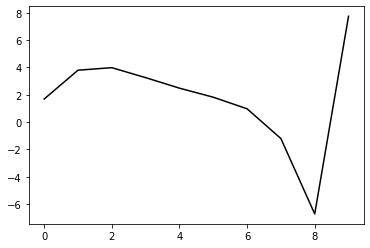

335500 39.27347827281013
0.6653411938581624 -0.267673108688303 0.4983732083954565 0.24202577669511063
[ 1.64939366  3.65166346  3.81255069  3.06237823  2.27612176  1.60557588
  0.75415093 -1.42847231 -6.95573263  7.6699774 ]


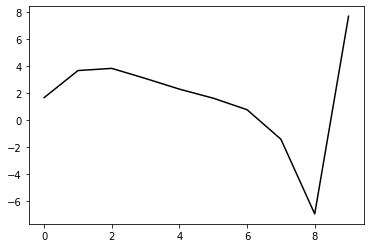

336600 30.1844994435915
0.7056762332306545 -0.22831584638027108 0.4782230603699832 0.2516619983091428
[ 1.62926272  3.89004074  4.06038561  3.31196465  2.52264758  1.85001791
  0.99737807 -1.18801576 -6.72552866  7.70909788]


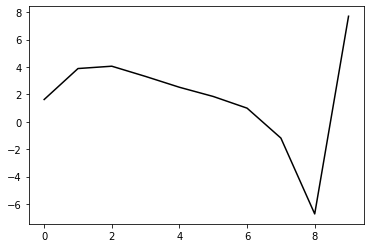

337700 15.843650649200155
0.6480869368716842 -0.25868639842690255 0.4819971153455926 0.2585025976307671
[ 1.78174627  3.60492589  3.76563733  3.00933985  2.21405747  1.54036053
  0.69033771 -1.49029993 -7.01421003  7.5985629 ]


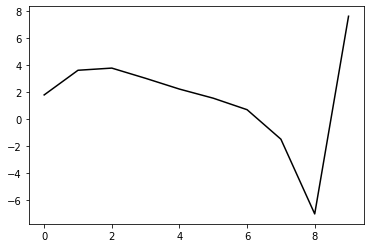

338800 17.17821273106563
0.666245543333008 -0.2572391428780467 0.48456382153318556 0.2630617721208024
[ 1.74415273  3.76305995  3.95672658  3.22611072  2.44676781  1.78206366
  0.93473345 -1.2475345  -6.77302923  7.68766838]


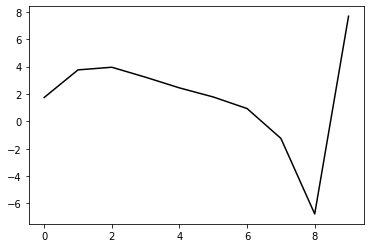

339900 18.283816209398864
0.632862090783643 -0.27715776490489213 0.49042431322780267 0.264171089455933
[ 1.83036484  3.49178377  3.64194777  2.86734503  2.04754611  1.35484211
  0.49424204 -1.6899115  -7.21282028  7.6483064 ]


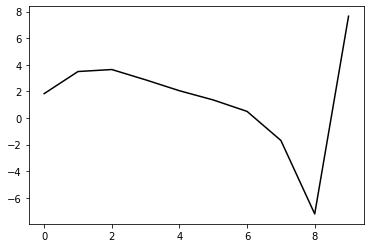

341000 11.26614301820047
0.6606605436875154 -0.2584129581564906 0.4857765044281213 0.2637880412721554
[ 1.74768412  3.69686866  3.87725299  3.13145787  2.33715344  1.66851098
  0.82764896 -1.34449187 -6.863702    7.68516908]


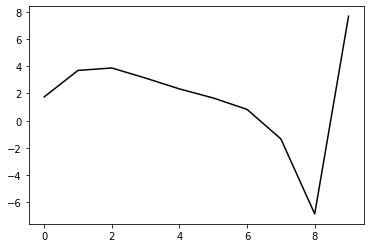

342100 25.72451849933102
0.653745231183128 -0.25549126891195967 0.48077276827607307 0.26426387518989497
[ 1.74083781  3.56600712  3.67692241  2.87076852  2.03271742  1.34202239
  0.49673656 -1.67010236 -7.17739947  7.64079477]


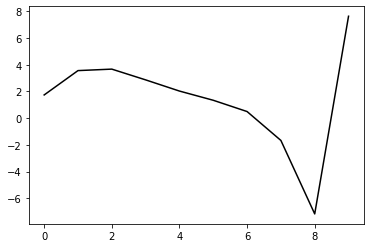

343200 16.767829058454733
0.6780355202118549 -0.2622438982013878 0.49160434013161286 0.2647379524209912
[ 1.70200833  3.71344453  3.84431891  3.05151336  2.22214901  1.5390823
  0.70005262 -1.46356643 -6.97483247  7.6128807 ]


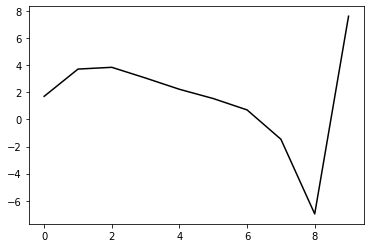

344300 16.325114423766415
0.6847712251251671 -0.2597030502065289 0.4926769645083584 0.25054299119622075
[ 1.7041025   3.66555347  3.78305281  2.97401125  2.12751286  1.429356
  0.5764767  -1.60280902 -7.14387979  7.59245328]


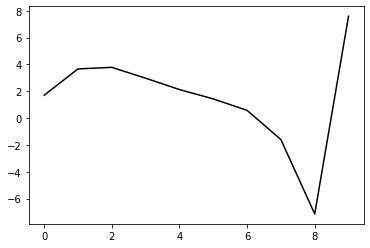

345400 22.92728230294637
0.6630568022134352 -0.2822748937897825 0.5017572963552471 0.26752417429607145
[ 1.70873442  3.68975858  3.83418023  3.04516841  2.21288575  1.52773553
  0.68797887 -1.47672994 -6.98955692  7.68587177]


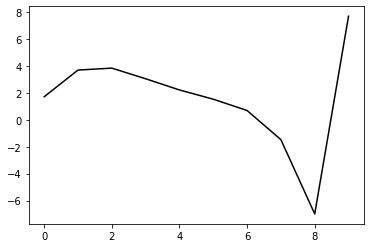

346500 73.40967796631678
0.6882931609584123 -0.27693418978483764 0.5075786932585824 0.25612246463994753
[ 1.56947098  3.78328278  3.93879877  3.15814348  2.33242008  1.65542842
  0.82347118 -1.33811473 -6.86471939  7.61247196]


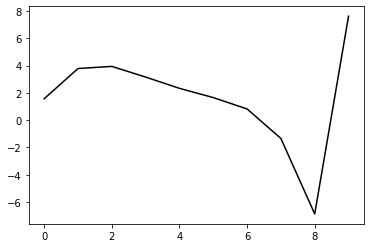

347600 20.66395756926185
0.6692058247085951 -0.2559422747429819 0.49347557192648306 0.2624426649239295
[ 1.72652234  3.6257541   3.78403834  3.00859542  2.18910411  1.52050638
  0.69675703 -1.46056842 -6.99383646  7.67025321]


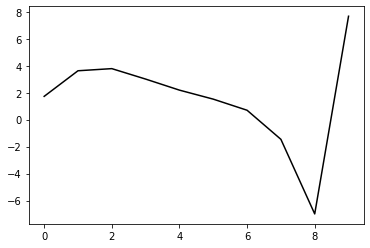

348700 18.04072786694298
0.648431133168865 -0.2596116293170258 0.4887920128481392 0.2761945748609986
[ 1.8110127   3.51907016  3.67087242  2.88982095  2.0661068   1.39804686
  0.57836897 -1.57360828 -7.09674314  7.64757808]


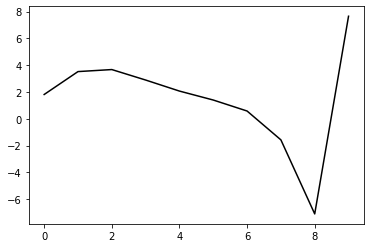

349800 23.748784265375324
0.6562102421029649 -0.27115135864634893 0.5041738177628823 0.2598482683245058
[ 1.704546    3.58383582  3.74608932  2.97808973  2.16768553  1.51432042
  0.70701499 -1.43992348 -6.97316871  7.59006702]


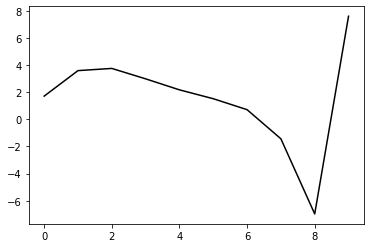

350900 19.82330739008883
0.611741024241493 -0.2717671003572034 0.49227382055631635 0.2810329029153792
[ 1.78934297  3.44721591  3.59325731  2.80875933  1.98188111  1.31660632
  0.50215055 -1.64893345 -7.18498938  7.69372831]


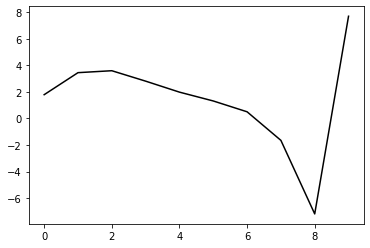

352000 10.966833622760044
0.6581983376495396 -0.2531321339735993 0.4917585736563014 0.2730543056578384
[ 1.75571127  3.61796691  3.78773269  3.02537322  2.21873256  1.57480301
  0.78114867 -1.35307003 -6.88172579  7.66662823]


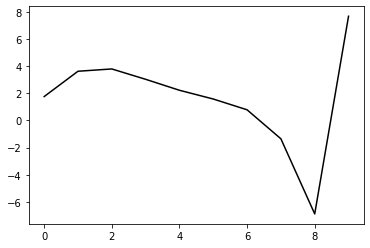

353100 27.11714934327571
0.62027415598546 -0.27515927938109075 0.4998998904208908 0.26925004833622623
[ 1.80966848  3.42458299  3.55865087  2.76172972  1.92524212  1.26329285
  0.46421465 -1.66757175 -7.19551734  7.62853411]


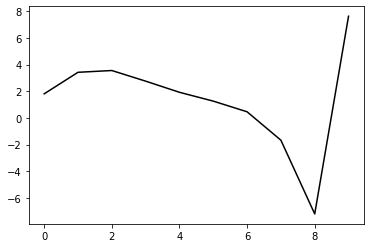

354200 18.677442177951235
0.647965005789991 -0.255391103800831 0.49307283139472585 0.26162212441077703
[ 1.72585201  3.56590451  3.70648777  2.91570726  2.08363869  1.42646392
  0.63043389 -1.50316923 -7.03791802  7.62217157]


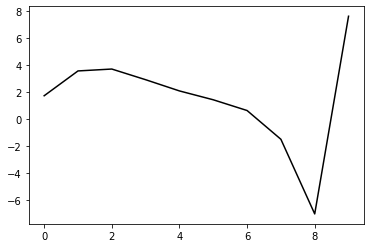

355300 17.727284204376218
0.6483717379869507 -0.2593018292978043 0.4950235830360708 0.2587270017586468
[ 1.72663249  3.59636425  3.73108564  2.93039786  2.08419689  1.41294089
  0.60386181 -1.54194216 -7.08399224  7.70294513]


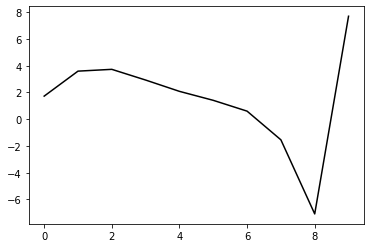

356400 44.36560113892308
0.6757819887043578 -0.2644738495526181 0.5061742409453167 0.25050183265382225
[ 1.62090901  3.71341279  3.87246328  3.09029993  2.256954    1.59620151
  0.79477641 -1.34783543 -6.89267935  7.62958981]


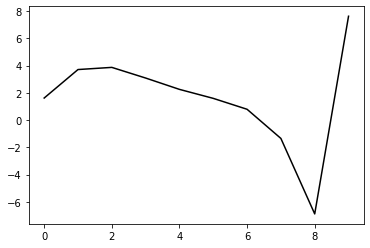

357500 23.427549176470908
0.6536715004825 -0.26595557779279555 0.4964131226231984 0.2697254854555298
[ 1.71760912  3.69621505  3.83050062  3.02046586  2.15950868  1.47754898
  0.66186113 -1.4898223  -7.0361983   7.65896929]


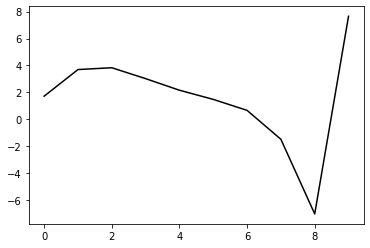

358600 24.759530147667217
0.6515432147516997 -0.2558526321664293 0.4844982574597198 0.276852184978634
[ 1.72425769  3.63945357  3.7433775   2.90866278  2.03104653  1.34285787
  0.52816453 -1.62037022 -7.16309079  7.58502677]


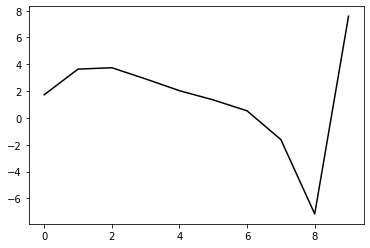

359700 11.785784143291647
0.677624672021275 -0.2552471535267804 0.4899224201691341 0.2773631141725213
[ 1.68820573  3.75111624  3.87442946  3.05469674  2.1886736   1.51141765
  0.70642701 -1.43476923 -6.97334201  7.70342032]


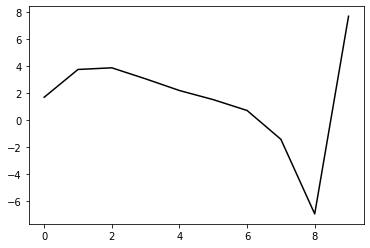

360800 18.22932843051533
0.6931105407262328 -0.24527554589407713 0.4847199840292552 0.2766035660529137
[ 1.69845225  3.76928836  3.89051712  3.06824218  2.20049587  1.52489356
  0.7232351  -1.41625349 -6.9569688   7.64392296]


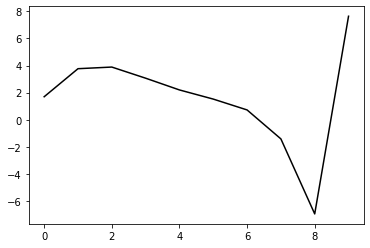

361900 17.130258391629646
0.6625880256267942 -0.2700171497192405 0.5016176447727507 0.26396315330806985
[ 1.67616635  3.63707467  3.75818503  2.93162424  2.0576226   1.37835396
  0.57517394 -1.5663569  -7.11010793  7.6169478 ]


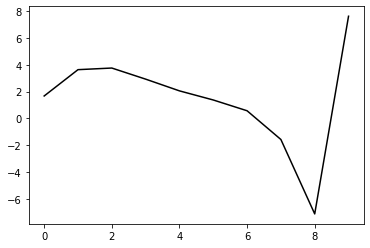

363000 52.24560241545064
0.6398254873856373 -0.3071272057817572 0.5309150956583036 0.2562589521491387
[ 1.67992803  3.46409031  3.61465756  2.82623517  1.99391111  1.35731351
  0.59152352 -1.5218944  -7.04843325  7.54212513]


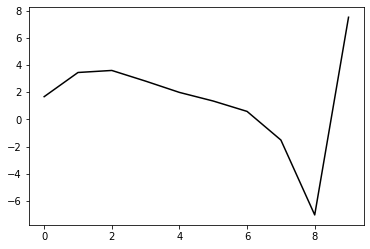

364100 21.60416771558673
0.6466424404885242 -0.26812618317000153 0.5016775516914154 0.2594103342725335
[ 1.67579197  3.43207241  3.54043603  2.72100056  1.86940541  1.22616584
  0.46095992 -1.6535797  -7.19562861  7.64662521]


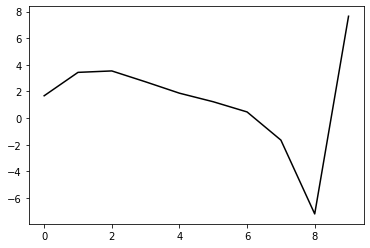

365200 39.05831780674236
0.6909827094043816 -0.2577034931443354 0.5064699181811109 0.2519166263033266
[ 1.6058794   3.61151488  3.73932674  2.93862484  2.10408987  1.47783682
  0.72792657 -1.37526392 -6.90895911  7.66987612]


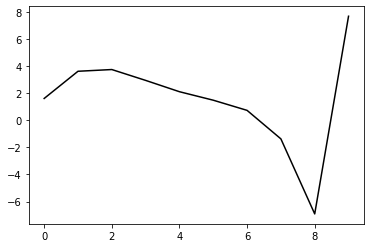

366300 12.742331373252378
0.6825510740780217 -0.25510671475082214 0.4999002540234485 0.27124574899537895
[ 1.70235946  3.61649744  3.78889735  3.02459287  2.2182383   1.61638404
  0.88772669 -1.19768584 -6.71997071  7.69658408]


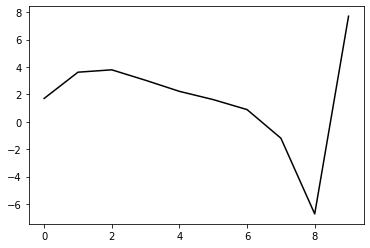

367400 25.028159889373615
0.6625244652927624 -0.2587796788544946 0.5009997828199653 0.2646817178716345
[ 1.76653708  3.46463335  3.60963285  2.81938064  1.98925295  1.37041811
  0.6311277  -1.46235868 -6.99302773  7.66321674]


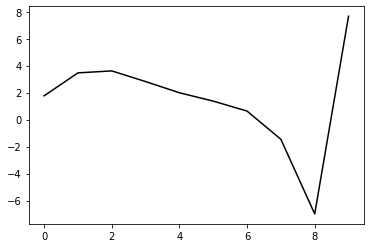

368500 21.058715868501302
0.6747469786560529 -0.24605750424784942 0.49619545120902736 0.26390073625001
[ 1.71242269  3.54206369  3.69759197  2.91600482  2.09095009  1.47635434
  0.73906123 -1.35802495 -6.90351768  7.67896197]


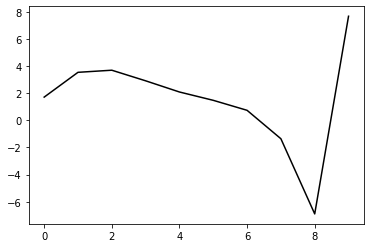

369600 21.48189946678994
0.6725176145981856 -0.2506222883073116 0.5011614502194464 0.2630260077781544
[ 1.71027195  3.51742478  3.68356705  2.91307866  2.09946956  1.5012634
  0.78516699 -1.28964117 -6.81706881  7.61906455]


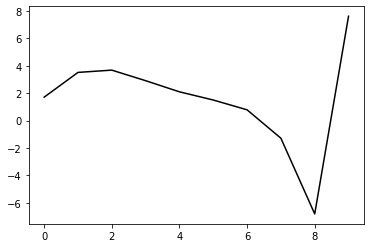

370700 32.88461501567589
0.6223245098330764 -0.26570905712494175 0.5018456939076011 0.2578398597263824
[ 1.81936665  3.21085377  3.32134708  2.4952424   1.62588269  0.97581627
  0.21359708 -1.9036511  -7.49143145  7.54844921]


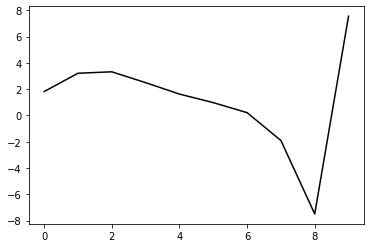

371800 34.26365958274803
0.6348208285662081 -0.289316245031591 0.52279948935635 0.2586498889995125
[ 1.73604294  3.35496633  3.48447428  2.67421043  1.81753681  1.18054085
  0.43250235 -1.66945631 -7.22694417  7.67827289]


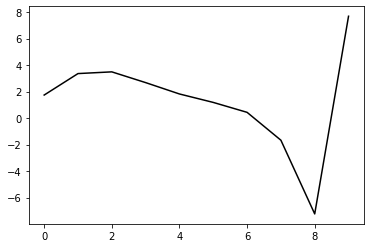

372900 55.92158357498209
0.6935194476433164 -0.2629133403532401 0.5140049688453042 0.2573285332077052
[ 1.59297344  3.62827642  3.77282817  2.97460075  2.12600506  1.4951702
  0.75047322 -1.35309393 -6.9225446   7.63107127]


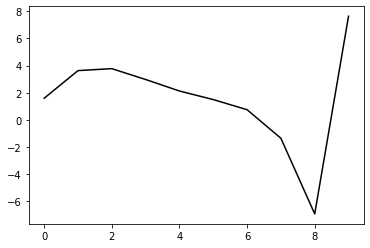

374000 11.958071506867887
0.6925329764245693 -0.2376166338392142 0.4908422324991903 0.27968296046701446
[ 1.72241718  3.64460735  3.79869756  3.00793454  2.16478148  1.53996027
  0.80149903 -1.29691161 -6.85884111  7.70153162]


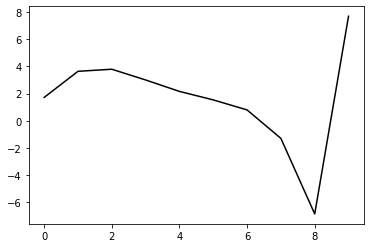

375100 21.259233719301577
0.6826031677338443 -0.25476211140396776 0.5021579395232857 0.2784159545637699
[ 1.66491194  3.70161446  3.86003376  3.06975054  2.22363052  1.5954753
  0.85389388 -1.2478513  -6.81076239  7.66363655]


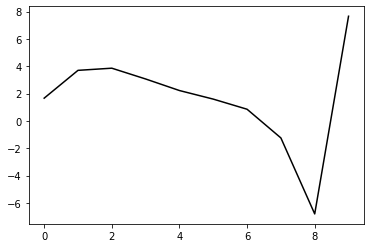

376200 18.91421557030146
0.6466749953329797 -0.25844219614185104 0.5020674155086373 0.27405595609098254
[ 1.72906508  3.46051724  3.61694843  2.83171958  1.99616982  1.38427026
  0.66064512 -1.42863112 -6.99544812  7.72036177]


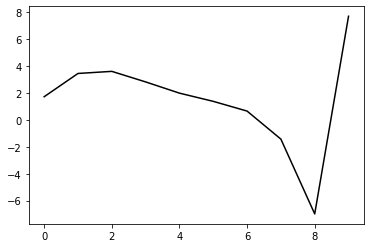

377300 19.42459665985417
0.654799383104192 -0.24776076186393622 0.49816152084083704 0.27289888210025826
[ 1.77945307  3.39980338  3.56543414  2.79231024  1.97022111  1.37551844
  0.67107592 -1.4011452  -6.95802029  7.71172839]


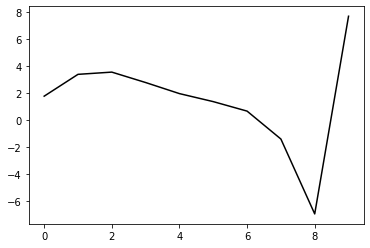

378400 22.893224597943448
0.6593505727086044 -0.24771591554035227 0.49949723809296037 0.2678479532111621
[ 1.69441463  3.48343877  3.63716612  2.85056824  2.01207944  1.40190327
  0.68332915 -1.40440658 -6.98548237  7.69100475]


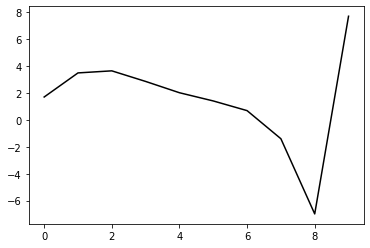

379500 31.29879008225807
0.6638122021723296 -0.23973862222543768 0.4919611997529352 0.2831229827008506
[ 1.77261259  3.51280226  3.69880392  2.94228408  2.12998222  1.54569859
  0.85236446 -1.21259956 -6.77107863  7.66839232]


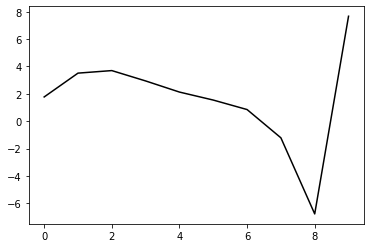

380600 20.63788819278481
0.6537944876474127 -0.2604966030488279 0.5069960699223339 0.2806186971516963
[ 1.6961367   3.56714611  3.74643605  2.98048605  2.15657827  1.56415955
  0.86846334 -1.19392883 -6.74403355  7.77140611]


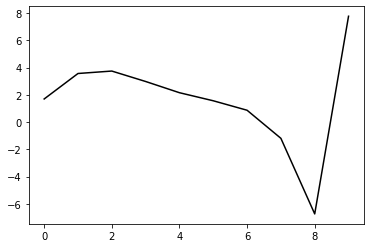

381700 14.29274574040048
0.6468616199461369 -0.24012979174450866 0.497134768205764 0.27083079844862823
[ 1.72754231  3.43948922  3.59512718  2.81462583  1.98272512  1.38846227
  0.69309225 -1.37321422 -6.93865575  7.67832948]


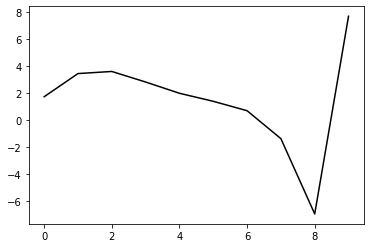

382800 17.76858900523163
0.6676250610986104 -0.23047903334263897 0.49916985232772854 0.2643837046884177
[ 1.72562997  3.4537076   3.6358852   2.88270924  2.0766774   1.50775302
  0.83531053 -1.21358569 -6.7710865   7.65892992]


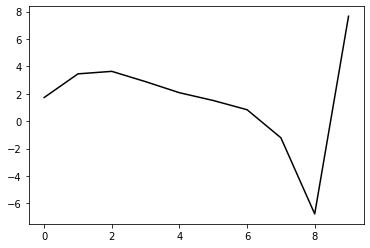

383900 11.67247970426372
0.666555982707833 -0.23269464309261598 0.49615834656960667 0.2708791546869801
[ 1.67481295  3.49977584  3.66309839  2.89056775  2.06450779  1.47891577
  0.79389065 -1.26458913 -6.82598503  7.72783225]


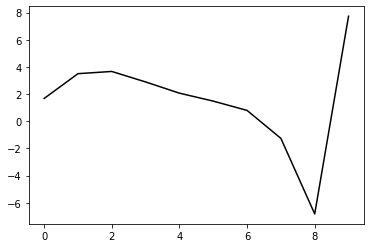

385000 16.361163569488223
0.6260306270429278 -0.25000831780990707 0.4965183102345162 0.27505679633296937
[ 1.71292008  3.40561902  3.53474667  2.72866614  1.86934754  1.25437421
  0.54444215 -1.5359076  -7.1178765   7.58466635]


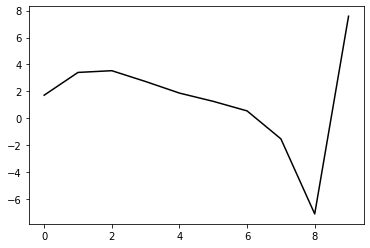

386100 21.091568828430972
0.6453400336182445 -0.2563450096920159 0.5062496523739626 0.2656150573688164
[ 1.64394618  3.54608403  3.67158593  2.85794493  1.98752645  1.36115565
  0.64015944 -1.4509704  -7.03633738  7.65884943]


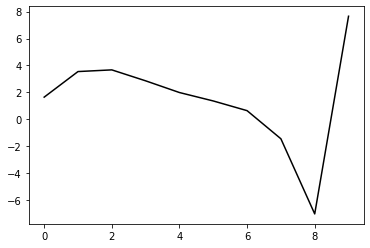

387200 23.32216661645706
0.6389936084093941 -0.2707788819302179 0.5144009212972702 0.2708876555354327
[ 1.63001146  3.58943464  3.72341768  2.91121797  2.03686761  1.40621403
  0.68231776 -1.40967305 -6.98933769  7.64019593]


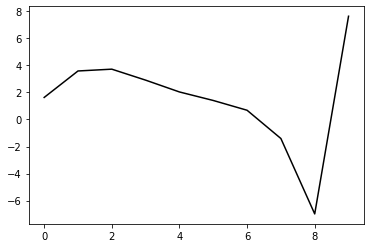

388300 18.812783836862646
0.6318602072694375 -0.25019255393062734 0.4972517749229717 0.2764756406111121
[ 1.71322238  3.44807333  3.58983887  2.79326891  1.9400678   1.33525001
  0.63713768 -1.43511573 -7.00492936  7.62048238]


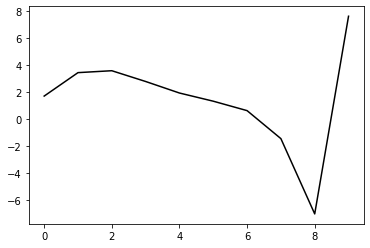

389400 27.674772299086985
0.6193687986378905 -0.2594161105990645 0.49877281474632257 0.2669321208827288
[ 1.66147599  3.51468098  3.59282691  2.7308636   1.81323947  1.14939606
  0.39953143 -1.71798619 -7.33346494  7.61657335]


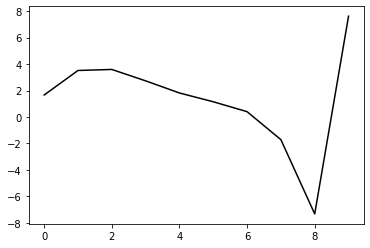

390500 20.404416976802278
0.6478851484275059 -0.24549300559677525 0.49137428794428395 0.2868246442578398
[ 1.70543121  3.65066649  3.77862318  2.95640891  2.07055509  1.43389584
  0.70721435 -1.39088878 -6.98319431  7.62413087]


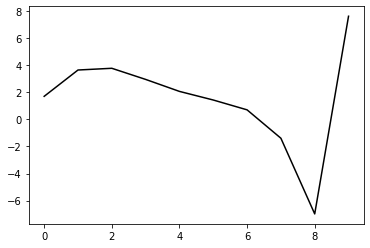

391600 22.24933518401119
0.6467200977204683 -0.2511200815545173 0.4954632912033201 0.289150767889965
[ 1.70846725  3.6334892   3.7795393   2.97067718  2.09433198  1.46637246
  0.7476913  -1.34422627 -6.93324324  7.7169869 ]


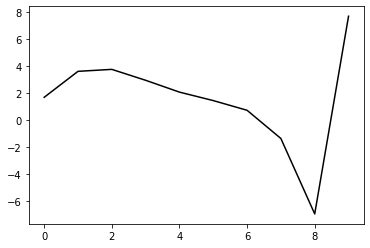

392700 12.041168879836889
0.6769995129140918 -0.23461087704787903 0.4887453658001944 0.2858224060978264
[ 1.67643043  3.7754532   3.93240106  3.12734572  2.24867326  1.61701661
  0.89459248 -1.2016414  -6.79620912  7.71797775]


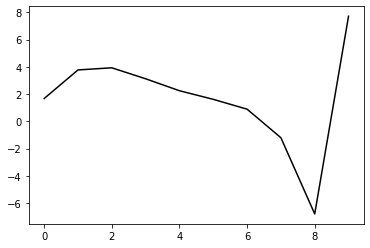

393800 18.287917082412058
0.6752676393696503 -0.23442328010454733 0.48876628696619345 0.28221014109606707
[ 1.70169777  3.72815075  3.89066598  3.08472351  2.19753693  1.55356249
  0.81799172 -1.29092749 -6.89304096  7.65552607]


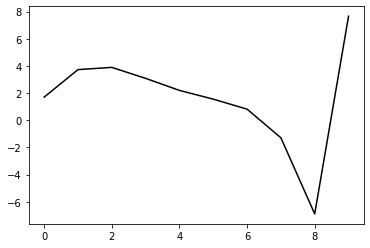

394900 14.85262297321178
0.6568612979930346 -0.24345618019851428 0.49163915360289484 0.28186826204166826
[ 1.73086535  3.58968576  3.75077367  2.94732411  2.06803207  1.43961338
  0.72405459 -1.36677205 -6.95792691  7.55585568]


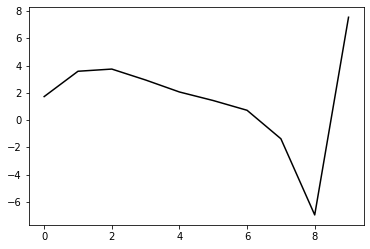

396000 11.242478035458895
0.6520154478777329 -0.24428892537253405 0.492098191270124 0.28289165717623616
[ 1.71759513  3.61123116  3.77940392  2.98045025  2.1031553   1.47758056
  0.76570158 -1.32256397 -6.91155532  7.62770462]


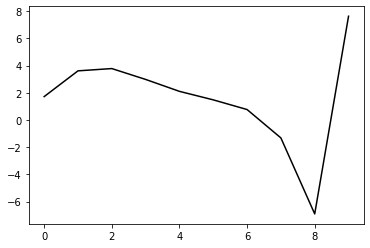

397100 21.571912814756445
0.6666335310536996 -0.2296330785928878 0.4902477111465764 0.2730289930471878
[ 1.71811815  3.58949203  3.78344882  3.01408286  2.16742701  1.57254651
  0.88728533 -1.18395074 -6.77515986  7.69904709]


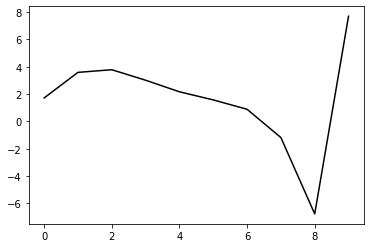

398200 15.82882453304901
0.6678460534171404 -0.24148595576914703 0.4992582046057207 0.26466026009946314
[ 1.67458001  3.5109761   3.72542155  2.98434133  2.16938665  1.6082487
  0.95347142 -1.09655089 -6.68220624  7.75889557]


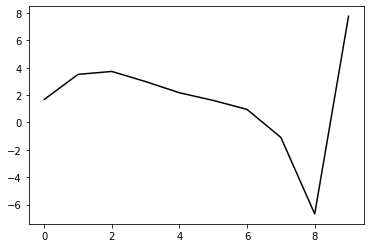

399300 19.19186218576034
0.63866188321243 -0.24961752581730007 0.49691916022222443 0.2655613511832495
[ 1.68041645  3.36771894  3.51668072  2.71280224  1.83990854  1.23327379
  0.5468305  -1.52482386 -7.1273799   7.63566556]


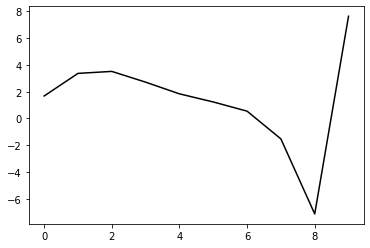

400400 26.595433777739686
0.634211097680441 -0.24636182370223508 0.4892597140591067 0.27807018874498673
[ 1.70925755  3.41701065  3.55691829  2.7390043   1.84643121  1.22073391
  0.51899787 -1.56315415 -7.1642359   7.64823825]


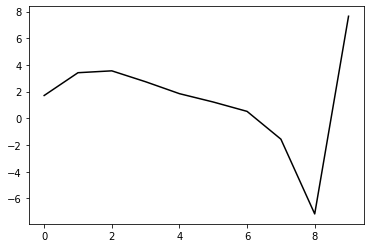

401500 21.95094509784451
0.6415075350813415 -0.24891407801001011 0.49272099125183205 0.28090174189548556
[ 1.71282025  3.45881865  3.62373742  2.82713079  1.95155479  1.34143822
  0.65403849 -1.41559989 -6.99750747  7.58647843]


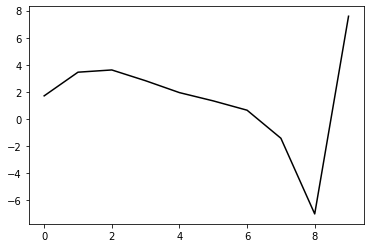

402600 18.114274875820097
0.6575500455804286 -0.24521659124237294 0.4943256292071628 0.2873822921559912
[ 1.7145193   3.59463174  3.80535856  3.05174406  2.21488815  1.64171767
  0.98842869 -1.05297027 -6.6201581   7.75186351]


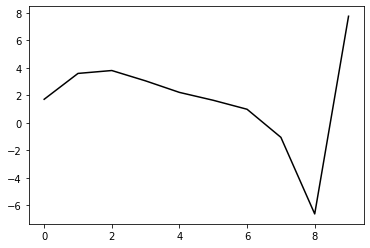

403700 14.973929276114228
0.6553417560018336 -0.25429975726957665 0.5020499836797643 0.2768588132995102
[ 1.66190983  3.62531594  3.8033729   3.01319416  2.13658146  1.52452536
  0.834351   -1.24277939 -6.841791    7.65861715]


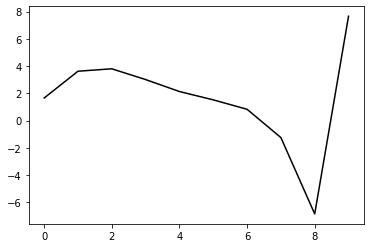

404800 26.844031588842537
0.6368679163401856 -0.23251559694060764 0.47985587890188725 0.28454788597519654
[ 1.74847372  3.36542682  3.46890188  2.62815462  1.72968622  1.12136118
  0.45088806 -1.60066732 -7.17337474  7.61903794]


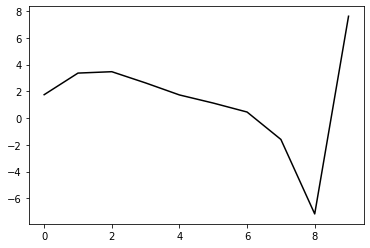

405900 74.49085049113077
0.6778475031045629 -0.2648309135217217 0.5168455926112034 0.2620374422714184
[ 1.52485703  3.71837001  3.85466695  3.02353898  2.11623568  1.48987968
  0.79698184 -1.27959125 -6.88032593  7.72468406]


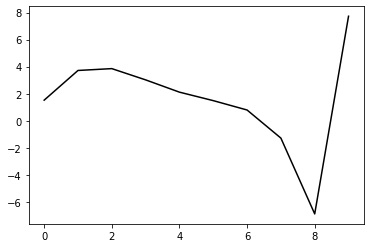

407000 13.629009703751622
0.6442893399713115 -0.24208807505978344 0.49582803737283876 0.2823223304504573
[ 1.7471252   3.48846867  3.64745881  2.84836658  1.97812045  1.39122492
  0.73539803 -1.31219765 -6.90068713  7.59321252]


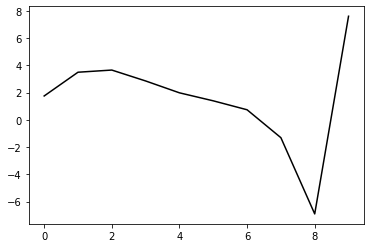

408100 27.737119501756126
0.6297448603570698 -0.2529053226947306 0.5009609104049476 0.28018682305863657
[ 1.78603444  3.30736811  3.45515784  2.6511055   1.7807951   1.1998677
  0.55375257 -1.48380846 -7.06134487  7.66457229]


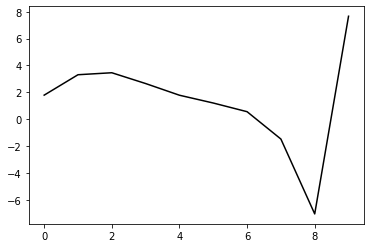

409200 26.634583878253906
0.6123120807179938 -0.2782245152032857 0.5202449579404206 0.2592603483855504
[ 1.65123095  3.37250544  3.49201001  2.65740048  1.75515627  1.14528616
  0.47434499 -1.58567967 -7.18677169  7.5901625 ]


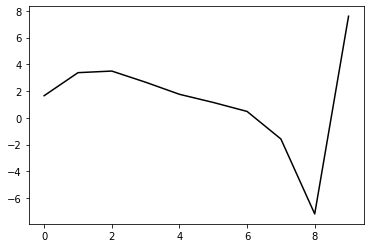

410300 59.50749207939434
0.6365352520215166 -0.29343854775791184 0.5398040443787548 0.23812343231573763
[ 1.60918671  3.40702858  3.52180053  2.67713043  1.76271476  1.14344896
  0.46598383 -1.60101195 -7.21489535  7.66055522]


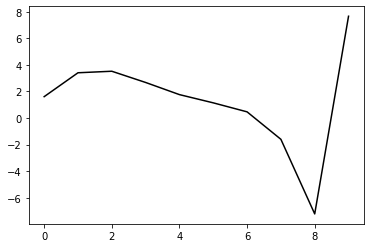

411400 19.73555693543119
0.6534193975312784 -0.26041542299349296 0.5109961591000217 0.28103604921439224
[ 1.71719127  3.5456354   3.73305676  2.95781383  2.10556277  1.54104355
  0.90806442 -1.1269702  -6.72320286  7.67911991]


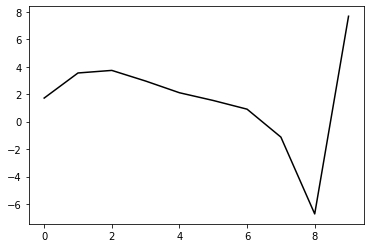

412500 27.198615834030505
0.6369560743984256 -0.26036948628126005 0.5090758660042146 0.2758049315137639
[ 1.78944203  3.24103121  3.38530597  2.59262112  1.74480991  1.19979215
  0.59163757 -1.42095882 -6.99563198  7.63278894]


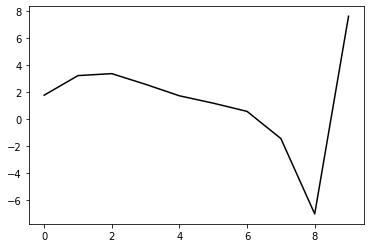

413600 19.190610090699874
0.6718845290281886 -0.24102207240771792 0.5013804803422605 0.279028541743323
[ 1.75237294  3.44960298  3.64704517  2.89643466  2.07578021  1.54757682
  0.94763004 -1.06598468 -6.65983744  7.67000008]


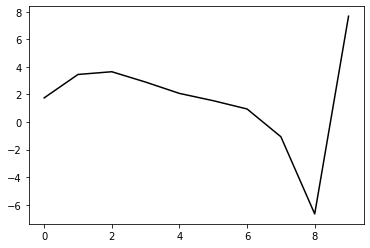

414700 26.51415795662098
0.6832500123520581 -0.24412989393481652 0.5094585325611004 0.2705172616770024
[ 1.67647302  3.55881516  3.7626122   3.01838313  2.20118463  1.67564576
  1.07669903 -0.94101707 -6.55121815  7.71591063]


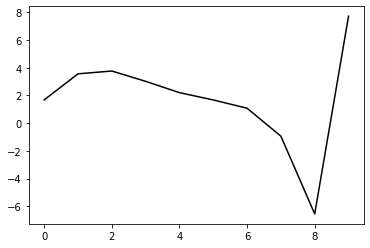

415800 21.225904760808174
0.6546727329437415 -0.24455481413577437 0.5038261619735562 0.2748786407374602
[ 1.7954126   3.36608965  3.53688348  2.76610463  1.93039939  1.39750288
  0.80058983 -1.20937213 -6.80009045  7.57605771]


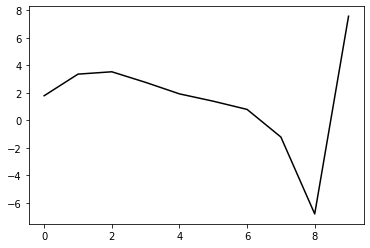

416900 16.82426844986958
0.6303165135553161 -0.24282567409252195 0.4995923098279191 0.2687774486611594
[ 1.74755877  3.25842544  3.37287765  2.54922292  1.66457543  1.09058838
  0.46185987 -1.57390087 -7.19913498  7.63349281]


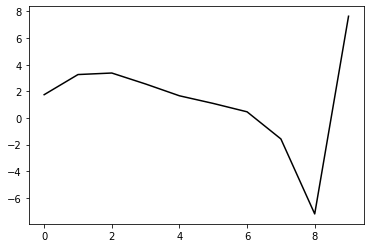

418000 21.58863427974697
0.6463614475956906 -0.24512512504685802 0.5038875883153064 0.2799691387774575
[ 1.83595605  3.28361773  3.45865993  2.69194156  1.85727021  1.32842047
  0.73950723 -1.26317237 -6.85915901  7.60388257]


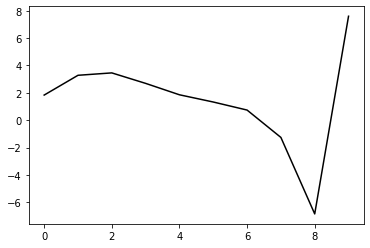

419100 21.90529930227289
0.6694711413492185 -0.2375456713207566 0.5027895768758487 0.27289519660603967
[ 1.7470394   3.44128034  3.60433719  2.8222148   1.96738754  1.41734147
  0.80803225 -1.21422646 -6.83013067  7.69321938]


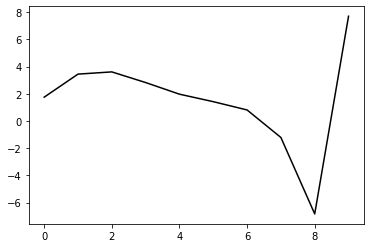

420200 23.24647926605026
0.6833048945695098 -0.23615984434708198 0.5089892608369978 0.25649653046589854
[ 1.66385537  3.52944911  3.68941292  2.90272702  2.03978476  1.48038254
  0.86067262 -1.17532744 -6.81676419  7.66700711]


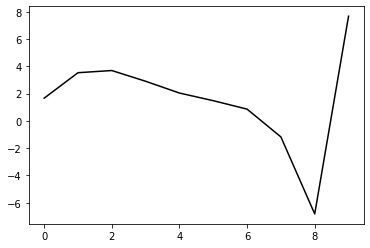

421300 20.559466670183095
0.6437886716389289 -0.24393732602393556 0.5017221950450106 0.26696713951347256
[ 1.74728495  3.36922447  3.50114803  2.68800942  1.79981678  1.21954805
  0.58468903 -1.46178382 -7.10582146  7.6501502 ]


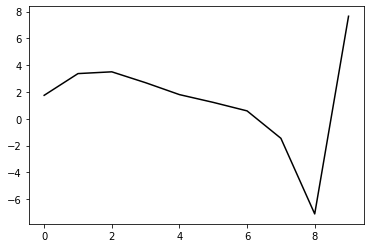

422400 22.93595984198039
0.6596373450682206 -0.2534000870578714 0.511162495536097 0.27114830929958905
[ 1.73634522  3.48618459  3.64258565  2.84707792  1.96920285  1.39569182
  0.76577566 -1.27689317 -6.91555598  7.65413927]


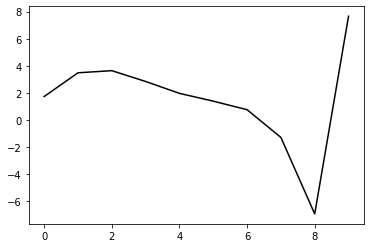

423500 21.543297368644225
0.6575301898380933 -0.2491781304116496 0.5025989438937954 0.2799573060775582
[ 1.76578906  3.56568217  3.72279704  2.91948024  2.0246358   1.43020455
  0.77956521 -1.28097738 -6.92747204  7.59344683]


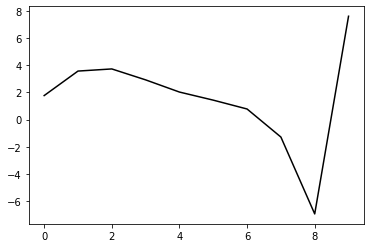

424600 28.16696179537311
0.6283976310688395 -0.2543039822605301 0.5022533134409918 0.2668493948074678
[ 1.75017692  3.40867759  3.51832652  2.67719335  1.75403976  1.14159818
  0.48055343 -1.58923915 -7.25544599  7.5851463 ]


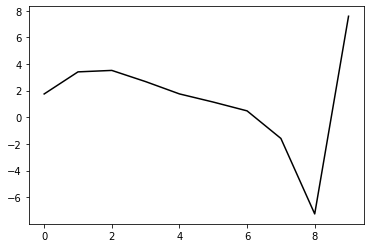

425700 25.41099569141717
0.674085138701613 -0.2528579532048687 0.5133078415790852 0.2664824895957495
[ 1.68053633  3.64516733  3.80598838  3.0034463   2.10688249  1.51302921
  0.86461799 -1.19741349 -6.85884191  7.7358245 ]


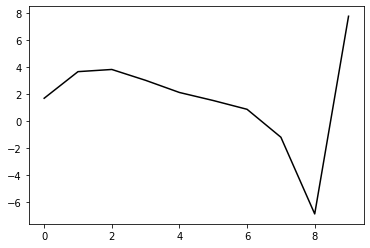

426800 19.14701359741978
0.6645432259429799 -0.24921371843249598 0.5076360002748904 0.26978529172721594
[ 1.75389525  3.56886462  3.73447631  2.94016506  2.05302852  1.4699544
  0.83188424 -1.22343601 -6.88294108  7.64408973]


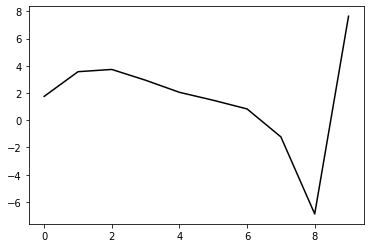

427900 22.129951906189174
0.6358038594853177 -0.2527289764940954 0.5032668643277894 0.27773700798547746
[ 1.84471342  3.42288461  3.57687625  2.77246402  1.87577571  1.28593753
  0.64426166 -1.41327169 -7.07483492  7.67555291]


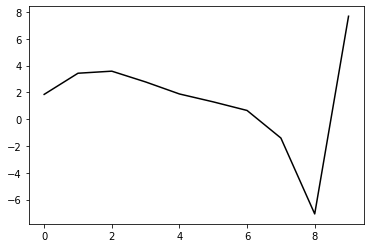

429000 16.28821046907341
0.6622487562280575 -0.2418095069966648 0.5054684283566474 0.2611189304914341
[ 1.69347493  3.58026718  3.72523562  2.91206592  2.00611088  1.40770631
  0.75743693 -1.31184926 -6.9951438   7.63254486]


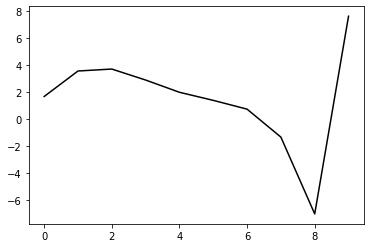

430100 26.190979269404295
0.6297750306469954 -0.2498369268391424 0.5006898501646824 0.27167531922873467
[ 1.79241057  3.41528672  3.55716418  2.74478321  1.84379837  1.25614791
  0.62115987 -1.43204103 -7.10171844  7.69449445]


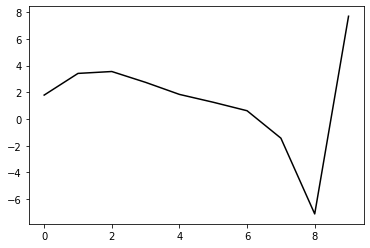

431200 28.660293617362992
0.6302181453133183 -0.25376675990304 0.5019070808760883 0.27542978056911704
[ 1.84900611  3.36186729  3.50613803  2.69536202  1.79454994  1.20905448
  0.57947349 -1.4656012  -7.12002042  7.61613355]


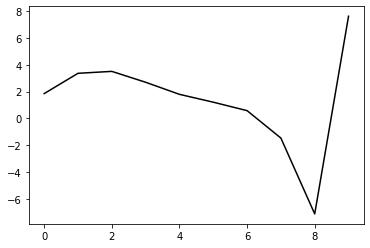

432300 13.388621233678968
0.6717088042996892 -0.23471786730255356 0.5020414433899062 0.2617691476201013
[ 1.69320467  3.61892204  3.77556285  2.97433983  2.07961067  1.49824428
  0.87025323 -1.17821272 -6.84377873  7.62313339]


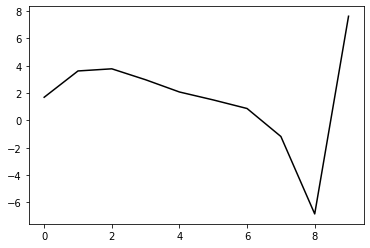

433400 33.239065956133516
0.6679821659385321 -0.2206933229332394 0.4868177023011704 0.2745726995509222
[ 1.76763365  3.57011144  3.70083695  2.87325031  1.95303275  1.34963657
  0.70352813 -1.36067178 -7.0390925   7.59264674]


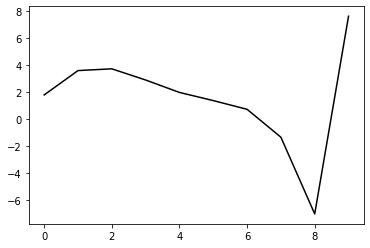

434500 19.598694042279337
0.6745981892197755 -0.22888834248275186 0.49271734458451333 0.2702622805134603
[ 1.71990133  3.64472284  3.76636343  2.92797058  1.99661845  1.38401629
  0.73063478 -1.3405732  -7.02535338  7.64935429]


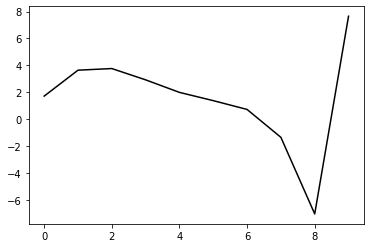

435600 22.851690283063657
0.6432715873206027 -0.2543069328529659 0.5028711265976656 0.28216725225376826
[ 1.75010688  3.59763524  3.75101995  2.93876305  2.02793962  1.43330668
  0.79598798 -1.26177715 -6.93592624  7.55413484]


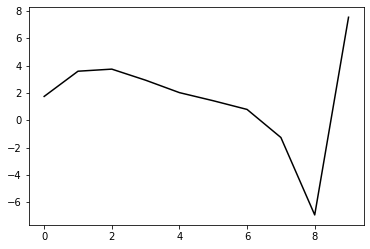

436700 21.128740474429616
0.6270116960499386 -0.2798888970540369 0.5186452347000257 0.26515132440303085
[ 1.73011151  3.50644232  3.59254943  2.71776923  1.75552     1.12515221
  0.46679124 -1.60295282 -7.29067431  7.62745478]


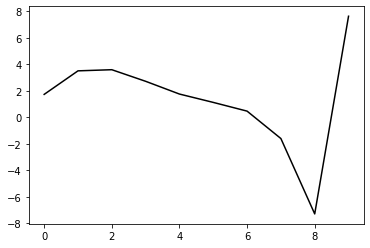

437800 53.44868914274781
0.6349434307607428 -0.23485797984552415 0.4772977817029322 0.2931460194757042
[ 1.87078757  3.39074035  3.48681027  2.61796297  1.65908299  1.03197798
  0.37725195 -1.68941785 -7.37019099  7.63754267]


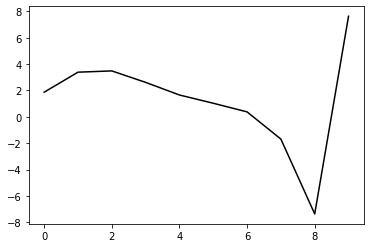

438900 15.480021004590773
0.679203235447674 -0.2388208811481193 0.49134626599372916 0.28507496509901914
[ 1.72814134  3.742015    3.86216713  3.00314627  2.04139114  1.40211171
  0.72872814 -1.36085654 -7.06770298  7.57496538]


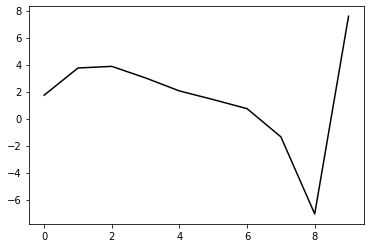

440000 31.6807928360151
0.6373452410114387 -0.28815741095552555 0.5228052177042769 0.26589869992492393
[ 1.63411949  3.66851819  3.74793687  2.84446974  1.8386709   1.16064237
  0.45614566 -1.65765057 -7.38388011  7.55695537]


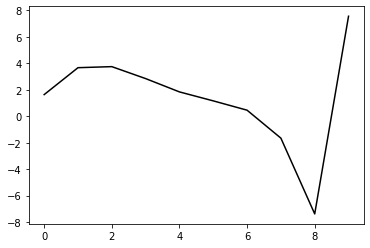

441100 24.998714843198677
0.666167975095036 -0.24345467040661053 0.49223481564108934 0.28305751483268166
[ 1.68937394  3.69240275  3.79462936  2.91230351  1.92759573  1.27114091
  0.58647426 -1.51317511 -7.23268798  7.65626335]


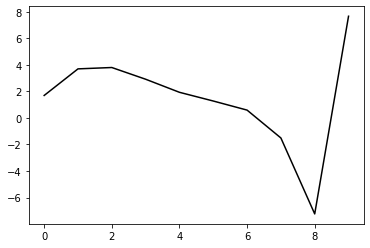

442200 13.508959820721476
0.6986655845938928 -0.23439131955770348 0.49406715194223233 0.2776182831055176
[ 1.67628578  3.81981985  3.96051894  3.11108748  2.15341342  1.51915892
  0.85114259 -1.23899446 -6.95850655  7.65018758]


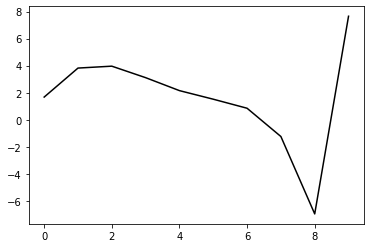

443300 17.36964696248063
0.6558078398434654 -0.2655271979422989 0.5058986170599029 0.2718650609413259
[ 1.67962094  3.70280588  3.80253405  2.90849955  1.90397591  1.22322969
  0.51124424 -1.62018111 -7.38312277  7.58167875]


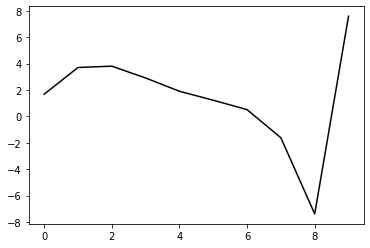

444400 20.573676026000033
0.6820747351691876 -0.25692901233706894 0.5065462975469965 0.2825472962535401
[ 1.67882855  3.84311633  4.00841656  3.17410388  2.22287672  1.58876667
  0.914663   -1.18939532 -6.93501461  7.69155574]


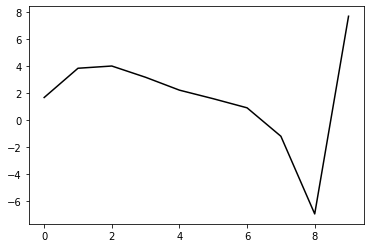

445500 21.77954209732398
0.6566827440686429 -0.25670906165624285 0.5010636873235078 0.2874306744633678
[ 1.75247557  3.69112005  3.85141788  3.01675923  2.07081726  1.44872052
  0.79130367 -1.29655394 -7.0291319   7.58469082]


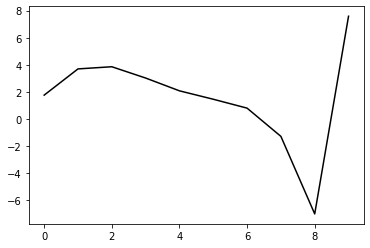

446600 53.75744878291735
0.6800460754757063 -0.26446682646691366 0.5178073725690164 0.2680032366293858
[ 1.59476274  3.79858364  3.96006328  3.12553695  2.17846638  1.55565651
  0.89775868 -1.19310733 -6.93947462  7.67491404]


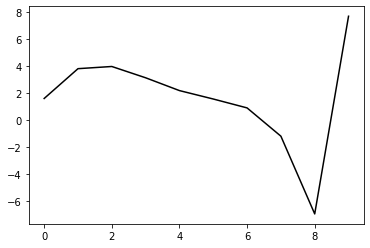

447700 11.819993413030979
0.6755581496257685 -0.24375594225195307 0.4988439990602951 0.27949859372987684
[ 1.71536326  3.73784138  3.89726773  3.05943428  2.10826153  1.48265434
  0.82360266 -1.26884433 -7.02173666  7.6487692 ]


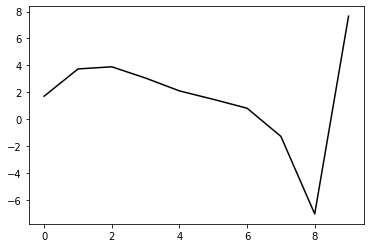

448800 43.2493612134326
0.6320373383666683 -0.29869739376126775 0.5359519661755288 0.261167505013474
[ 1.71462236  3.45606246  3.61795669  2.78585539  1.84465085  1.23433815
  0.59377126 -1.48151645 -7.22291987  7.6768463 ]


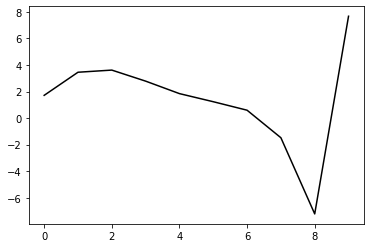

449900 10.93043667368057
0.6900101414379787 -0.23177975377893473 0.49502051234483063 0.27113526065246135
[ 1.70923228  3.64077861  3.82609657  3.02186297  2.11025378  1.53022309
  0.91688317 -1.14025642 -6.88653109  7.71414442]


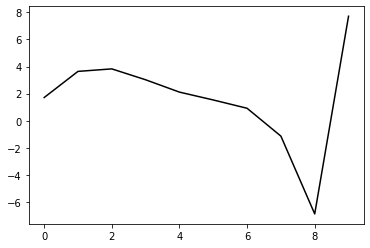

451000 27.754817458668153
0.6733381054386889 -0.25434851608511566 0.5091289105149377 0.262400610615089
[ 1.64238473  3.64050387  3.80473529  2.9731821   2.02827967  1.41245203
  0.76335243 -1.32853661 -7.10343733  7.61662315]


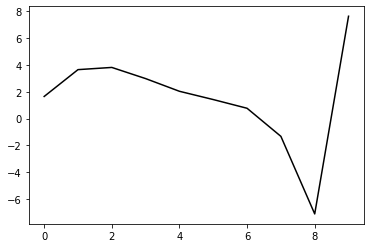

452100 64.22014198280331
0.6785882779881203 -0.2651017150219773 0.5187185174725157 0.2584614077300539
[ 1.57024938  3.72343719  3.89694926  3.07165344  2.12921678  1.51462175
  0.86631136 -1.22602831 -7.00175147  7.70271564]


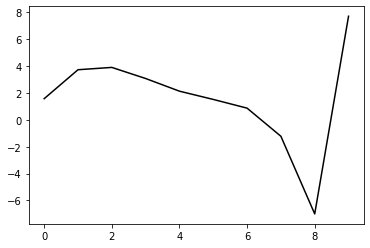

453200 19.69354530245388
0.6280398185841503 -0.2690087484688148 0.5093681429607124 0.27594147697404653
[ 1.72832643  3.4926092   3.65583134  2.82819456  1.88987647  1.28577047
  0.65188638 -1.4264319  -7.18733036  7.62028449]


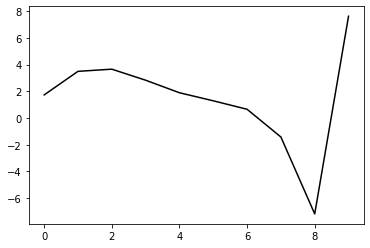

454300 25.688517024977735
0.6471919102183973 -0.23909496617491155 0.48792264429224924 0.2872565193621355
[ 1.76280709  3.53078617  3.6942573   2.86525904  1.92364434  1.31684504
  0.68114823 -1.40028233 -7.16994445  7.6129487 ]


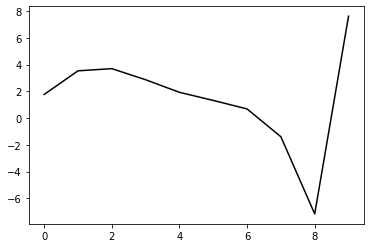

455400 25.09744847101599
0.6628720592321019 -0.25406515854034506 0.5056940704350845 0.27366811099524874
[ 1.64113154  3.65432453  3.82994389  3.00892669  2.07081821  1.46595553
  0.8310715  -1.25264958 -7.02999329  7.67532999]


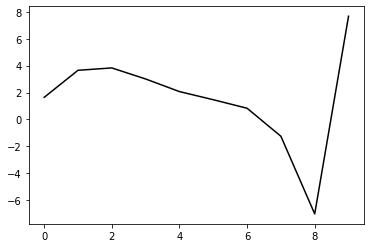

456500 28.25093288262189
0.617118768312295 -0.25781458485388425 0.49838350755150074 0.28029772310550966
[ 1.77353809  3.39649865  3.55175411  2.72404337  1.79331562  1.21032748
  0.60645921 -1.44628323 -7.19837339  7.6244151 ]


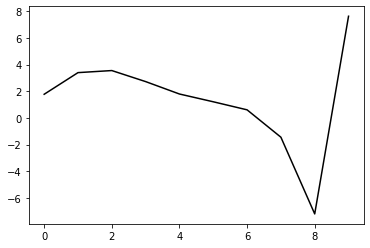

457600 75.89991249217192
0.6776635228546521 -0.26959837063633824 0.5247899633150812 0.2543743706409825
[ 1.55269005  3.7189668   3.90346519  3.08806978  2.15305251  1.5566819
  0.93614192 -1.13361161 -6.90099066  7.61745404]


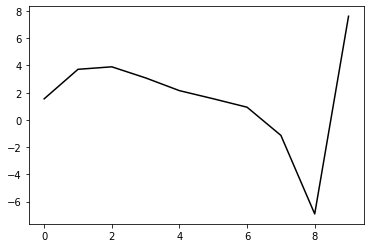

458700 46.82348973747075
0.645921323823256 -0.24740182118801296 0.4951624896593897 0.2900993073595445
[ 1.86557738  3.42935198  3.64962912  2.88851475  2.02146447  1.50087285
  0.95306962 -1.05711035 -6.78595168  7.72670143]


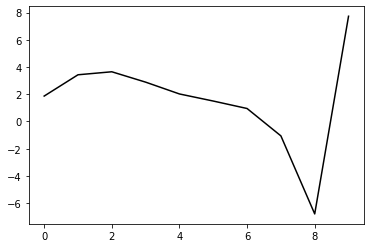

459800 27.919739389167674
0.6219630969109647 -0.2481723737842749 0.49372361452674557 0.2850667787815502
[ 1.81324045  3.32317601  3.48736609  2.67819419  1.77673544  1.23930129
  0.68897497 -1.31728917 -7.0377682   7.61352573]


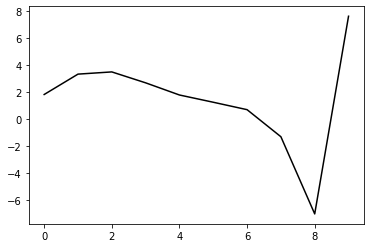

460900 14.068946801442682
0.6387852061156045 -0.25776976764425014 0.5068359599395035 0.27125111200057384
[ 1.70805336  3.39558292  3.54744445  2.72427616  1.80609988  1.25224257
  0.68707819 -1.33326602 -7.06715151  7.70501296]


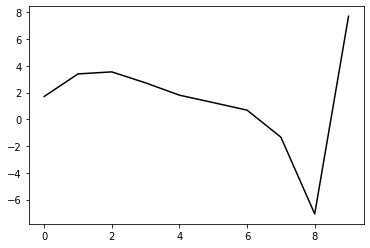

462000 32.38891123378536
0.6187503742189284 -0.28299786093496365 0.5245154765859003 0.2568428160021394
[ 1.66370837  3.4423369   3.57507891  2.73010963  1.78763599  1.21025178
  0.62377985 -1.41659706 -7.17224272  7.55884387]


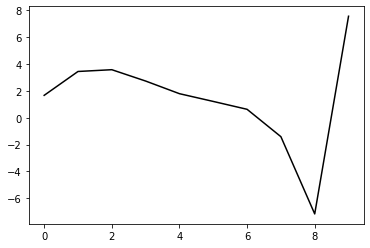

463100 22.73940796278516
0.6604680750633422 -0.24882994617910023 0.5020217814389542 0.27500474152252113
[ 1.74071662  3.49406312  3.66100023  2.84604203  1.92916708  1.37511744
  0.80992436 -1.2121817  -6.94877783  7.66761673]


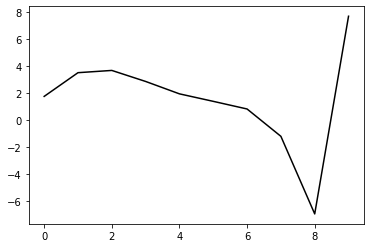

464200 18.1275178555056
0.6534033700533245 -0.26019125856276376 0.5107225173338834 0.2764863505212629
[ 1.74885569  3.50550626  3.68883572  2.89071871  1.98985323  1.45216825
  0.90296448 -1.1060594  -6.83626364  7.69654492]


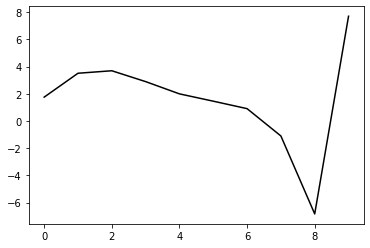

465300 15.61194768167933
0.654019606198074 -0.26146018526528875 0.513349100722406 0.2652410886497214
[ 1.68697873  3.56562313  3.72228743  2.8945595   1.96090986  1.39005949
  0.80928803 -1.2303418  -6.99418345  7.70856019]


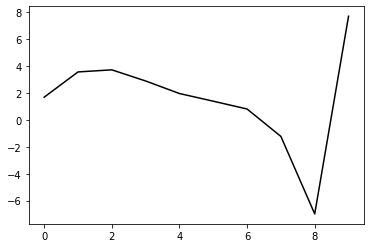

466400 24.572211857809
0.6332519670258071 -0.266231276947159 0.5114892473578145 0.26831583228357125
[ 1.71605364  3.49490508  3.65036996  2.82121096  1.88354344  1.30762216
  0.72140722 -1.32487195 -7.09787891  7.56702857]


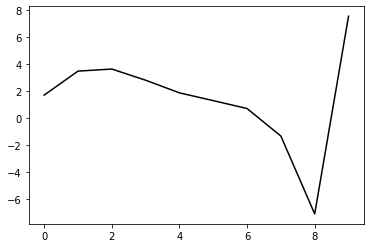

467500 22.276088137170245
0.6550590277259211 -0.24888412236776716 0.5041606580520154 0.27265836510378694
[ 1.69610025  3.6034454   3.77658906  2.96506951  2.0436765   1.48317108
  0.91033504 -1.12694707 -6.89354021  7.66990465]


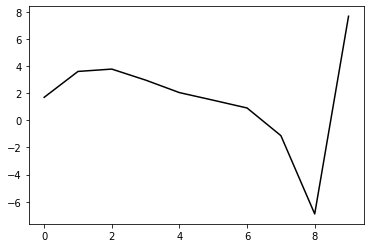

468600 20.50985556450311
0.6463068268350819 -0.2598681071536867 0.5120529423936152 0.2703199303550029
[ 1.70720673  3.53349532  3.71775287  2.92117595  2.01743822  1.47794246
  0.92760854 -1.08953986 -6.84020633  7.68255846]


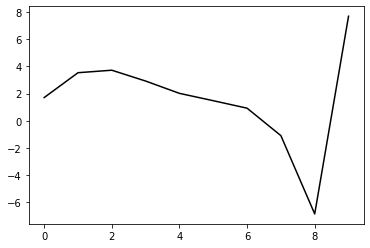

469700 22.342233965906452
0.6213102723251814 -0.26288667855680853 0.5085177374819421 0.2673173325669663
[ 1.78441558  3.288784    3.4316379   2.60290048  1.67659649  1.12603085
  0.57413591 -1.4419407  -7.2061094   7.66874177]


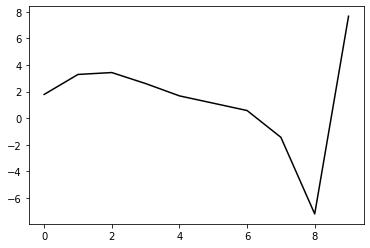

470800 22.62553250487531
0.6411437902145678 -0.2424866990862308 0.49560765073640917 0.27545097014758124
[ 1.74580679  3.39864417  3.56210235  2.75120073  1.83795282  1.29755207
  0.75342181 -1.25776091 -7.01225651  7.66149013]


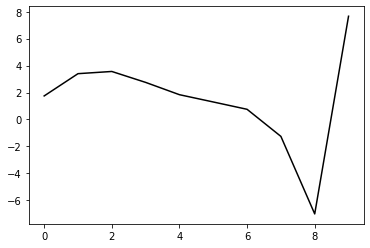

471900 11.669706733051079
0.6472629266447195 -0.24649959337752447 0.5025811618270093 0.2697365835983221
[ 1.70272225  3.47227694  3.6492683   2.85027347  1.94557782  1.41253518
  0.8746751  -1.13363975 -6.89320894  7.65379452]


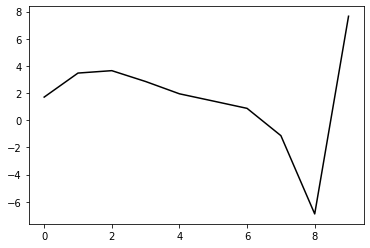

473000 18.513349874337088
0.6389588406313795 -0.23759477540110194 0.4916595492253584 0.26335383978426324
[ 1.68180151  3.42797308  3.51116065  2.62750355  1.65444685  1.0735476
  0.50681012 -1.517852   -7.29210753  7.59172701]


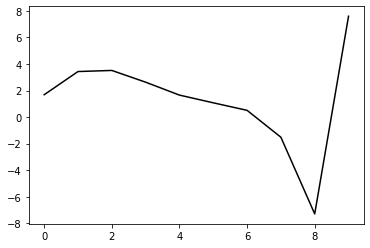

474100 22.051411880135973
0.6361470353104061 -0.25417527311131805 0.5021628006082796 0.27144708942008006
[ 1.66101912  3.49552693  3.61383974  2.7515234   1.78701051  1.20692503
  0.63721934 -1.39159637 -7.16169754  7.66174263]


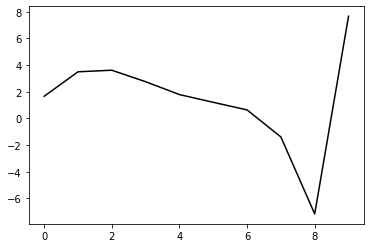

475200 15.961844996493715
0.6668911027362041 -0.21822426412499216 0.4852492715326097 0.27238147836506227
[ 1.65564213  3.62536048  3.76194696  2.91711287  1.9675279   1.39900817
  0.83522733 -1.19761262 -6.99475114  7.60879888]


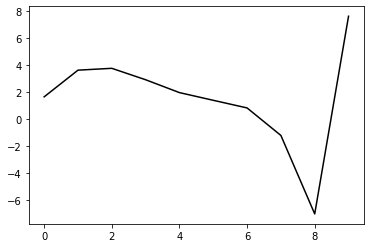

476300 15.663119541585083
0.6599514039576675 -0.22832135959377745 0.49075872876581883 0.27857369947110544
[ 1.6871948   3.63773212  3.79624474  2.97129465  2.03863391  1.48614319
  0.93824182 -1.0799507  -6.86188006  7.67252197]


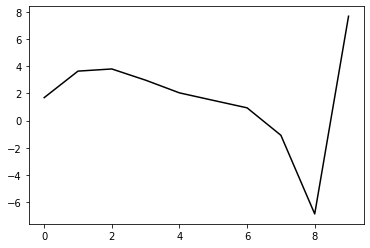

477400 21.525281695887337
0.6434499706614987 -0.25032453494890444 0.5033010031503341 0.2721523356169747
[ 1.70368254  3.56031603  3.72355496  2.90449764  1.97716332  1.42936521
  0.88441294 -1.13482344 -6.91986366  7.65814959]


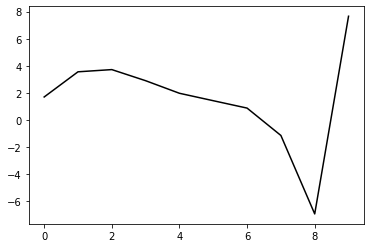

478500 21.122474130497153
0.6353657904829925 -0.24751759871894669 0.49648280681481965 0.2817394977912659
[ 1.73068737  3.59979267  3.75129049  2.91630123  1.9696234   1.40252681
  0.84055448 -1.19292384 -6.98432497  7.65403001]


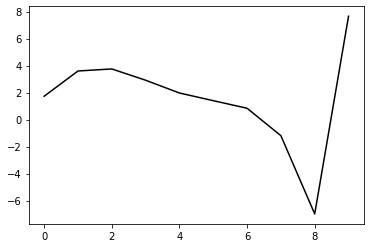

479600 21.84634512629713
0.6374811890578677 -0.24517781726881846 0.4982567573855718 0.27104256639481794
[ 1.70418805  3.59870868  3.74175766  2.8979483   1.94200837  1.36563457
  0.79352809 -1.25411546 -7.07122745  7.63885688]


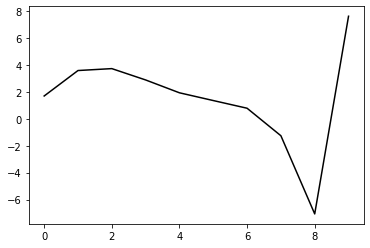

480700 17.524718807759157
0.6276431616118023 -0.25829249617849903 0.5047291907963027 0.2756510276101197
[ 1.75949507  3.49111912  3.64849698  2.81747106  1.87289504  1.30847627
  0.74930543 -1.28577618 -7.08762778  7.65469246]


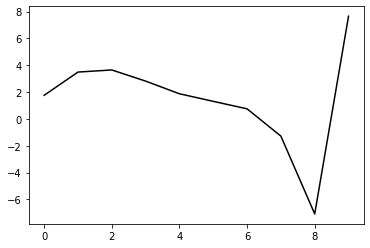

481800 22.07651848023661
0.6331252033038652 -0.23774379524308553 0.4917183959790899 0.2760472248469176
[ 1.72881945  3.496422    3.6388469   2.80246051  1.86158427  1.30871704
  0.76556558 -1.25415454 -7.04265567  7.63023893]


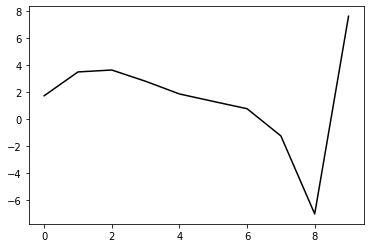

482900 10.217634352639571
0.6522289674913796 -0.23238787190075974 0.4945500183908965 0.2724547826357803
[ 1.69237454  3.58481591  3.75048736  2.93206946  2.00339665  1.45886661
  0.9209424  -1.09746133 -6.88967697  7.69098315]


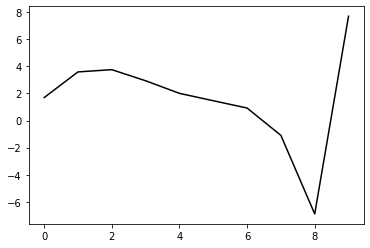

484000 12.01041773536659
0.6296883005905812 -0.25506052447195715 0.5027476130576422 0.28059847652706765
[ 1.74644069  3.46787689  3.65996988  2.87082312  1.97192737  1.45806052
  0.94983007 -1.04297296 -6.81315827  7.5904882 ]


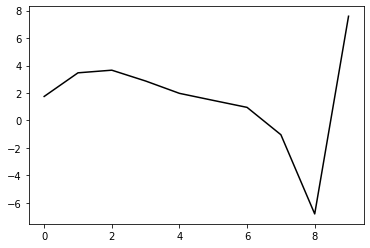

485100 39.2536112916999
0.5958405379058747 -0.2543212261924837 0.49289797101904803 0.28528626704811977
[ 1.87015864  3.18583315  3.33149336  2.50481936  1.57567069  1.03998028
  0.51809489 -1.4832956  -7.26447045  7.67563822]


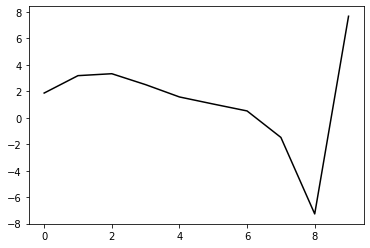

486200 30.153040236478745
0.6640275720847479 -0.24508848532559446 0.5060696597346638 0.25960616658877245
[ 1.60404724  3.59792702  3.7535001   2.92932768  1.99665103  1.45415185
  0.92295206 -1.09144597 -6.88928776  7.67624863]


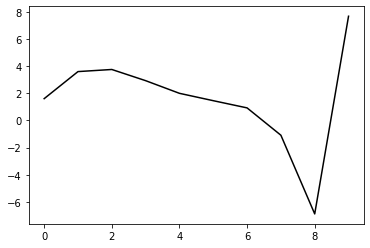

487300 14.633704408376149
0.6346643770250259 -0.26086075221392985 0.5094021054900205 0.26820928346416395
[ 1.70053223  3.39965088  3.59193238  2.80737105  1.91364193  1.40896278
  0.91272174 -1.07242991 -6.84590188  7.67738473]


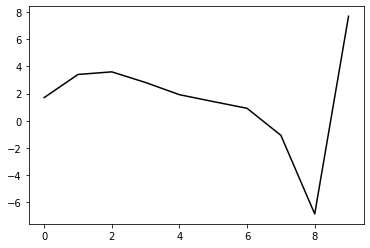

488400 24.773945746120766
0.6424539500348523 -0.2533913313037184 0.5093111638113181 0.25911754893524275
[ 1.67809566  3.43514081  3.62386044  2.83998893  1.94779132  1.44512882
  0.94975042 -1.0395089  -6.83123466  7.62092665]


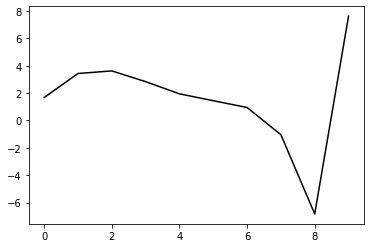

489500 36.29189076832692
0.597169049537914 -0.2502213865671239 0.49526414392583734 0.2539379590022917
[ 1.73154681  3.09876628  3.19885543  2.34742541  1.40735271  0.87419975
  0.36093495 -1.64230531 -7.47343157  7.53524392]


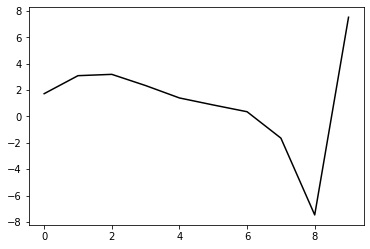

490600 25.537199647212976
0.6401695826228798 -0.2511904186310843 0.5010462495769855 0.267251974685919
[ 1.6879533   3.40885677  3.53751279  2.69303988  1.74438187  1.19631925
  0.66780185 -1.34743705 -7.17364557  7.67467064]


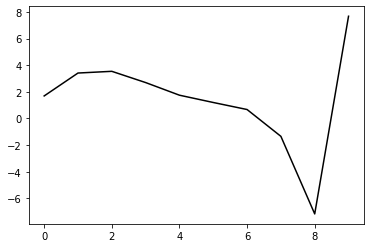

491700 11.09020734846917
0.6613505182727251 -0.25056401145711116 0.5008988512553576 0.2759724973556425
[ 1.70771576  3.61088854  3.76732271  2.93979844  1.99875739  1.45307424
  0.92423278 -1.09301435 -6.92102456  7.64826327]


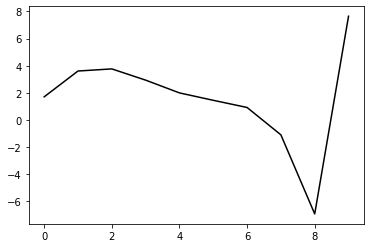

492800 23.192308534007893
0.6314774826521098 -0.25157741979567944 0.49590654817083796 0.27649832318994644
[ 1.71809648  3.51750921  3.64389125  2.79149437  1.83016094  1.26865906
  0.72741599 -1.30120531 -7.13674629  7.62791709]


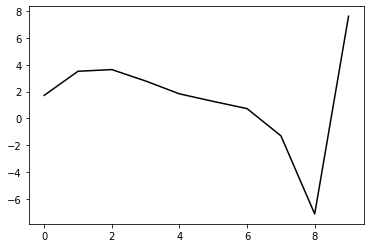

493900 11.46960065039207
0.6728931323178841 -0.23587310424373736 0.49585287266946426 0.27418749440564133
[ 1.68147061  3.65781517  3.82466608  3.00809305  2.07749139  1.54175303
  1.02046019 -0.99600389 -6.83485943  7.75074064]


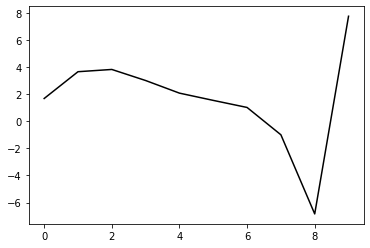

495000 10.638581694820815
0.6613611595436172 -0.23984232712567335 0.49577748359210716 0.27835664475713134
[ 1.71731698  3.57588448  3.75058118  2.9428443   2.02145283  1.49630501
  0.98638069 -1.02041238 -6.85440327  7.67768583]


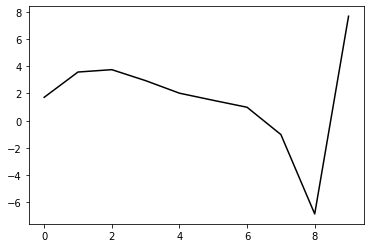

496100 29.2156433844262
0.635848685027003 -0.27417551131697854 0.5193140484612091 0.2728962015183036
[ 1.65730579  3.57784377  3.76287285  2.96184177  2.04342678  1.5201625
  1.01272244 -0.99122682 -6.81794392  7.66587269]


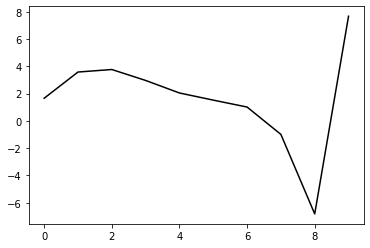

497200 28.998807206237732
0.6524286005187662 -0.26655074819119823 0.5199876207105247 0.26068814275153823
[ 1.66566832  3.52178758  3.70092884  2.90052454  1.98765797  1.47394448
  0.97762724 -1.01887535 -6.85319608  7.69100797]


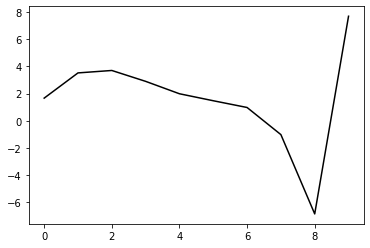

498300 19.429797694550857
0.6239364643894161 -0.2558424187217827 0.5064716247011735 0.26807179403096115
[ 1.73584734  3.33525542  3.49761089  2.68721366  1.76879828  1.25285756
  0.75561371 -1.24407925 -7.08622305  7.64889614]


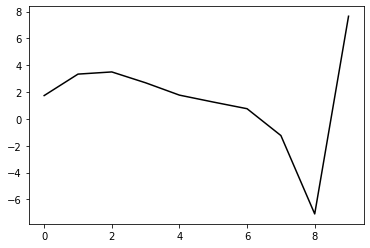

499400 27.542496768550382
0.6103941219573592 -0.25788966881761777 0.5027347166595854 0.2815770913666826
[ 1.75970004  3.31833505  3.49965595  2.70492489  1.79697949  1.28883886
  0.79824618 -1.19600281 -7.03165741  7.70227958]


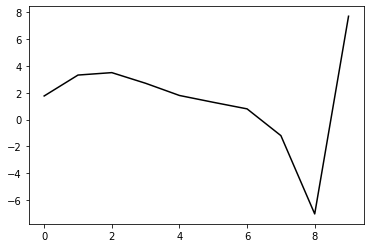

In [29]:
optimizer=tf.optimizers.Adam(learning_rate=0.001)
for j in range (5000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%10], Negative[j%10])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
    for i in range (80):
        optimizer.apply_gradients(zip(gradients, [h]))
    for i in range (20):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
    if j%11==0: 
        print(j*100, Error_func(h, m2, lam, alpha, beta, Positive[j%10], Negative[j%10]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()

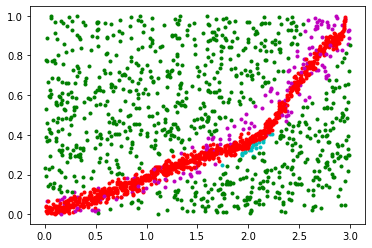

In [30]:
for i in range (set):
    [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
    [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
for i in range (set):
    x_data1[i]=[v[0] for v in Positive0[i]]
    y_data1[i]=[v[1] for v in Positive0[i]]
    x_data2[i]=[v[0] for v in Positive1[i]]
    y_data2[i]=[v[1] for v in Positive1[i]]
    x_data3[i]=[v[0] for v in Negative0[i]]
    y_data3[i]=[v[1] for v in Negative0[i]]
    x_data4[i]=[v[0] for v in Negative1[i]]
    y_data4[i]=[v[1] for v in Negative1[i]]
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()